##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train your model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 0s

    16384/252872794 [..............................] - ETA: 16:02

    49152/252872794 [..............................] - ETA: 10:42

   106496/252872794 [..............................] - ETA: 7:25 

   204800/252872794 [..............................] - ETA: 5:08

   425984/252872794 [..............................] - ETA: 3:05

   868352/252872794 [..............................] - ETA: 1:48

  1753088/252872794 [..............................] - ETA: 1:02

  3506176/252872794 [..............................] - ETA: 35s 

  6397952/252872794 [..............................] - ETA: 21s

  9183232/252872794 [>.............................] - ETA: 16s

 12066816/252872794 [>.............................] - ETA: 13s

 14950400/252872794 [>.............................] - ETA: 11s

 17891328/252872794 [=>............................] - ETA: 10s

 20856832/252872794 [=>............................] - ETA: 9s 

 23879680/252872794 [=>............................] - ETA: 9s

 26714112/252872794 [==>...........................] - ETA: 8s

 29540352/252872794 [==>...........................] - ETA: 8s

 32489472/252872794 [==>...........................] - ETA: 7s

 35258368/252872794 [===>..........................] - ETA: 7s

 38117376/252872794 [===>..........................] - ETA: 7s

 41000960/252872794 [===>..........................] - ETA: 6s

 43810816/252872794 [====>.........................] - ETA: 6s

 46653440/252872794 [====>.........................] - ETA: 6s

 49569792/252872794 [====>.........................] - ETA: 6s

 52502528/252872794 [=====>........................] - ETA: 5s

 55238656/252872794 [=====>........................] - ETA: 5s

 58155008/252872794 [=====>........................] - ETA: 5s

 61202432/252872794 [======>.......................] - ETA: 5s

 64118784/252872794 [======>.......................] - ETA: 5s

 66985984/252872794 [======>.......................] - ETA: 5s

 70066176/252872794 [=======>......................] - ETA: 5s

 72884224/252872794 [=======>......................] - ETA: 4s

 75702272/252872794 [=======>......................] - ETA: 4s

 78618624/252872794 [========>.....................] - ETA: 4s

 81444864/252872794 [========>.....................] - ETA: 4s

 84312064/252872794 [=========>....................] - ETA: 4s

 87171072/252872794 [=========>....................] - ETA: 4s

 89055232/252872794 [=========>....................] - ETA: 4s

 91987968/252872794 [=========>....................] - ETA: 4s

 95035392/252872794 [==========>...................] - ETA: 4s

 97992704/252872794 [==========>...................] - ETA: 4s

100950016/252872794 [==========>...................] - ETA: 4s

103833600/252872794 [===========>..................] - ETA: 3s

106782720/252872794 [===========>..................] - ETA: 3s

109658112/252872794 [============>.................] - ETA: 3s

112574464/252872794 [============>.................] - ETA: 3s

115507200/252872794 [============>.................] - ETA: 3s

118546432/252872794 [=============>................] - ETA: 3s

121528320/252872794 [=============>................] - ETA: 3s

124436480/252872794 [=============>................] - ETA: 3s

127434752/252872794 [==============>...............] - ETA: 3s

130523136/252872794 [==============>...............] - ETA: 3s

133578752/252872794 [==============>...............] - ETA: 3s

136626176/252872794 [===============>..............] - ETA: 2s

139468800/252872794 [===============>..............] - ETA: 2s

142532608/252872794 [===============>..............] - ETA: 2s

145473536/252872794 [================>.............] - ETA: 2s

148545536/252872794 [================>.............] - ETA: 2s

151609344/252872794 [================>.............] - ETA: 2s

154451968/252872794 [=================>............] - ETA: 2s

157499392/252872794 [=================>............] - ETA: 2s

160407552/252872794 [==================>...........] - ETA: 2s

163471360/252872794 [==================>...........] - ETA: 2s

166543360/252872794 [==================>...........] - ETA: 2s

169631744/252872794 [===================>..........] - ETA: 2s

172736512/252872794 [===================>..........] - ETA: 1s

175710208/252872794 [===================>..........] - ETA: 1s

178495488/252872794 [====================>.........] - ETA: 1s

181510144/252872794 [====================>.........] - ETA: 1s

184434688/252872794 [====================>.........] - ETA: 1s

187219968/252872794 [=====================>........] - ETA: 1s

190226432/252872794 [=====================>........] - ETA: 1s

193265664/252872794 [=====================>........] - ETA: 1s

196329472/252872794 [======================>.......] - ETA: 1s

199327744/252872794 [======================>.......] - ETA: 1s

202080256/252872794 [======================>.......] - ETA: 1s

205119488/252872794 [=======================>......] - ETA: 1s

208125952/252872794 [=======================>......] - ETA: 1s

211091456/252872794 [========================>.....] - ETA: 0s

214212608/252872794 [========================>.....] - ETA: 0s

217317376/252872794 [========================>.....] - ETA: 0s

220405760/252872794 [=========================>....] - ETA: 0s

223420416/252872794 [=========================>....] - ETA: 0s

226418688/252872794 [=========================>....] - ETA: 0s

229433344/252872794 [==========================>...] - ETA: 0s

232275968/252872794 [==========================>...] - ETA: 0s

235331584/252872794 [==========================>...] - ETA: 0s

238346240/252872794 [===========================>..] - ETA: 0s

241393664/252872794 [===========================>..] - ETA: 0s

244506624/252872794 [============================>.] - ETA: 0s

247422976/252872794 [============================>.] - ETA: 0s

250077184/252872794 [============================>.] - ETA: 0s

252706816/252872794 [============================>.] - ETA: 0s

252872794/252872794 [==============================] - 6s 0us/step


       8192/13510573713 [..............................] - ETA: 7s

      16384/13510573713 [..............................] - ETA: 14:12:58

      49152/13510573713 [..............................] - ETA: 9:29:49 

     106496/13510573713 [..............................] - ETA: 6:34:51

     204800/13510573713 [..............................] - ETA: 4:33:52

     425984/13510573713 [..............................] - ETA: 2:44:38

     868352/13510573713 [..............................] - ETA: 1:36:54

    1744896/13510573713 [..............................] - ETA: 56:16  

    3506176/13510573713 [..............................] - ETA: 32:01

    6537216/13510573713 [..............................] - ETA: 19:19

    9666560/13510573713 [..............................] - ETA: 14:30

   12771328/13510573713 [..............................] - ETA: 12:05

   15679488/13510573713 [..............................] - ETA: 10:45

   18808832/13510573713 [..............................] - ETA: 9:42 

   21929984/13510573713 [..............................] - ETA: 8:57

   25026560/13510573713 [..............................] - ETA: 8:24

   28073984/13510573713 [..............................] - ETA: 7:59

   31047680/13510573713 [..............................] - ETA: 7:40

   34127872/13510573713 [..............................] - ETA: 7:23

   37232640/13510573713 [..............................] - ETA: 7:09

   40370176/13510573713 [..............................] - ETA: 6:56

   43483136/13510573713 [..............................] - ETA: 6:45

   46284800/13510573713 [..............................] - ETA: 6:40

   49364992/13510573713 [..............................] - ETA: 6:32

   52477952/13510573713 [..............................] - ETA: 6:25

   55312384/13510573713 [..............................] - ETA: 6:20

   58425344/13510573713 [..............................] - ETA: 6:14

   61530112/13510573713 [..............................] - ETA: 6:09

   64667648/13510573713 [..............................] - ETA: 6:04

   67665920/13510573713 [..............................] - ETA: 6:00

   70778880/13510573713 [..............................] - ETA: 5:56

   73768960/13510573713 [..............................] - ETA: 5:53

   76890112/13510573713 [..............................] - ETA: 5:49

   79675392/13510573713 [..............................] - ETA: 5:47

   82788352/13510573713 [..............................] - ETA: 5:44

   85868544/13510573713 [..............................] - ETA: 5:42

   88973312/13510573713 [..............................] - ETA: 5:39

   92053504/13510573713 [..............................] - ETA: 5:37

   95010816/13510573713 [..............................] - ETA: 5:35

   98123776/13510573713 [..............................] - ETA: 5:33

  101236736/13510573713 [..............................] - ETA: 5:31

  104349696/13510573713 [..............................] - ETA: 5:29

  107167744/13510573713 [..............................] - ETA: 5:28

  110288896/13510573713 [..............................] - ETA: 5:26

  113401856/13510573713 [..............................] - ETA: 5:25

  116269056/13510573713 [..............................] - ETA: 5:23

  119267328/13510573713 [..............................] - ETA: 5:23

  122314752/13510573713 [..............................] - ETA: 5:21

  125231104/13510573713 [..............................] - ETA: 5:20

  127991808/13510573713 [..............................] - ETA: 5:20

  131072000/13510573713 [..............................] - ETA: 5:19

  134053888/13510573713 [..............................] - ETA: 5:18

  137035776/13510573713 [..............................] - ETA: 5:17

  139993088/13510573713 [..............................] - ETA: 5:16

  143089664/13510573713 [..............................] - ETA: 5:15

  146137088/13510573713 [..............................] - ETA: 5:14

  149241856/13510573713 [..............................] - ETA: 5:13

  152330240/13510573713 [..............................] - ETA: 5:12

  155197440/13510573713 [..............................] - ETA: 5:12

  158203904/13510573713 [..............................] - ETA: 5:11

  161202176/13510573713 [..............................] - ETA: 5:10

  164315136/13510573713 [..............................] - ETA: 5:09

  167305216/13510573713 [..............................] - ETA: 5:09

  170336256/13510573713 [..............................] - ETA: 5:08

  173228032/13510573713 [..............................] - ETA: 5:08

  176259072/13510573713 [..............................] - ETA: 5:07

  179380224/13510573713 [..............................] - ETA: 5:06

  182501376/13510573713 [..............................] - ETA: 5:05

  185597952/13510573713 [..............................] - ETA: 5:05

  188719104/13510573713 [..............................] - ETA: 5:04

  191832064/13510573713 [..............................] - ETA: 5:03

  194945024/13510573713 [..............................] - ETA: 5:03

  198025216/13510573713 [..............................] - ETA: 5:02

  201064448/13510573713 [..............................] - ETA: 5:02

  204177408/13510573713 [..............................] - ETA: 5:01

  207273984/13510573713 [..............................] - ETA: 5:01

  210419712/13510573713 [..............................] - ETA: 5:00

  213557248/13510573713 [..............................] - ETA: 5:00

  216678400/13510573713 [..............................] - ETA: 4:59

  219807744/13510573713 [..............................] - ETA: 4:59

  222306304/13510573713 [..............................] - ETA: 5:01

  225452032/13510573713 [..............................] - ETA: 5:02

  227180544/13510573713 [..............................] - ETA: 5:03

  229785600/13510573713 [..............................] - ETA: 5:03

  232120320/13510573713 [..............................] - ETA: 5:04

  235061248/13510573713 [..............................] - ETA: 5:04

  238067712/13510573713 [..............................] - ETA: 5:03

  241180672/13510573713 [..............................] - ETA: 5:03

  244137984/13510573713 [..............................] - ETA: 5:02

  247201792/13510573713 [..............................] - ETA: 5:02

  250249216/13510573713 [..............................] - ETA: 5:01

  253214720/13510573713 [..............................] - ETA: 5:01

  256098304/13510573713 [..............................] - ETA: 5:01

  259104768/13510573713 [..............................] - ETA: 5:00

  262127616/13510573713 [..............................] - ETA: 5:00

  265216000/13510573713 [..............................] - ETA: 5:00

  268328960/13510573713 [..............................] - ETA: 4:59

  271450112/13510573713 [..............................] - ETA: 4:59

  274407424/13510573713 [..............................] - ETA: 4:59

  277348352/13510573713 [..............................] - ETA: 4:58

  280363008/13510573713 [..............................] - ETA: 4:58

  283336704/13510573713 [..............................] - ETA: 4:58

  286318592/13510573713 [..............................] - ETA: 4:57

  289300480/13510573713 [..............................] - ETA: 4:57

  292405248/13510573713 [..............................] - ETA: 4:57

  293789696/13510573713 [..............................] - ETA: 4:58

  296673280/13510573713 [..............................] - ETA: 4:57

  299794432/13510573713 [..............................] - ETA: 4:56

  301981696/13510573713 [..............................] - ETA: 4:57

  304177152/13510573713 [..............................] - ETA: 4:59

  306429952/13510573713 [..............................] - ETA: 5:00

  308625408/13510573713 [..............................] - ETA: 5:00

  310370304/13510573713 [..............................] - ETA: 5:05

  313499648/13510573713 [..............................] - ETA: 5:05

  316456960/13510573713 [..............................] - ETA: 5:04

  319594496/13510573713 [..............................] - ETA: 5:04

  322609152/13510573713 [..............................] - ETA: 5:03

  325722112/13510573713 [..............................] - ETA: 5:03

  328826880/13510573713 [..............................] - ETA: 5:02

  331907072/13510573713 [..............................] - ETA: 5:02

  335011840/13510573713 [..............................] - ETA: 5:02

  338100224/13510573713 [..............................] - ETA: 5:01

  341164032/13510573713 [..............................] - ETA: 5:01

  344276992/13510573713 [..............................] - ETA: 5:00

  347381760/13510573713 [..............................] - ETA: 5:00

  350502912/13510573713 [..............................] - ETA: 5:00

  353247232/13510573713 [..............................] - ETA: 4:59

  356171776/13510573713 [..............................] - ETA: 4:59

  359317504/13510573713 [..............................] - ETA: 4:59

  362446848/13510573713 [..............................] - ETA: 4:59

  365510656/13510573713 [..............................] - ETA: 4:58

  368648192/13510573713 [..............................] - ETA: 4:58

  371769344/13510573713 [..............................] - ETA: 4:58

  374890496/13510573713 [..............................] - ETA: 4:57

  375734272/13510573713 [..............................] - ETA: 4:59

  377479168/13510573713 [..............................] - ETA: 5:01

  380575744/13510573713 [..............................] - ETA: 5:00

  383565824/13510573713 [..............................] - ETA: 5:00

  384630784/13510573713 [..............................] - ETA: 5:03

  385867776/13510573713 [..............................] - ETA: 5:04

  388759552/13510573713 [..............................] - ETA: 5:04

  391700480/13510573713 [..............................] - ETA: 5:04

  394838016/13510573713 [..............................] - ETA: 5:04

  397950976/13510573713 [..............................] - ETA: 5:03

  400908288/13510573713 [..............................] - ETA: 5:03

  404037632/13510573713 [..............................] - ETA: 5:02

  406921216/13510573713 [..............................] - ETA: 5:02

  410034176/13510573713 [..............................] - ETA: 5:02

  413147136/13510573713 [..............................] - ETA: 5:01

  416202752/13510573713 [..............................] - ETA: 5:01

  419127296/13510573713 [..............................] - ETA: 5:01

  422084608/13510573713 [..............................] - ETA: 5:01

  425033728/13510573713 [..............................] - ETA: 5:00

  427868160/13510573713 [..............................] - ETA: 5:00

  430882816/13510573713 [..............................] - ETA: 5:00

  433831936/13510573713 [..............................] - ETA: 5:00

  436838400/13510573713 [..............................] - ETA: 4:59

  439918592/13510573713 [..............................] - ETA: 4:59

  442998784/13510573713 [..............................] - ETA: 4:59

  445997056/13510573713 [..............................] - ETA: 4:58

  448978944/13510573713 [..............................] - ETA: 4:58

  451985408/13510573713 [>.............................] - ETA: 4:58

  455065600/13510573713 [>.............................] - ETA: 4:58

  458186752/13510573713 [>.............................] - ETA: 4:57

  461258752/13510573713 [>.............................] - ETA: 4:57

  464330752/13510573713 [>.............................] - ETA: 4:57

  467451904/13510573713 [>.............................] - ETA: 4:57

  470450176/13510573713 [>.............................] - ETA: 4:56

  473554944/13510573713 [>.............................] - ETA: 4:56

  476585984/13510573713 [>.............................] - ETA: 4:56

  479617024/13510573713 [>.............................] - ETA: 4:56

  482738176/13510573713 [>.............................] - ETA: 4:55

  485818368/13510573713 [>.............................] - ETA: 4:55

  488931328/13510573713 [>.............................] - ETA: 4:55

  491995136/13510573713 [>.............................] - ETA: 4:54

  495026176/13510573713 [>.............................] - ETA: 4:54

  498139136/13510573713 [>.............................] - ETA: 4:54

  501202944/13510573713 [>.............................] - ETA: 4:54

  504217600/13510573713 [>.............................] - ETA: 4:53

  507166720/13510573713 [>.............................] - ETA: 4:53

  510287872/13510573713 [>.............................] - ETA: 4:53

  513400832/13510573713 [>.............................] - ETA: 4:53

  516382720/13510573713 [>.............................] - ETA: 4:53

  519471104/13510573713 [>.............................] - ETA: 4:52

  522469376/13510573713 [>.............................] - ETA: 4:52

  525262848/13510573713 [>.............................] - ETA: 4:52

  528343040/13510573713 [>.............................] - ETA: 4:52

  531243008/13510573713 [>.............................] - ETA: 4:52

  534306816/13510573713 [>.............................] - ETA: 4:52

  537436160/13510573713 [>.............................] - ETA: 4:51

  540491776/13510573713 [>.............................] - ETA: 4:51

  543563776/13510573713 [>.............................] - ETA: 4:51

  546684928/13510573713 [>.............................] - ETA: 4:51

  549617664/13510573713 [>.............................] - ETA: 4:50

  552599552/13510573713 [>.............................] - ETA: 4:50

  555622400/13510573713 [>.............................] - ETA: 4:50

  558702592/13510573713 [>.............................] - ETA: 4:50

  561782784/13510573713 [>.............................] - ETA: 4:50

  564912128/13510573713 [>.............................] - ETA: 4:49

  568000512/13510573713 [>.............................] - ETA: 4:49

  571097088/13510573713 [>.............................] - ETA: 4:49

  573849600/13510573713 [>.............................] - ETA: 4:49

  576888832/13510573713 [>.............................] - ETA: 4:49

  579993600/13510573713 [>.............................] - ETA: 4:48

  583073792/13510573713 [>.............................] - ETA: 4:48

  586153984/13510573713 [>.............................] - ETA: 4:48

  589250560/13510573713 [>.............................] - ETA: 4:48

  592125952/13510573713 [>.............................] - ETA: 4:48

  595238912/13510573713 [>.............................] - ETA: 4:48

  598294528/13510573713 [>.............................] - ETA: 4:47

  601407488/13510573713 [>.............................] - ETA: 4:47

  604282880/13510573713 [>.............................] - ETA: 4:47

  607395840/13510573713 [>.............................] - ETA: 4:47

  610508800/13510573713 [>.............................] - ETA: 4:46

  613621760/13510573713 [>.............................] - ETA: 4:46

  616701952/13510573713 [>.............................] - ETA: 4:46

  619782144/13510573713 [>.............................] - ETA: 4:46

  622862336/13510573713 [>.............................] - ETA: 4:46

  625950720/13510573713 [>.............................] - ETA: 4:45

  628736000/13510573713 [>.............................] - ETA: 4:45

  631758848/13510573713 [>.............................] - ETA: 4:45

  634847232/13510573713 [>.............................] - ETA: 4:45

  637870080/13510573713 [>.............................] - ETA: 4:45

  640950272/13510573713 [>.............................] - ETA: 4:45

  644030464/13510573713 [>.............................] - ETA: 4:45

  647118848/13510573713 [>.............................] - ETA: 4:44

  650231808/13510573713 [>.............................] - ETA: 4:44

  653221888/13510573713 [>.............................] - ETA: 4:44

  656220160/13510573713 [>.............................] - ETA: 4:44

  659292160/13510573713 [>.............................] - ETA: 4:44

  662372352/13510573713 [>.............................] - ETA: 4:44

  665444352/13510573713 [>.............................] - ETA: 4:43

  668524544/13510573713 [>.............................] - ETA: 4:43

  671621120/13510573713 [>.............................] - ETA: 4:43

  674488320/13510573713 [>.............................] - ETA: 4:43

  677593088/13510573713 [>.............................] - ETA: 4:43

  680656896/13510573713 [>.............................] - ETA: 4:42

  683737088/13510573713 [>.............................] - ETA: 4:42

  686809088/13510573713 [>.............................] - ETA: 4:42

  689823744/13510573713 [>.............................] - ETA: 4:42

  692953088/13510573713 [>.............................] - ETA: 4:42

  696066048/13510573713 [>.............................] - ETA: 4:42

  699047936/13510573713 [>.............................] - ETA: 4:42

  702103552/13510573713 [>.............................] - ETA: 4:42

  705216512/13510573713 [>.............................] - ETA: 4:42

  708329472/13510573713 [>.............................] - ETA: 4:41

  711344128/13510573713 [>.............................] - ETA: 4:41

  714153984/13510573713 [>.............................] - ETA: 4:41

  717062144/13510573713 [>.............................] - ETA: 4:41

  720183296/13510573713 [>.............................] - ETA: 4:41

  723247104/13510573713 [>.............................] - ETA: 4:41

  726368256/13510573713 [>.............................] - ETA: 4:40

  729210880/13510573713 [>.............................] - ETA: 4:41

  732332032/13510573713 [>.............................] - ETA: 4:40

  735395840/13510573713 [>.............................] - ETA: 4:40

  738467840/13510573713 [>.............................] - ETA: 4:40

  741490688/13510573713 [>.............................] - ETA: 4:40

  744611840/13510573713 [>.............................] - ETA: 4:40

  747642880/13510573713 [>.............................] - ETA: 4:40

  750739456/13510573713 [>.............................] - ETA: 4:40

  753541120/13510573713 [>.............................] - ETA: 4:39

  756662272/13510573713 [>.............................] - ETA: 4:39

  759750656/13510573713 [>.............................] - ETA: 4:39

  762863616/13510573713 [>.............................] - ETA: 4:39

  765968384/13510573713 [>.............................] - ETA: 4:39

  768876544/13510573713 [>.............................] - ETA: 4:39

  771989504/13510573713 [>.............................] - ETA: 4:39

  775028736/13510573713 [>.............................] - ETA: 4:38

  778125312/13510573713 [>.............................] - ETA: 4:38

  781025280/13510573713 [>.............................] - ETA: 4:38

  784154624/13510573713 [>.............................] - ETA: 4:38

  787234816/13510573713 [>.............................] - ETA: 4:38

  790355968/13510573713 [>.............................] - ETA: 4:38

  793321472/13510573713 [>.............................] - ETA: 4:38

  796336128/13510573713 [>.............................] - ETA: 4:37

  799440896/13510573713 [>.............................] - ETA: 4:37

  802406400/13510573713 [>.............................] - ETA: 4:37

  805240832/13510573713 [>.............................] - ETA: 4:37

  808173568/13510573713 [>.............................] - ETA: 4:37

  811302912/13510573713 [>.............................] - ETA: 4:37

  814432256/13510573713 [>.............................] - ETA: 4:37

  817537024/13510573713 [>.............................] - ETA: 4:37

  820633600/13510573713 [>.............................] - ETA: 4:36

  823410688/13510573713 [>.............................] - ETA: 4:36

  826531840/13510573713 [>.............................] - ETA: 4:36

  829603840/13510573713 [>.............................] - ETA: 4:36

  832692224/13510573713 [>.............................] - ETA: 4:36

  835813376/13510573713 [>.............................] - ETA: 4:36

  838639616/13510573713 [>.............................] - ETA: 4:36

  841678848/13510573713 [>.............................] - ETA: 4:36

  844816384/13510573713 [>.............................] - ETA: 4:35

  847945728/13510573713 [>.............................] - ETA: 4:35

  850862080/13510573713 [>.............................] - ETA: 4:35

  853991424/13510573713 [>.............................] - ETA: 4:35

  857104384/13510573713 [>.............................] - ETA: 4:35

  860102656/13510573713 [>.............................] - ETA: 4:35

  863232000/13510573713 [>.............................] - ETA: 4:35

  866336768/13510573713 [>.............................] - ETA: 4:35

  869449728/13510573713 [>.............................] - ETA: 4:34

  872472576/13510573713 [>.............................] - ETA: 4:34

  875511808/13510573713 [>.............................] - ETA: 4:34

  878518272/13510573713 [>.............................] - ETA: 4:34

  881270784/13510573713 [>.............................] - ETA: 4:34

  884391936/13510573713 [>.............................] - ETA: 4:34

  887422976/13510573713 [>.............................] - ETA: 4:34

  890519552/13510573713 [>.............................] - ETA: 4:34

  893607936/13510573713 [>.............................] - ETA: 4:34

  896507904/13510573713 [>.............................] - ETA: 4:33

  899612672/13510573713 [>.............................] - ETA: 4:33

  902709248/13510573713 [=>............................] - ETA: 4:33

  905822208/13510573713 [=>............................] - ETA: 4:33

  908820480/13510573713 [=>............................] - ETA: 4:33

  911679488/13510573713 [=>............................] - ETA: 4:33

  914726912/13510573713 [=>............................] - ETA: 4:33

  917798912/13510573713 [=>............................] - ETA: 4:33

  920870912/13510573713 [=>............................] - ETA: 4:33

  923975680/13510573713 [=>............................] - ETA: 4:32

  927096832/13510573713 [=>............................] - ETA: 4:32

  930185216/13510573713 [=>............................] - ETA: 4:32

  933281792/13510573713 [=>............................] - ETA: 4:32

  936329216/13510573713 [=>............................] - ETA: 4:32

  937836544/13510573713 [=>............................] - ETA: 4:33

  939515904/13510573713 [=>............................] - ETA: 4:33

  942645248/13510573713 [=>............................] - ETA: 4:33

  945750016/13510573713 [=>............................] - ETA: 4:33

  948887552/13510573713 [=>............................] - ETA: 4:33

  951902208/13510573713 [=>............................] - ETA: 4:33

  955023360/13510573713 [=>............................] - ETA: 4:33

  958087168/13510573713 [=>............................] - ETA: 4:32

  961134592/13510573713 [=>............................] - ETA: 4:32

  963903488/13510573713 [=>............................] - ETA: 4:32

  966410240/13510573713 [=>............................] - ETA: 4:32

  968564736/13510573713 [=>............................] - ETA: 4:32

  970326016/13510573713 [=>............................] - ETA: 4:32

  973414400/13510573713 [=>............................] - ETA: 4:32

  976486400/13510573713 [=>............................] - ETA: 4:32

  979582976/13510573713 [=>............................] - ETA: 4:32

  982663168/13510573713 [=>............................] - ETA: 4:32

  985784320/13510573713 [=>............................] - ETA: 4:32

  988856320/13510573713 [=>............................] - ETA: 4:31

  991920128/13510573713 [=>............................] - ETA: 4:31

  994992128/13510573713 [=>............................] - ETA: 4:31

  998096896/13510573713 [=>............................] - ETA: 4:31

 1001201664/13510573713 [=>............................] - ETA: 4:31

 1004331008/13510573713 [=>............................] - ETA: 4:31

 1007239168/13510573713 [=>............................] - ETA: 4:30

 1010098176/13510573713 [=>............................] - ETA: 4:31

 1013186560/13510573713 [=>............................] - ETA: 4:30

 1016283136/13510573713 [=>............................] - ETA: 4:30

 1019346944/13510573713 [=>............................] - ETA: 4:30

 1022435328/13510573713 [=>............................] - ETA: 4:30

 1025515520/13510573713 [=>............................] - ETA: 4:30

 1028636672/13510573713 [=>............................] - ETA: 4:30

 1031700480/13510573713 [=>............................] - ETA: 4:30

 1034829824/13510573713 [=>............................] - ETA: 4:30

 1037934592/13510573713 [=>............................] - ETA: 4:30

 1041006592/13510573713 [=>............................] - ETA: 4:29

 1043750912/13510573713 [=>............................] - ETA: 4:30

 1046249472/13510573713 [=>............................] - ETA: 4:30

 1047085056/13510573713 [=>............................] - ETA: 4:30

 1050140672/13510573713 [=>............................] - ETA: 4:30

 1053245440/13510573713 [=>............................] - ETA: 4:30

 1056366592/13510573713 [=>............................] - ETA: 4:30

 1059487744/13510573713 [=>............................] - ETA: 4:30

 1061978112/13510573713 [=>............................] - ETA: 4:30

 1064493056/13510573713 [=>............................] - ETA: 4:30

 1066631168/13510573713 [=>............................] - ETA: 4:30

 1069662208/13510573713 [=>............................] - ETA: 4:30

 1072750592/13510573713 [=>............................] - ETA: 4:29

 1075888128/13510573713 [=>............................] - ETA: 4:29

 1078984704/13510573713 [=>............................] - ETA: 4:29

 1082073088/13510573713 [=>............................] - ETA: 4:29

 1085194240/13510573713 [=>............................] - ETA: 4:29

 1088307200/13510573713 [=>............................] - ETA: 4:29

 1091444736/13510573713 [=>............................] - ETA: 4:29

 1094533120/13510573713 [=>............................] - ETA: 4:29

 1097662464/13510573713 [=>............................] - ETA: 4:28

 1100783616/13510573713 [=>............................] - ETA: 4:28

 1103839232/13510573713 [=>............................] - ETA: 4:28

 1106919424/13510573713 [=>............................] - ETA: 4:28

 1109934080/13510573713 [=>............................] - ETA: 4:28

 1113030656/13510573713 [=>............................] - ETA: 4:28

 1115922432/13510573713 [=>............................] - ETA: 4:28

 1119019008/13510573713 [=>............................] - ETA: 4:28

 1122107392/13510573713 [=>............................] - ETA: 4:28

 1125195776/13510573713 [=>............................] - ETA: 4:28

 1128267776/13510573713 [=>............................] - ETA: 4:27

 1131347968/13510573713 [=>............................] - ETA: 4:27

 1134444544/13510573713 [=>............................] - ETA: 4:27

 1137516544/13510573713 [=>............................] - ETA: 4:27

 1140613120/13510573713 [=>............................] - ETA: 4:27

 1143734272/13510573713 [=>............................] - ETA: 4:27

 1146830848/13510573713 [=>............................] - ETA: 4:27

 1149960192/13510573713 [=>............................] - ETA: 4:27

 1153081344/13510573713 [=>............................] - ETA: 4:26

 1156112384/13510573713 [=>............................] - ETA: 4:26

 1158045696/13510573713 [=>............................] - ETA: 4:26

 1160921088/13510573713 [=>............................] - ETA: 4:26

 1163264000/13510573713 [=>............................] - ETA: 4:26

 1165844480/13510573713 [=>............................] - ETA: 4:26

 1168105472/13510573713 [=>............................] - ETA: 4:26

 1171193856/13510573713 [=>............................] - ETA: 4:26

 1174241280/13510573713 [=>............................] - ETA: 4:26

 1176338432/13510573713 [=>............................] - ETA: 4:26

 1179230208/13510573713 [=>............................] - ETA: 4:26

 1182318592/13510573713 [=>............................] - ETA: 4:26

 1185398784/13510573713 [=>............................] - ETA: 4:25

 1188511744/13510573713 [=>............................] - ETA: 4:25

 1190830080/13510573713 [=>............................] - ETA: 4:25

 1193639936/13510573713 [=>............................] - ETA: 4:25

 1196089344/13510573713 [=>............................] - ETA: 4:25

 1198637056/13510573713 [=>............................] - ETA: 4:25

 1200914432/13510573713 [=>............................] - ETA: 4:25

 1203994624/13510573713 [=>............................] - ETA: 4:25

 1206345728/13510573713 [=>............................] - ETA: 4:25

 1208934400/13510573713 [=>............................] - ETA: 4:25

 1211678720/13510573713 [=>............................] - ETA: 4:24

 1214152704/13510573713 [=>............................] - ETA: 4:24

 1216544768/13510573713 [=>............................] - ETA: 4:24

 1219330048/13510573713 [=>............................] - ETA: 4:24

 1221967872/13510573713 [=>............................] - ETA: 4:24

 1224867840/13510573713 [=>............................] - ETA: 4:24

 1227423744/13510573713 [=>............................] - ETA: 4:24

 1229750272/13510573713 [=>............................] - ETA: 4:24

 1232691200/13510573713 [=>............................] - ETA: 4:24

 1234411520/13510573713 [=>............................] - ETA: 4:24

 1237377024/13510573713 [=>............................] - ETA: 4:24

 1239941120/13510573713 [=>............................] - ETA: 4:24

 1242275840/13510573713 [=>............................] - ETA: 4:23

 1245085696/13510573713 [=>............................] - ETA: 4:23

 1247444992/13510573713 [=>............................] - ETA: 4:23

 1249804288/13510573713 [=>............................] - ETA: 4:23

 1252827136/13510573713 [=>............................] - ETA: 4:23

 1255235584/13510573713 [=>............................] - ETA: 4:23

 1257832448/13510573713 [=>............................] - ETA: 4:23

 1260003328/13510573713 [=>............................] - ETA: 4:23

 1262592000/13510573713 [=>............................] - ETA: 4:23

 1265295360/13510573713 [=>............................] - ETA: 4:23

 1268006912/13510573713 [=>............................] - ETA: 4:23

 1270669312/13510573713 [=>............................] - ETA: 4:23

 1272676352/13510573713 [=>............................] - ETA: 4:23

 1275461632/13510573713 [=>............................] - ETA: 4:22

 1277558784/13510573713 [=>............................] - ETA: 4:22

 1280540672/13510573713 [=>............................] - ETA: 4:22

 1283547136/13510573713 [=>............................] - ETA: 4:22

 1286127616/13510573713 [=>............................] - ETA: 4:22

 1287741440/13510573713 [=>............................] - ETA: 4:22

 1290756096/13510573713 [=>............................] - ETA: 4:22

 1293066240/13510573713 [=>............................] - ETA: 4:22

 1296072704/13510573713 [=>............................] - ETA: 4:22

 1298604032/13510573713 [=>............................] - ETA: 4:22

 1300676608/13510573713 [=>............................] - ETA: 4:22

 1303175168/13510573713 [=>............................] - ETA: 4:22

 1305690112/13510573713 [=>............................] - ETA: 4:22

 1308106752/13510573713 [=>............................] - ETA: 4:22

 1311211520/13510573713 [=>............................] - ETA: 4:21

 1314291712/13510573713 [=>............................] - ETA: 4:21

 1317371904/13510573713 [=>............................] - ETA: 4:21

 1320452096/13510573713 [=>............................] - ETA: 4:21

 1323597824/13510573713 [=>............................] - ETA: 4:21

 1326686208/13510573713 [=>............................] - ETA: 4:21

 1329766400/13510573713 [=>............................] - ETA: 4:21

 1332854784/13510573713 [=>............................] - ETA: 4:21

 1335934976/13510573713 [=>............................] - ETA: 4:21

 1339015168/13510573713 [=>............................] - ETA: 4:20

 1342103552/13510573713 [=>............................] - ETA: 4:20

 1345028096/13510573713 [=>............................] - ETA: 4:20

 1348042752/13510573713 [=>............................] - ETA: 4:20

 1351090176/13510573713 [==>...........................] - ETA: 4:20

 1354186752/13510573713 [==>...........................] - ETA: 4:20

 1357299712/13510573713 [==>...........................] - ETA: 4:20

 1360379904/13510573713 [==>...........................] - ETA: 4:20

 1363492864/13510573713 [==>...........................] - ETA: 4:20

 1366597632/13510573713 [==>...........................] - ETA: 4:20

 1369686016/13510573713 [==>...........................] - ETA: 4:20

 1372610560/13510573713 [==>...........................] - ETA: 4:19

 1375690752/13510573713 [==>...........................] - ETA: 4:19

 1378729984/13510573713 [==>...........................] - ETA: 4:19

 1381769216/13510573713 [==>...........................] - ETA: 4:19

 1384636416/13510573713 [==>...........................] - ETA: 4:19

 1387560960/13510573713 [==>...........................] - ETA: 4:19

 1390632960/13510573713 [==>...........................] - ETA: 4:19

 1393680384/13510573713 [==>...........................] - ETA: 4:19

 1396736000/13510573713 [==>...........................] - ETA: 4:19

 1399767040/13510573713 [==>...........................] - ETA: 4:19

 1402748928/13510573713 [==>...........................] - ETA: 4:19

 1405804544/13510573713 [==>...........................] - ETA: 4:19

 1408720896/13510573713 [==>...........................] - ETA: 4:19

 1411792896/13510573713 [==>...........................] - ETA: 4:18

 1414881280/13510573713 [==>...........................] - ETA: 4:18

 1417994240/13510573713 [==>...........................] - ETA: 4:18

 1421082624/13510573713 [==>...........................] - ETA: 4:18

 1424195584/13510573713 [==>...........................] - ETA: 4:18

 1427136512/13510573713 [==>...........................] - ETA: 4:18

 1430274048/13510573713 [==>...........................] - ETA: 4:18

 1433395200/13510573713 [==>...........................] - ETA: 4:18

 1436237824/13510573713 [==>...........................] - ETA: 4:18

 1439367168/13510573713 [==>...........................] - ETA: 4:18

 1442455552/13510573713 [==>...........................] - ETA: 4:18

 1445470208/13510573713 [==>...........................] - ETA: 4:18

 1448542208/13510573713 [==>...........................] - ETA: 4:17

 1451606016/13510573713 [==>...........................] - ETA: 4:17

 1454735360/13510573713 [==>...........................] - ETA: 4:17

 1457807360/13510573713 [==>...........................] - ETA: 4:17

 1460862976/13510573713 [==>...........................] - ETA: 4:17

 1463984128/13510573713 [==>...........................] - ETA: 4:17

 1466966016/13510573713 [==>...........................] - ETA: 4:17

 1470078976/13510573713 [==>...........................] - ETA: 4:17

 1472995328/13510573713 [==>...........................] - ETA: 4:17

 1475903488/13510573713 [==>...........................] - ETA: 4:17

 1478377472/13510573713 [==>...........................] - ETA: 4:17

 1478500352/13510573713 [==>...........................] - ETA: 4:17

 1480024064/13510573713 [==>...........................] - ETA: 4:17

 1481605120/13510573713 [==>...........................] - ETA: 4:18

 1483186176/13510573713 [==>...........................] - ETA: 4:18

 1484775424/13510573713 [==>...........................] - ETA: 4:18

 1486372864/13510573713 [==>...........................] - ETA: 4:18

 1487978496/13510573713 [==>...........................] - ETA: 4:18

 1489575936/13510573713 [==>...........................] - ETA: 4:19

 1491197952/13510573713 [==>...........................] - ETA: 4:19

 1492819968/13510573713 [==>...........................] - ETA: 4:19

 1494450176/13510573713 [==>...........................] - ETA: 4:19

 1496088576/13510573713 [==>...........................] - ETA: 4:19

 1497735168/13510573713 [==>...........................] - ETA: 4:20

 1499381760/13510573713 [==>...........................] - ETA: 4:20

 1501036544/13510573713 [==>...........................] - ETA: 4:20

 1502699520/13510573713 [==>...........................] - ETA: 4:20

 1504362496/13510573713 [==>...........................] - ETA: 4:20

 1506033664/13510573713 [==>...........................] - ETA: 4:20

 1507713024/13510573713 [==>...........................] - ETA: 4:21

 1509400576/13510573713 [==>...........................] - ETA: 4:21

 1511088128/13510573713 [==>...........................] - ETA: 4:21

 1512775680/13510573713 [==>...........................] - ETA: 4:21

 1514479616/13510573713 [==>...........................] - ETA: 4:21

 1516167168/13510573713 [==>...........................] - ETA: 4:21

 1517879296/13510573713 [==>...........................] - ETA: 4:22

 1519591424/13510573713 [==>...........................] - ETA: 4:22

 1521287168/13510573713 [==>...........................] - ETA: 4:22

 1523007488/13510573713 [==>...........................] - ETA: 4:22

 1524736000/13510573713 [==>...........................] - ETA: 4:22

 1526456320/13510573713 [==>...........................] - ETA: 4:22

 1528184832/13510573713 [==>...........................] - ETA: 4:23

 1529913344/13510573713 [==>...........................] - ETA: 4:23

 1531633664/13510573713 [==>...........................] - ETA: 4:23

 1533362176/13510573713 [==>...........................] - ETA: 4:23

 1535115264/13510573713 [==>...........................] - ETA: 4:23

 1536876544/13510573713 [==>...........................] - ETA: 4:23

 1538629632/13510573713 [==>...........................] - ETA: 4:23

 1540390912/13510573713 [==>...........................] - ETA: 4:24

 1542144000/13510573713 [==>...........................] - ETA: 4:24

 1543905280/13510573713 [==>...........................] - ETA: 4:24

 1545658368/13510573713 [==>...........................] - ETA: 4:24

 1547419648/13510573713 [==>...........................] - ETA: 4:24

 1549205504/13510573713 [==>...........................] - ETA: 4:24

 1550999552/13510573713 [==>...........................] - ETA: 4:24

 1552785408/13510573713 [==>...........................] - ETA: 4:25

 1554579456/13510573713 [==>...........................] - ETA: 4:25

 1556365312/13510573713 [==>...........................] - ETA: 4:25

 1558151168/13510573713 [==>...........................] - ETA: 4:25

 1559945216/13510573713 [==>...........................] - ETA: 4:25

 1561731072/13510573713 [==>...........................] - ETA: 4:25

 1563525120/13510573713 [==>...........................] - ETA: 4:25

 1565343744/13510573713 [==>...........................] - ETA: 4:26

 1567129600/13510573713 [==>...........................] - ETA: 4:26

 1568956416/13510573713 [==>...........................] - ETA: 4:26

 1570775040/13510573713 [==>...........................] - ETA: 4:26

 1572601856/13510573713 [==>...........................] - ETA: 4:26

 1574420480/13510573713 [==>...........................] - ETA: 4:26

 1576239104/13510573713 [==>...........................] - ETA: 4:26

 1578057728/13510573713 [==>...........................] - ETA: 4:26

 1579884544/13510573713 [==>...........................] - ETA: 4:27

 1581703168/13510573713 [==>...........................] - ETA: 4:27

 1583521792/13510573713 [==>...........................] - ETA: 4:27

 1585340416/13510573713 [==>...........................] - ETA: 4:27

 1587167232/13510573713 [==>...........................] - ETA: 4:27

 1588985856/13510573713 [==>...........................] - ETA: 4:27

 1590837248/13510573713 [==>...........................] - ETA: 4:27

 1592688640/13510573713 [==>...........................] - ETA: 4:27

 1594548224/13510573713 [==>...........................] - ETA: 4:27

 1596399616/13510573713 [==>...........................] - ETA: 4:28

 1598251008/13510573713 [==>...........................] - ETA: 4:28

 1600102400/13510573713 [==>...........................] - ETA: 4:28

 1601953792/13510573713 [==>...........................] - ETA: 4:28

 1603813376/13510573713 [==>...........................] - ETA: 4:28

 1605664768/13510573713 [==>...........................] - ETA: 4:28

 1607516160/13510573713 [==>...........................] - ETA: 4:28

 1609367552/13510573713 [==>...........................] - ETA: 4:28

 1611227136/13510573713 [==>...........................] - ETA: 4:28

 1613078528/13510573713 [==>...........................] - ETA: 4:29

 1614929920/13510573713 [==>...........................] - ETA: 4:29

 1616781312/13510573713 [==>...........................] - ETA: 4:29

 1618632704/13510573713 [==>...........................] - ETA: 4:29

 1620492288/13510573713 [==>...........................] - ETA: 4:29

 1622343680/13510573713 [==>...........................] - ETA: 4:29

 1624195072/13510573713 [==>...........................] - ETA: 4:29

 1626046464/13510573713 [==>...........................] - ETA: 4:29

 1627897856/13510573713 [==>...........................] - ETA: 4:29

 1629757440/13510573713 [==>...........................] - ETA: 4:30

 1631608832/13510573713 [==>...........................] - ETA: 4:30

 1633492992/13510573713 [==>...........................] - ETA: 4:30

 1635377152/13510573713 [==>...........................] - ETA: 4:30

 1637269504/13510573713 [==>...........................] - ETA: 4:30

 1639145472/13510573713 [==>...........................] - ETA: 4:30

 1641037824/13510573713 [==>...........................] - ETA: 4:30

 1642913792/13510573713 [==>...........................] - ETA: 4:30

 1644806144/13510573713 [==>...........................] - ETA: 4:30

 1646690304/13510573713 [==>...........................] - ETA: 4:30

 1648574464/13510573713 [==>...........................] - ETA: 4:31

 1650458624/13510573713 [==>...........................] - ETA: 4:31

 1652342784/13510573713 [==>...........................] - ETA: 4:31

 1654226944/13510573713 [==>...........................] - ETA: 4:31

 1656119296/13510573713 [==>...........................] - ETA: 4:31

 1657995264/13510573713 [==>...........................] - ETA: 4:31

 1659887616/13510573713 [==>...........................] - ETA: 4:31

 1661771776/13510573713 [==>...........................] - ETA: 4:31

 1663655936/13510573713 [==>...........................] - ETA: 4:31

 1665540096/13510573713 [==>...........................] - ETA: 4:31

 1667424256/13510573713 [==>...........................] - ETA: 4:31

 1669308416/13510573713 [==>...........................] - ETA: 4:32

 1671200768/13510573713 [==>...........................] - ETA: 4:32

 1673076736/13510573713 [==>...........................] - ETA: 4:32

 1674969088/13510573713 [==>...........................] - ETA: 4:32

 1676845056/13510573713 [==>...........................] - ETA: 4:32

 1678737408/13510573713 [==>...........................] - ETA: 4:32

 1680621568/13510573713 [==>...........................] - ETA: 4:32

 1682505728/13510573713 [==>...........................] - ETA: 4:32

 1684389888/13510573713 [==>...........................] - ETA: 4:32

 1686274048/13510573713 [==>...........................] - ETA: 4:32

 1688158208/13510573713 [==>...........................] - ETA: 4:32

 1690050560/13510573713 [==>...........................] - ETA: 4:33

 1691926528/13510573713 [==>...........................] - ETA: 4:33

 1693818880/13510573713 [==>...........................] - ETA: 4:33

 1695703040/13510573713 [==>...........................] - ETA: 4:33

 1697587200/13510573713 [==>...........................] - ETA: 4:33

 1699471360/13510573713 [==>...........................] - ETA: 4:33

 1701355520/13510573713 [==>...........................] - ETA: 4:33

 1703239680/13510573713 [==>...........................] - ETA: 4:33

 1705123840/13510573713 [==>...........................] - ETA: 4:33

 1707008000/13510573713 [==>...........................] - ETA: 4:33

 1708900352/13510573713 [==>...........................] - ETA: 4:33

 1710776320/13510573713 [==>...........................] - ETA: 4:33

 1712668672/13510573713 [==>...........................] - ETA: 4:34

 1714552832/13510573713 [==>...........................] - ETA: 4:34

 1716436992/13510573713 [==>...........................] - ETA: 4:34

 1718321152/13510573713 [==>...........................] - ETA: 4:34

 1720205312/13510573713 [==>...........................] - ETA: 4:34

 1722089472/13510573713 [==>...........................] - ETA: 4:34

 1723981824/13510573713 [==>...........................] - ETA: 4:34

 1725882368/13510573713 [==>...........................] - ETA: 4:34

 1727774720/13510573713 [==>...........................] - ETA: 4:34

 1729667072/13510573713 [==>...........................] - ETA: 4:34

 1731543040/13510573713 [==>...........................] - ETA: 4:34

 1733435392/13510573713 [==>...........................] - ETA: 4:34

 1735319552/13510573713 [==>...........................] - ETA: 4:35

 1737203712/13510573713 [==>...........................] - ETA: 4:35

 1739087872/13510573713 [==>...........................] - ETA: 4:35

 1740972032/13510573713 [==>...........................] - ETA: 4:35

 1742856192/13510573713 [==>...........................] - ETA: 4:35

 1744740352/13510573713 [==>...........................] - ETA: 4:35

 1746624512/13510573713 [==>...........................] - ETA: 4:35

 1748500480/13510573713 [==>...........................] - ETA: 4:35

 1750401024/13510573713 [==>...........................] - ETA: 4:35

 1752276992/13510573713 [==>...........................] - ETA: 4:35

 1754169344/13510573713 [==>...........................] - ETA: 4:35

 1756053504/13510573713 [==>...........................] - ETA: 4:35

 1757937664/13510573713 [==>...........................] - ETA: 4:35

 1759830016/13510573713 [==>...........................] - ETA: 4:36

 1761705984/13510573713 [==>...........................] - ETA: 4:36

 1763598336/13510573713 [==>...........................] - ETA: 4:36

 1765474304/13510573713 [==>...........................] - ETA: 4:36

 1767366656/13510573713 [==>...........................] - ETA: 4:36

 1769250816/13510573713 [==>...........................] - ETA: 4:36

 1771134976/13510573713 [==>...........................] - ETA: 4:36

 1773019136/13510573713 [==>...........................] - ETA: 4:36

 1774903296/13510573713 [==>...........................] - ETA: 4:36

 1776787456/13510573713 [==>...........................] - ETA: 4:36

 1778679808/13510573713 [==>...........................] - ETA: 4:36

 1780555776/13510573713 [==>...........................] - ETA: 4:36

 1782448128/13510573713 [==>...........................] - ETA: 4:36

 1784332288/13510573713 [==>...........................] - ETA: 4:36

 1786216448/13510573713 [==>...........................] - ETA: 4:37

 1788100608/13510573713 [==>...........................] - ETA: 4:37

 1789984768/13510573713 [==>...........................] - ETA: 4:37

 1791868928/13510573713 [==>...........................] - ETA: 4:37

 1793753088/13510573713 [==>...........................] - ETA: 4:37

 1795637248/13510573713 [==>...........................] - ETA: 4:37

 1797529600/13510573713 [==>...........................] - ETA: 4:37

 1799405568/13510573713 [==>...........................] - ETA: 4:37

 1801322496/13510573713 [==>...........................] - ETA: 4:37

 1803214848/13510573713 [===>..........................] - ETA: 4:37

 1805099008/13510573713 [===>..........................] - ETA: 4:37

 1806983168/13510573713 [===>..........................] - ETA: 4:37

 1808867328/13510573713 [===>..........................] - ETA: 4:37

 1810751488/13510573713 [===>..........................] - ETA: 4:37

 1812635648/13510573713 [===>..........................] - ETA: 4:38

 1814528000/13510573713 [===>..........................] - ETA: 4:38

 1816412160/13510573713 [===>..........................] - ETA: 4:38

 1818320896/13510573713 [===>..........................] - ETA: 4:38

 1820237824/13510573713 [===>..........................] - ETA: 4:38

 1822154752/13510573713 [===>..........................] - ETA: 4:38

 1824071680/13510573713 [===>..........................] - ETA: 4:38

 1825988608/13510573713 [===>..........................] - ETA: 4:38

 1827905536/13510573713 [===>..........................] - ETA: 4:38

 1829822464/13510573713 [===>..........................] - ETA: 4:38

 1831739392/13510573713 [===>..........................] - ETA: 4:38

 1833656320/13510573713 [===>..........................] - ETA: 4:38

 1835573248/13510573713 [===>..........................] - ETA: 4:38

 1837490176/13510573713 [===>..........................] - ETA: 4:38

 1839407104/13510573713 [===>..........................] - ETA: 4:38

 1841324032/13510573713 [===>..........................] - ETA: 4:38

 1843240960/13510573713 [===>..........................] - ETA: 4:39

 1845157888/13510573713 [===>..........................] - ETA: 4:39

 1847074816/13510573713 [===>..........................] - ETA: 4:39

 1848991744/13510573713 [===>..........................] - ETA: 4:39

 1850908672/13510573713 [===>..........................] - ETA: 4:39

 1852825600/13510573713 [===>..........................] - ETA: 4:39

 1854742528/13510573713 [===>..........................] - ETA: 4:39

 1856659456/13510573713 [===>..........................] - ETA: 4:39

 1858576384/13510573713 [===>..........................] - ETA: 4:39

 1860534272/13510573713 [===>..........................] - ETA: 4:39

 1862475776/13510573713 [===>..........................] - ETA: 4:39

 1864433664/13510573713 [===>..........................] - ETA: 4:39

 1866375168/13510573713 [===>..........................] - ETA: 4:39

 1868324864/13510573713 [===>..........................] - ETA: 4:39

 1870274560/13510573713 [===>..........................] - ETA: 4:39

 1872224256/13510573713 [===>..........................] - ETA: 4:39

 1874173952/13510573713 [===>..........................] - ETA: 4:39

 1876123648/13510573713 [===>..........................] - ETA: 4:39

 1878073344/13510573713 [===>..........................] - ETA: 4:39

 1880023040/13510573713 [===>..........................] - ETA: 4:40

 1882005504/13510573713 [===>..........................] - ETA: 4:40

 1883987968/13510573713 [===>..........................] - ETA: 4:40

 1885962240/13510573713 [===>..........................] - ETA: 4:40

 1887944704/13510573713 [===>..........................] - ETA: 4:40

 1889927168/13510573713 [===>..........................] - ETA: 4:40

 1891909632/13510573713 [===>..........................] - ETA: 4:40

 1893892096/13510573713 [===>..........................] - ETA: 4:40

 1895874560/13510573713 [===>..........................] - ETA: 4:40

 1897848832/13510573713 [===>..........................] - ETA: 4:40

 1899855872/13510573713 [===>..........................] - ETA: 4:40

 1901838336/13510573713 [===>..........................] - ETA: 4:40

 1903861760/13510573713 [===>..........................] - ETA: 4:40

 1905868800/13510573713 [===>..........................] - ETA: 4:40

 1907884032/13510573713 [===>..........................] - ETA: 4:40

 1909891072/13510573713 [===>..........................] - ETA: 4:40

 1911906304/13510573713 [===>..........................] - ETA: 4:40

 1913921536/13510573713 [===>..........................] - ETA: 4:40

 1915936768/13510573713 [===>..........................] - ETA: 4:40

 1917984768/13510573713 [===>..........................] - ETA: 4:40

 1920024576/13510573713 [===>..........................] - ETA: 4:40

 1922072576/13510573713 [===>..........................] - ETA: 4:40

 1924112384/13510573713 [===>..........................] - ETA: 4:40

 1926160384/13510573713 [===>..........................] - ETA: 4:40

 1928208384/13510573713 [===>..........................] - ETA: 4:40

 1930272768/13510573713 [===>..........................] - ETA: 4:40

 1932320768/13510573713 [===>..........................] - ETA: 4:40

 1934401536/13510573713 [===>..........................] - ETA: 4:40

 1936474112/13510573713 [===>..........................] - ETA: 4:40

 1938554880/13510573713 [===>..........................] - ETA: 4:41

 1940627456/13510573713 [===>..........................] - ETA: 4:41

 1942708224/13510573713 [===>..........................] - ETA: 4:41

 1944821760/13510573713 [===>..........................] - ETA: 4:41

 1946927104/13510573713 [===>..........................] - ETA: 4:41

 1949040640/13510573713 [===>..........................] - ETA: 4:41

 1951145984/13510573713 [===>..........................] - ETA: 4:41

 1953259520/13510573713 [===>..........................] - ETA: 4:41

 1955389440/13510573713 [===>..........................] - ETA: 4:41

 1957494784/13510573713 [===>..........................] - ETA: 4:41

 1959649280/13510573713 [===>..........................] - ETA: 4:41

 1961779200/13510573713 [===>..........................] - ETA: 4:41

 1963925504/13510573713 [===>..........................] - ETA: 4:41

 1966063616/13510573713 [===>..........................] - ETA: 4:41

 1968234496/13510573713 [===>..........................] - ETA: 4:41

 1970405376/13510573713 [===>..........................] - ETA: 4:41

 1972576256/13510573713 [===>..........................] - ETA: 4:41

 1974747136/13510573713 [===>..........................] - ETA: 4:41

 1976926208/13510573713 [===>..........................] - ETA: 4:41

 1979097088/13510573713 [===>..........................] - ETA: 4:41

 1981308928/13510573713 [===>..........................] - ETA: 4:41

 1983504384/13510573713 [===>..........................] - ETA: 4:41

 1985716224/13510573713 [===>..........................] - ETA: 4:41

 1987952640/13510573713 [===>..........................] - ETA: 4:41

 1990189056/13510573713 [===>..........................] - ETA: 4:41

 1992425472/13510573713 [===>..........................] - ETA: 4:41

 1994686464/13510573713 [===>..........................] - ETA: 4:41

 1996947456/13510573713 [===>..........................] - ETA: 4:41

 1999200256/13510573713 [===>..........................] - ETA: 4:41

 2001461248/13510573713 [===>..........................] - ETA: 4:41

 2003738624/13510573713 [===>..........................] - ETA: 4:41

 2006040576/13510573713 [===>..........................] - ETA: 4:41

 2008342528/13510573713 [===>..........................] - ETA: 4:41

 2010644480/13510573713 [===>..........................] - ETA: 4:41

 2012962816/13510573713 [===>..........................] - ETA: 4:41

 2015264768/13510573713 [===>..........................] - ETA: 4:40

 2017607680/13510573713 [===>..........................] - ETA: 4:40

 2019926016/13510573713 [===>..........................] - ETA: 4:40

 2022293504/13510573713 [===>..........................] - ETA: 4:40

 2024652800/13510573713 [===>..........................] - ETA: 4:40

 2027020288/13510573713 [===>..........................] - ETA: 4:40

 2029387776/13510573713 [===>..........................] - ETA: 4:40

 2031747072/13510573713 [===>..........................] - ETA: 4:40

 2034155520/13510573713 [===>..........................] - ETA: 4:40

 2036539392/13510573713 [===>..........................] - ETA: 4:40

 2038972416/13510573713 [===>..........................] - ETA: 4:40

 2041397248/13510573713 [===>..........................] - ETA: 4:40

 2043830272/13510573713 [===>..........................] - ETA: 4:40

 2046255104/13510573713 [===>..........................] - ETA: 4:40

 2048729088/13510573713 [===>..........................] - ETA: 4:40

 2051178496/13510573713 [===>..........................] - ETA: 4:40

 2053668864/13510573713 [===>..........................] - ETA: 4:40

 2056159232/13510573713 [===>..........................] - ETA: 4:40

 2058649600/13510573713 [===>..........................] - ETA: 4:40

 2061139968/13510573713 [===>..........................] - ETA: 4:40

 2063679488/13510573713 [===>..........................] - ETA: 4:40

 2066194432/13510573713 [===>..........................] - ETA: 4:40

 2068750336/13510573713 [===>..........................] - ETA: 4:40

 2071306240/13510573713 [===>..........................] - ETA: 4:39

 2073862144/13510573713 [===>..........................] - ETA: 4:39

 2076418048/13510573713 [===>..........................] - ETA: 4:39

 2079023104/13510573713 [===>..........................] - ETA: 4:39

 2081636352/13510573713 [===>..........................] - ETA: 4:39

 2084274176/13510573713 [===>..........................] - ETA: 4:39

 2086895616/13510573713 [===>..........................] - ETA: 4:39

 2089517056/13510573713 [===>..........................] - ETA: 4:39

 2092179456/13510573713 [===>..........................] - ETA: 4:39

 2094866432/13510573713 [===>..........................] - ETA: 4:39

 2097569792/13510573713 [===>..........................] - ETA: 4:39

 2100273152/13510573713 [===>..........................] - ETA: 4:39

 2103001088/13510573713 [===>..........................] - ETA: 4:39

 2105753600/13510573713 [===>..........................] - ETA: 4:38

 2108506112/13510573713 [===>..........................] - ETA: 4:38

 2111275008/13510573713 [===>..........................] - ETA: 4:38

 2114060288/13510573713 [===>..........................] - ETA: 4:38

 2116853760/13510573713 [===>..........................] - ETA: 4:38

 2119671808/13510573713 [===>..........................] - ETA: 4:38

 2122457088/13510573713 [===>..........................] - ETA: 4:38

 2125258752/13510573713 [===>..........................] - ETA: 4:38

 2128109568/13510573713 [===>..........................] - ETA: 4:38

 2130976768/13510573713 [===>..........................] - ETA: 4:38

 2133860352/13510573713 [===>..........................] - ETA: 4:37

 2136760320/13510573713 [===>..........................] - ETA: 4:37

 2139684864/13510573713 [===>..........................] - ETA: 4:37

 2142617600/13510573713 [===>..........................] - ETA: 4:37

 2145574912/13510573713 [===>..........................] - ETA: 4:37

 2148548608/13510573713 [===>..........................] - ETA: 4:37

 2151505920/13510573713 [===>..........................] - ETA: 4:37

 2154512384/13510573713 [===>..........................] - ETA: 4:37

 2157535232/13510573713 [===>..........................] - ETA: 4:36

 2160558080/13510573713 [===>..........................] - ETA: 4:36

 2163580928/13510573713 [===>..........................] - ETA: 4:36

 2166587392/13510573713 [===>..........................] - ETA: 4:36

 2169651200/13510573713 [===>..........................] - ETA: 4:36

 2172747776/13510573713 [===>..........................] - ETA: 4:36

 2175819776/13510573713 [===>..........................] - ETA: 4:36

 2178924544/13510573713 [===>..........................] - ETA: 4:35

 2181947392/13510573713 [===>..........................] - ETA: 4:35

 2184683520/13510573713 [===>..........................] - ETA: 4:35

 2187771904/13510573713 [===>..........................] - ETA: 4:35

 2190835712/13510573713 [===>..........................] - ETA: 4:35

 2193924096/13510573713 [===>..........................] - ETA: 4:35

 2196996096/13510573713 [===>..........................] - ETA: 4:35

 2200076288/13510573713 [===>..........................] - ETA: 4:35

 2203172864/13510573713 [===>..........................] - ETA: 4:34

 2206302208/13510573713 [===>..........................] - ETA: 4:34

 2209390592/13510573713 [===>..........................] - ETA: 4:34

 2212405248/13510573713 [===>..........................] - ETA: 4:34

 2215493632/13510573713 [===>..........................] - ETA: 4:34

 2218573824/13510573713 [===>..........................] - ETA: 4:34

 2221662208/13510573713 [===>..........................] - ETA: 4:34

 2224717824/13510573713 [===>..........................] - ETA: 4:33

 2227781632/13510573713 [===>..........................] - ETA: 4:33

 2230870016/13510573713 [===>..........................] - ETA: 4:33

 2232639488/13510573713 [===>..........................] - ETA: 4:33

 2235670528/13510573713 [===>..........................] - ETA: 4:33

 2238627840/13510573713 [===>..........................] - ETA: 4:33

 2240331776/13510573713 [===>..........................] - ETA: 4:33

 2243411968/13510573713 [===>..........................] - ETA: 4:33

 2246524928/13510573713 [===>..........................] - ETA: 4:32

 2248974336/13510573713 [===>..........................] - ETA: 4:32

 2251284480/13510573713 [===>..........................] - ETA: 4:32

 2253684736/13510573713 [====>.........................] - ETA: 4:32

 2255912960/13510573713 [====>.........................] - ETA: 4:32

 2258944000/13510573713 [====>.........................] - ETA: 4:32

 2262040576/13510573713 [====>.........................] - ETA: 4:32

 2265112576/13510573713 [====>.........................] - ETA: 4:32

 2268217344/13510573713 [====>.........................] - ETA: 4:32

 2271051776/13510573713 [====>.........................] - ETA: 4:31

 2274131968/13510573713 [====>.........................] - ETA: 4:31

 2277244928/13510573713 [====>.........................] - ETA: 4:31

 2280325120/13510573713 [====>.........................] - ETA: 4:31

 2283438080/13510573713 [====>.........................] - ETA: 4:31

 2286526464/13510573713 [====>.........................] - ETA: 4:31

 2289606656/13510573713 [====>.........................] - ETA: 4:31

 2292695040/13510573713 [====>.........................] - ETA: 4:31

 2295767040/13510573713 [====>.........................] - ETA: 4:30

 2298855424/13510573713 [====>.........................] - ETA: 4:30

 2301575168/13510573713 [====>.........................] - ETA: 4:30

 2304630784/13510573713 [====>.........................] - ETA: 4:30

 2307039232/13510573713 [====>.........................] - ETA: 4:30

 2310127616/13510573713 [====>.........................] - ETA: 4:30

 2312798208/13510573713 [====>.........................] - ETA: 4:30

 2314969088/13510573713 [====>.........................] - ETA: 4:30

 2315247616/13510573713 [====>.........................] - ETA: 4:30

 2318286848/13510573713 [====>.........................] - ETA: 4:30

 2321162240/13510573713 [====>.........................] - ETA: 4:30

 2324234240/13510573713 [====>.........................] - ETA: 4:30

 2327347200/13510573713 [====>.........................] - ETA: 4:29

 2330451968/13510573713 [====>.........................] - ETA: 4:29

 2333589504/13510573713 [====>.........................] - ETA: 4:29

 2336514048/13510573713 [====>.........................] - ETA: 4:29

 2339635200/13510573713 [====>.........................] - ETA: 4:29

 2342748160/13510573713 [====>.........................] - ETA: 4:29

 2345861120/13510573713 [====>.........................] - ETA: 4:29

 2348580864/13510573713 [====>.........................] - ETA: 4:29

 2348802048/13510573713 [====>.........................] - ETA: 4:29

 2351923200/13510573713 [====>.........................] - ETA: 4:29

 2355068928/13510573713 [====>.........................] - ETA: 4:29

 2357190656/13510573713 [====>.........................] - ETA: 4:29

 2360115200/13510573713 [====>.........................] - ETA: 4:29

 2363031552/13510573713 [====>.........................] - ETA: 4:29

 2365579264/13510573713 [====>.........................] - ETA: 4:29

 2365718528/13510573713 [====>.........................] - ETA: 4:29

 2368782336/13510573713 [====>.........................] - ETA: 4:29

 2371903488/13510573713 [====>.........................] - ETA: 4:29

 2374959104/13510573713 [====>.........................] - ETA: 4:29

 2377998336/13510573713 [====>.........................] - ETA: 4:29

 2381103104/13510573713 [====>.........................] - ETA: 4:28

 2382356480/13510573713 [====>.........................] - ETA: 4:29

 2382495744/13510573713 [====>.........................] - ETA: 4:29

 2384551936/13510573713 [====>.........................] - ETA: 4:29

 2385149952/13510573713 [====>.........................] - ETA: 4:30

 2388090880/13510573713 [====>.........................] - ETA: 4:30

 2390458368/13510573713 [====>.........................] - ETA: 4:30

 2390745088/13510573713 [====>.........................] - ETA: 4:30

 2393726976/13510573713 [====>.........................] - ETA: 4:30

 2396848128/13510573713 [====>.........................] - ETA: 4:30

 2399903744/13510573713 [====>.........................] - ETA: 4:30

 2402951168/13510573713 [====>.........................] - ETA: 4:30

 2405818368/13510573713 [====>.........................] - ETA: 4:30

 2407522304/13510573713 [====>.........................] - ETA: 4:30

 2410602496/13510573713 [====>.........................] - ETA: 4:30

 2413510656/13510573713 [====>.........................] - ETA: 4:30

 2415910912/13510573713 [====>.........................] - ETA: 4:30

 2419048448/13510573713 [====>.........................] - ETA: 4:30

 2419064832/13510573713 [====>.........................] - ETA: 4:30

 2422194176/13510573713 [====>.........................] - ETA: 4:30

 2423881728/13510573713 [====>.........................] - ETA: 4:30

 2426183680/13510573713 [====>.........................] - ETA: 4:30

 2428502016/13510573713 [====>.........................] - ETA: 4:30

 2430828544/13510573713 [====>.........................] - ETA: 4:30

 2433171456/13510573713 [====>.........................] - ETA: 4:30

 2435530752/13510573713 [====>.........................] - ETA: 4:30

 2436300800/13510573713 [====>.........................] - ETA: 4:30

 2439438336/13510573713 [====>.........................] - ETA: 4:30

 2441109504/13510573713 [====>.........................] - ETA: 4:30

 2442788864/13510573713 [====>.........................] - ETA: 4:30

 2444468224/13510573713 [====>.........................] - ETA: 4:30

 2446155776/13510573713 [====>.........................] - ETA: 4:30

 2447654912/13510573713 [====>.........................] - ETA: 4:31

 2449432576/13510573713 [====>.........................] - ETA: 4:31

 2450628608/13510573713 [====>.........................] - ETA: 4:31

 2451824640/13510573713 [====>.........................] - ETA: 4:31

 2453028864/13510573713 [====>.........................] - ETA: 4:31

 2454241280/13510573713 [====>.........................] - ETA: 4:31

 2455461888/13510573713 [====>.........................] - ETA: 4:31

 2456690688/13510573713 [====>.........................] - ETA: 4:31

 2457919488/13510573713 [====>.........................] - ETA: 4:31

 2459156480/13510573713 [====>.........................] - ETA: 4:32

 2460401664/13510573713 [====>.........................] - ETA: 4:32

 2461638656/13510573713 [====>.........................] - ETA: 4:32

 2462892032/13510573713 [====>.........................] - ETA: 4:32

 2464145408/13510573713 [====>.........................] - ETA: 4:32

 2465406976/13510573713 [====>.........................] - ETA: 4:32

 2466676736/13510573713 [====>.........................] - ETA: 4:32

 2467946496/13510573713 [====>.........................] - ETA: 4:32

 2469224448/13510573713 [====>.........................] - ETA: 4:32

 2470510592/13510573713 [====>.........................] - ETA: 4:33

 2471796736/13510573713 [====>.........................] - ETA: 4:33

 2473091072/13510573713 [====>.........................] - ETA: 4:33

 2474385408/13510573713 [====>.........................] - ETA: 4:33

 2475687936/13510573713 [====>.........................] - ETA: 4:33

 2476990464/13510573713 [====>.........................] - ETA: 4:33

 2478301184/13510573713 [====>.........................] - ETA: 4:33

 2479611904/13510573713 [====>.........................] - ETA: 4:33

 2480930816/13510573713 [====>.........................] - ETA: 4:33

 2482249728/13510573713 [====>.........................] - ETA: 4:33

 2483576832/13510573713 [====>.........................] - ETA: 4:34

 2484903936/13510573713 [====>.........................] - ETA: 4:34

 2486239232/13510573713 [====>.........................] - ETA: 4:34

 2487558144/13510573713 [====>.........................] - ETA: 4:34

 2488901632/13510573713 [====>.........................] - ETA: 4:34

 2490245120/13510573713 [====>.........................] - ETA: 4:34

 2491588608/13510573713 [====>.........................] - ETA: 4:34

 2492940288/13510573713 [====>.........................] - ETA: 4:34

 2494291968/13510573713 [====>.........................] - ETA: 4:34

 2495651840/13510573713 [====>.........................] - ETA: 4:34

 2496987136/13510573713 [====>.........................] - ETA: 4:34

 2498330624/13510573713 [====>.........................] - ETA: 4:35

 2499674112/13510573713 [====>.........................] - ETA: 4:35

 2501042176/13510573713 [====>.........................] - ETA: 4:35

 2502402048/13510573713 [====>.........................] - ETA: 4:35

 2503761920/13510573713 [====>.........................] - ETA: 4:35

 2505129984/13510573713 [====>.........................] - ETA: 4:35

 2506514432/13510573713 [====>.........................] - ETA: 4:35

 2507890688/13510573713 [====>.........................] - ETA: 4:35

 2509258752/13510573713 [====>.........................] - ETA: 4:35

 2510643200/13510573713 [====>.........................] - ETA: 4:35

 2512035840/13510573713 [====>.........................] - ETA: 4:35

 2513412096/13510573713 [====>.........................] - ETA: 4:36

 2514804736/13510573713 [====>.........................] - ETA: 4:36

 2516205568/13510573713 [====>.........................] - ETA: 4:36

 2517590016/13510573713 [====>.........................] - ETA: 4:36

 2518974464/13510573713 [====>.........................] - ETA: 4:36

 2520367104/13510573713 [====>.........................] - ETA: 4:36

 2521751552/13510573713 [====>.........................] - ETA: 4:36

 2523160576/13510573713 [====>.........................] - ETA: 4:36

 2524569600/13510573713 [====>.........................] - ETA: 4:36

 2525978624/13510573713 [====>.........................] - ETA: 4:36

 2527387648/13510573713 [====>.........................] - ETA: 4:36

 2528796672/13510573713 [====>.........................] - ETA: 4:36

 2530205696/13510573713 [====>.........................] - ETA: 4:37

 2531622912/13510573713 [====>.........................] - ETA: 4:37

 2533031936/13510573713 [====>.........................] - ETA: 4:37

 2534432768/13510573713 [====>.........................] - ETA: 4:37

 2535841792/13510573713 [====>.........................] - ETA: 4:37

 2537250816/13510573713 [====>.........................] - ETA: 4:37

 2538651648/13510573713 [====>.........................] - ETA: 4:37

 2540060672/13510573713 [====>.........................] - ETA: 4:37

 2541461504/13510573713 [====>.........................] - ETA: 4:37

 2542870528/13510573713 [====>.........................] - ETA: 4:37

 2544295936/13510573713 [====>.........................] - ETA: 4:37

 2545729536/13510573713 [====>.........................] - ETA: 4:37

 2547154944/13510573713 [====>.........................] - ETA: 4:37

 2548580352/13510573713 [====>.........................] - ETA: 4:38

 2550005760/13510573713 [====>.........................] - ETA: 4:38

 2551431168/13510573713 [====>.........................] - ETA: 4:38

 2552864768/13510573713 [====>.........................] - ETA: 4:38

 2554281984/13510573713 [====>.........................] - ETA: 4:38

 2555715584/13510573713 [====>.........................] - ETA: 4:38

 2557149184/13510573713 [====>.........................] - ETA: 4:38

 2558566400/13510573713 [====>.........................] - ETA: 4:38

 2560008192/13510573713 [====>.........................] - ETA: 4:38

 2561449984/13510573713 [====>.........................] - ETA: 4:38

 2562883584/13510573713 [====>.........................] - ETA: 4:38

 2564325376/13510573713 [====>.........................] - ETA: 4:38

 2565758976/13510573713 [====>.........................] - ETA: 4:38

 2567200768/13510573713 [====>.........................] - ETA: 4:39

 2568634368/13510573713 [====>.........................] - ETA: 4:39

 2570076160/13510573713 [====>.........................] - ETA: 4:39

 2571526144/13510573713 [====>.........................] - ETA: 4:39

 2572967936/13510573713 [====>.........................] - ETA: 4:39

 2574393344/13510573713 [====>.........................] - ETA: 4:39

 2575826944/13510573713 [====>.........................] - ETA: 4:39

 2577276928/13510573713 [====>.........................] - ETA: 4:39

 2578718720/13510573713 [====>.........................] - ETA: 4:39

 2580152320/13510573713 [====>.........................] - ETA: 4:39

 2581553152/13510573713 [====>.........................] - ETA: 4:39

 2582937600/13510573713 [====>.........................] - ETA: 4:39

 2583920640/13510573713 [====>.........................] - ETA: 4:39

 2584535040/13510573713 [====>.........................] - ETA: 4:39

 2585935872/13510573713 [====>.........................] - ETA: 4:39

 2587336704/13510573713 [====>.........................] - ETA: 4:39

 2588770304/13510573713 [====>.........................] - ETA: 4:40

 2590212096/13510573713 [====>.........................] - ETA: 4:40

 2591653888/13510573713 [====>.........................] - ETA: 4:40

 2593095680/13510573713 [====>.........................] - ETA: 4:40

 2594545664/13510573713 [====>.........................] - ETA: 4:40

 2595971072/13510573713 [====>.........................] - ETA: 4:40

 2597388288/13510573713 [====>.........................] - ETA: 4:40

 2598813696/13510573713 [====>.........................] - ETA: 4:40

 2599985152/13510573713 [====>.........................] - ETA: 4:40

 2600599552/13510573713 [====>.........................] - ETA: 4:40

 2601787392/13510573713 [====>.........................] - ETA: 4:40

 2603163648/13510573713 [====>.........................] - ETA: 4:40

 2604597248/13510573713 [====>.........................] - ETA: 4:40

 2606039040/13510573713 [====>.........................] - ETA: 4:40

 2607472640/13510573713 [====>.........................] - ETA: 4:40

 2608922624/13510573713 [====>.........................] - ETA: 4:41

 2610364416/13510573713 [====>.........................] - ETA: 4:41

 2611773440/13510573713 [====>.........................] - ETA: 4:41

 2613190656/13510573713 [====>.........................] - ETA: 4:41

 2614312960/13510573713 [====>.........................] - ETA: 4:41

 2614976512/13510573713 [====>.........................] - ETA: 4:41

 2616188928/13510573713 [====>.........................] - ETA: 4:41

 2617589760/13510573713 [====>.........................] - ETA: 4:41

 2618974208/13510573713 [====>.........................] - ETA: 4:41

 2620383232/13510573713 [====>.........................] - ETA: 4:41

 2621407232/13510573713 [====>.........................] - ETA: 4:41

 2622021632/13510573713 [====>.........................] - ETA: 4:41

 2623397888/13510573713 [====>.........................] - ETA: 4:41

 2624790528/13510573713 [====>.........................] - ETA: 4:41

 2626183168/13510573713 [====>.........................] - ETA: 4:41

 2627567616/13510573713 [====>.........................] - ETA: 4:41

 2628575232/13510573713 [====>.........................] - ETA: 4:41

 2629197824/13510573713 [====>.........................] - ETA: 4:42

 2630590464/13510573713 [====>.........................] - ETA: 4:42

 2631991296/13510573713 [====>.........................] - ETA: 4:42

 2633375744/13510573713 [====>.........................] - ETA: 4:42

 2634702848/13510573713 [====>.........................] - ETA: 4:42

 2635423744/13510573713 [====>.........................] - ETA: 4:42

 2636398592/13510573713 [====>.........................] - ETA: 4:42

 2637791232/13510573713 [====>.........................] - ETA: 4:42

 2639192064/13510573713 [====>.........................] - ETA: 4:42

 2640576512/13510573713 [====>.........................] - ETA: 4:42

 2641903616/13510573713 [====>.........................] - ETA: 4:42

 2642681856/13510573713 [====>.........................] - ETA: 4:42

 2643623936/13510573713 [====>.........................] - ETA: 4:42

 2645008384/13510573713 [====>.........................] - ETA: 4:42

 2646384640/13510573713 [====>.........................] - ETA: 4:42

 2647760896/13510573713 [====>.........................] - ETA: 4:42

 2649096192/13510573713 [====>.........................] - ETA: 4:42

 2649841664/13510573713 [====>.........................] - ETA: 4:42

 2650800128/13510573713 [====>.........................] - ETA: 4:42

 2652168192/13510573713 [====>.........................] - ETA: 4:43

 2653593600/13510573713 [====>.........................] - ETA: 4:43

 2654961664/13510573713 [====>.........................] - ETA: 4:43

 2656296960/13510573713 [====>.........................] - ETA: 4:43

 2657026048/13510573713 [====>.........................] - ETA: 4:43

 2657992704/13510573713 [====>.........................] - ETA: 4:43

 2659418112/13510573713 [====>.........................] - ETA: 4:43

 2660794368/13510573713 [====>.........................] - ETA: 4:43

 2662129664/13510573713 [====>.........................] - ETA: 4:43

 2663473152/13510573713 [====>.........................] - ETA: 4:43

 2664218624/13510573713 [====>.........................] - ETA: 4:43

 2665201664/13510573713 [====>.........................] - ETA: 4:43

 2666610688/13510573713 [====>.........................] - ETA: 4:43

 2667986944/13510573713 [====>.........................] - ETA: 4:43

 2669371392/13510573713 [====>.........................] - ETA: 4:43

 2670731264/13510573713 [====>.........................] - ETA: 4:43

 2671525888/13510573713 [====>.........................] - ETA: 4:43

 2672443392/13510573713 [====>.........................] - ETA: 4:43

 2673827840/13510573713 [====>.........................] - ETA: 4:43

 2675204096/13510573713 [====>.........................] - ETA: 4:43

 2676572160/13510573713 [====>.........................] - ETA: 4:44

 2677915648/13510573713 [====>.........................] - ETA: 4:44

 2678751232/13510573713 [====>.........................] - ETA: 4:44

 2679398400/13510573713 [====>.........................] - ETA: 4:44

 2681135104/13510573713 [====>.........................] - ETA: 4:44

 2682593280/13510573713 [====>.........................] - ETA: 4:44

 2684051456/13510573713 [====>.........................] - ETA: 4:44

 2685493248/13510573713 [====>.........................] - ETA: 4:44

 2686951424/13510573713 [====>.........................] - ETA: 4:44

 2688401408/13510573713 [====>.........................] - ETA: 4:44

 2689843200/13510573713 [====>.........................] - ETA: 4:44

 2691309568/13510573713 [====>.........................] - ETA: 4:44

 2692767744/13510573713 [====>.........................] - ETA: 4:44

 2694242304/13510573713 [====>.........................] - ETA: 4:44

 2695708672/13510573713 [====>.........................] - ETA: 4:44

 2697175040/13510573713 [====>.........................] - ETA: 4:45

 2698649600/13510573713 [====>.........................] - ETA: 4:45

 2700107776/13510573713 [====>.........................] - ETA: 4:45

 2701582336/13510573713 [====>.........................] - ETA: 4:45

 2703048704/13510573713 [=====>........................] - ETA: 4:45

 2704523264/13510573713 [=====>........................] - ETA: 4:45

 2705997824/13510573713 [=====>........................] - ETA: 4:45

 2707480576/13510573713 [=====>........................] - ETA: 4:45

 2708963328/13510573713 [=====>........................] - ETA: 4:45

 2710446080/13510573713 [=====>........................] - ETA: 4:45

 2711912448/13510573713 [=====>........................] - ETA: 4:45

 2713378816/13510573713 [=====>........................] - ETA: 4:45

 2714845184/13510573713 [=====>........................] - ETA: 4:45

 2716319744/13510573713 [=====>........................] - ETA: 4:45

 2717810688/13510573713 [=====>........................] - ETA: 4:45

 2719301632/13510573713 [=====>........................] - ETA: 4:45

 2720792576/13510573713 [=====>........................] - ETA: 4:45

 2722291712/13510573713 [=====>........................] - ETA: 4:45

 2723774464/13510573713 [=====>........................] - ETA: 4:46

 2725265408/13510573713 [=====>........................] - ETA: 4:46

 2726764544/13510573713 [=====>........................] - ETA: 4:46

 2728271872/13510573713 [=====>........................] - ETA: 4:46

 2729779200/13510573713 [=====>........................] - ETA: 4:46

 2731278336/13510573713 [=====>........................] - ETA: 4:46

 2732736512/13510573713 [=====>........................] - ETA: 4:46

 2734153728/13510573713 [=====>........................] - ETA: 4:46

 2735464448/13510573713 [=====>........................] - ETA: 4:46

 2736930816/13510573713 [=====>........................] - ETA: 4:46

 2738405376/13510573713 [=====>........................] - ETA: 4:46

 2739077120/13510573713 [=====>........................] - ETA: 4:46

 2740322304/13510573713 [=====>........................] - ETA: 4:46

 2741780480/13510573713 [=====>........................] - ETA: 4:46

 2743197696/13510573713 [=====>........................] - ETA: 4:46

 2744541184/13510573713 [=====>........................] - ETA: 4:46

 2746032128/13510573713 [=====>........................] - ETA: 4:46

 2747482112/13510573713 [=====>........................] - ETA: 4:46

 2748121088/13510573713 [=====>........................] - ETA: 4:46

 2749521920/13510573713 [=====>........................] - ETA: 4:46

 2750996480/13510573713 [=====>........................] - ETA: 4:46

 2752274432/13510573713 [=====>........................] - ETA: 4:46

 2753708032/13510573713 [=====>........................] - ETA: 4:46

 2755207168/13510573713 [=====>........................] - ETA: 4:46

 2755788800/13510573713 [=====>........................] - ETA: 4:46

 2757222400/13510573713 [=====>........................] - ETA: 4:47

 2758721536/13510573713 [=====>........................] - ETA: 4:47

 2760155136/13510573713 [=====>........................] - ETA: 4:47

 2761506816/13510573713 [=====>........................] - ETA: 4:47

 2763005952/13510573713 [=====>........................] - ETA: 4:47

 2764529664/13510573713 [=====>........................] - ETA: 4:47

 2765144064/13510573713 [=====>........................] - ETA: 4:47

 2766610432/13510573713 [=====>........................] - ETA: 4:47

 2767986688/13510573713 [=====>........................] - ETA: 4:47

 2769395712/13510573713 [=====>........................] - ETA: 4:47

 2770862080/13510573713 [=====>........................] - ETA: 4:47

 2772205568/13510573713 [=====>........................] - ETA: 4:47

 2773008384/13510573713 [=====>........................] - ETA: 4:47

 2774523904/13510573713 [=====>........................] - ETA: 4:47

 2775973888/13510573713 [=====>........................] - ETA: 4:47

 2777382912/13510573713 [=====>........................] - ETA: 4:47

 2778849280/13510573713 [=====>........................] - ETA: 4:47

 2780225536/13510573713 [=====>........................] - ETA: 4:47

 2781028352/13510573713 [=====>........................] - ETA: 4:47

 2782552064/13510573713 [=====>........................] - ETA: 4:47

 2783969280/13510573713 [=====>........................] - ETA: 4:47

 2785394688/13510573713 [=====>........................] - ETA: 4:47

 2786967552/13510573713 [=====>........................] - ETA: 4:47

 2788376576/13510573713 [=====>........................] - ETA: 4:47

 2789171200/13510573713 [=====>........................] - ETA: 4:47

 2790735872/13510573713 [=====>........................] - ETA: 4:47

 2792177664/13510573713 [=====>........................] - ETA: 4:47

 2793627648/13510573713 [=====>........................] - ETA: 4:47

 2795208704/13510573713 [=====>........................] - ETA: 4:47

 2796617728/13510573713 [=====>........................] - ETA: 4:47

 2797445120/13510573713 [=====>........................] - ETA: 4:47

 2799075328/13510573713 [=====>........................] - ETA: 4:47

 2800574464/13510573713 [=====>........................] - ETA: 4:47

 2801999872/13510573713 [=====>........................] - ETA: 4:47

 2803580928/13510573713 [=====>........................] - ETA: 4:47

 2805022720/13510573713 [=====>........................] - ETA: 4:47

 2805833728/13510573713 [=====>........................] - ETA: 4:47

 2807513088/13510573713 [=====>........................] - ETA: 4:47

 2809012224/13510573713 [=====>........................] - ETA: 4:47

 2810511360/13510573713 [=====>........................] - ETA: 4:47

 2812108800/13510573713 [=====>........................] - ETA: 4:47

 2813583360/13510573713 [=====>........................] - ETA: 4:47

 2814402560/13510573713 [=====>........................] - ETA: 4:47

 2816106496/13510573713 [=====>........................] - ETA: 4:47

 2817646592/13510573713 [=====>........................] - ETA: 4:47

 2819170304/13510573713 [=====>........................] - ETA: 4:47

 2820833280/13510573713 [=====>........................] - ETA: 4:47

 2822340608/13510573713 [=====>........................] - ETA: 4:47

 2823184384/13510573713 [=====>........................] - ETA: 4:48

 2824921088/13510573713 [=====>........................] - ETA: 4:48

 2826469376/13510573713 [=====>........................] - ETA: 4:48

 2828009472/13510573713 [=====>........................] - ETA: 4:48

 2829737984/13510573713 [=====>........................] - ETA: 4:47

 2831253504/13510573713 [=====>........................] - ETA: 4:47

 2832138240/13510573713 [=====>........................] - ETA: 4:48

 2833891328/13510573713 [=====>........................] - ETA: 4:48

 2835488768/13510573713 [=====>........................] - ETA: 4:48

 2837102592/13510573713 [=====>........................] - ETA: 4:48

 2838798336/13510573713 [=====>........................] - ETA: 4:47

 2840363008/13510573713 [=====>........................] - ETA: 4:47

 2841280512/13510573713 [=====>........................] - ETA: 4:48

 2843074560/13510573713 [=====>........................] - ETA: 4:48

 2844704768/13510573713 [=====>........................] - ETA: 4:48

 2846359552/13510573713 [=====>........................] - ETA: 4:47

 2848104448/13510573713 [=====>........................] - ETA: 4:47

 2849693696/13510573713 [=====>........................] - ETA: 4:47

 2850611200/13510573713 [=====>........................] - ETA: 4:48

 2852462592/13510573713 [=====>........................] - ETA: 4:47

 2854100992/13510573713 [=====>........................] - ETA: 4:47

 2855854080/13510573713 [=====>........................] - ETA: 4:47

 2857680896/13510573713 [=====>........................] - ETA: 4:47

 2859368448/13510573713 [=====>........................] - ETA: 4:47

 2860228608/13510573713 [=====>........................] - ETA: 4:47

 2862104576/13510573713 [=====>........................] - ETA: 4:47

 2863775744/13510573713 [=====>........................] - ETA: 4:47

 2865561600/13510573713 [=====>........................] - ETA: 4:47

 2867437568/13510573713 [=====>........................] - ETA: 4:47

 2869182464/13510573713 [=====>........................] - ETA: 4:47

 2870099968/13510573713 [=====>........................] - ETA: 4:47

 2871967744/13510573713 [=====>........................] - ETA: 4:47

 2873720832/13510573713 [=====>........................] - ETA: 4:47

 2875572224/13510573713 [=====>........................] - ETA: 4:47

 2877505536/13510573713 [=====>........................] - ETA: 4:47

 2879307776/13510573713 [=====>........................] - ETA: 4:47

 2880200704/13510573713 [=====>........................] - ETA: 4:47

 2882117632/13510573713 [=====>........................] - ETA: 4:47

 2883903488/13510573713 [=====>........................] - ETA: 4:47

 2885795840/13510573713 [=====>........................] - ETA: 4:47

 2887827456/13510573713 [=====>........................] - ETA: 4:47

 2889719808/13510573713 [=====>........................] - ETA: 4:47

 2890563584/13510573713 [=====>........................] - ETA: 4:47

 2892595200/13510573713 [=====>........................] - ETA: 4:47

 2894381056/13510573713 [=====>........................] - ETA: 4:47

 2896338944/13510573713 [=====>........................] - ETA: 4:47

 2898452480/13510573713 [=====>........................] - ETA: 4:47

 2900328448/13510573713 [=====>........................] - ETA: 4:47

 2901262336/13510573713 [=====>........................] - ETA: 4:47

 2903326720/13510573713 [=====>........................] - ETA: 4:47

 2905120768/13510573713 [=====>........................] - ETA: 4:47

 2907160576/13510573713 [=====>........................] - ETA: 4:47

 2909315072/13510573713 [=====>........................] - ETA: 4:47

 2911256576/13510573713 [=====>........................] - ETA: 4:47

 2912288768/13510573713 [=====>........................] - ETA: 4:47

 2914385920/13510573713 [=====>........................] - ETA: 4:47

 2916171776/13510573713 [=====>........................] - ETA: 4:47

 2918285312/13510573713 [=====>........................] - ETA: 4:46

 2920374272/13510573713 [=====>........................] - ETA: 4:46

 2921529344/13510573713 [=====>........................] - ETA: 4:46

 2923520000/13510573713 [=====>........................] - ETA: 4:46

 2925248512/13510573713 [=====>........................] - ETA: 4:46

 2927099904/13510573713 [=====>........................] - ETA: 4:46

 2929188864/13510573713 [=====>........................] - ETA: 4:46

 2931040256/13510573713 [=====>........................] - ETA: 4:46

 2932916224/13510573713 [=====>........................] - ETA: 4:46

 2934767616/13510573713 [=====>........................] - ETA: 4:46

 2936938496/13510573713 [=====>........................] - ETA: 4:46

 2938904576/13510573713 [=====>........................] - ETA: 4:46

 2941140992/13510573713 [=====>........................] - ETA: 4:46

 2943057920/13510573713 [=====>........................] - ETA: 4:46

 2944925696/13510573713 [=====>........................] - ETA: 4:46

 2946957312/13510573713 [=====>........................] - ETA: 4:46

 2949021696/13510573713 [=====>........................] - ETA: 4:46

 2951045120/13510573713 [=====>........................] - ETA: 4:46

 2953297920/13510573713 [=====>........................] - ETA: 4:45

 2955280384/13510573713 [=====>........................] - ETA: 4:45

 2957262848/13510573713 [=====>........................] - ETA: 4:45

 2959179776/13510573713 [=====>........................] - ETA: 4:45

 2961358848/13510573713 [=====>........................] - ETA: 4:45

 2963505152/13510573713 [=====>........................] - ETA: 4:45

 2965585920/13510573713 [=====>........................] - ETA: 4:45

 2967453696/13510573713 [=====>........................] - ETA: 4:45

 2969468928/13510573713 [=====>........................] - ETA: 4:45

 2971688960/13510573713 [=====>........................] - ETA: 4:45

 2973859840/13510573713 [=====>........................] - ETA: 4:45

 2976047104/13510573713 [=====>........................] - ETA: 4:45

 2977947648/13510573713 [=====>........................] - ETA: 4:45

 2980134912/13510573713 [=====>........................] - ETA: 4:44

 2982264832/13510573713 [=====>........................] - ETA: 4:44

 2984566784/13510573713 [=====>........................] - ETA: 4:44

 2986819584/13510573713 [=====>........................] - ETA: 4:44

 2988728320/13510573713 [=====>........................] - ETA: 4:44

 2989326336/13510573713 [=====>........................] - ETA: 4:44

 2992463872/13510573713 [=====>........................] - ETA: 4:44

 2994388992/13510573713 [=====>........................] - ETA: 4:44

 2996338688/13510573713 [=====>........................] - ETA: 4:44

 2998296576/13510573713 [=====>........................] - ETA: 4:44

 3000270848/13510573713 [=====>........................] - ETA: 4:44

 3002261504/13510573713 [=====>........................] - ETA: 4:44

 3004268544/13510573713 [=====>........................] - ETA: 4:44

 3006283776/13510573713 [=====>........................] - ETA: 4:44

 3008307200/13510573713 [=====>........................] - ETA: 4:44

 3010347008/13510573713 [=====>........................] - ETA: 4:44

 3012403200/13510573713 [=====>........................] - ETA: 4:44

 3014467584/13510573713 [=====>........................] - ETA: 4:44

 3016540160/13510573713 [=====>........................] - ETA: 4:44

 3018629120/13510573713 [=====>........................] - ETA: 4:44

 3020734464/13510573713 [=====>........................] - ETA: 4:44

 3022839808/13510573713 [=====>........................] - ETA: 4:44

 3024961536/13510573713 [=====>........................] - ETA: 4:44

 3027099648/13510573713 [=====>........................] - ETA: 4:44

 3029245952/13510573713 [=====>........................] - ETA: 4:44

 3031400448/13510573713 [=====>........................] - ETA: 4:44

 3033571328/13510573713 [=====>........................] - ETA: 4:44

 3035750400/13510573713 [=====>........................] - ETA: 4:43

 3037937664/13510573713 [=====>........................] - ETA: 4:43

 3040141312/13510573713 [=====>........................] - ETA: 4:43

 3042353152/13510573713 [=====>........................] - ETA: 4:43

 3044573184/13510573713 [=====>........................] - ETA: 4:43

 3046809600/13510573713 [=====>........................] - ETA: 4:43

 3049054208/13510573713 [=====>........................] - ETA: 4:43

 3051274240/13510573713 [=====>........................] - ETA: 4:43

 3053510656/13510573713 [=====>........................] - ETA: 4:43

 3055747072/13510573713 [=====>........................] - ETA: 4:43

 3058024448/13510573713 [=====>........................] - ETA: 4:43

 3060277248/13510573713 [=====>........................] - ETA: 4:43

 3062554624/13510573713 [=====>........................] - ETA: 4:43

 3064856576/13510573713 [=====>........................] - ETA: 4:43

 3067158528/13510573713 [=====>........................] - ETA: 4:43

 3069485056/13510573713 [=====>........................] - ETA: 4:43

 3071787008/13510573713 [=====>........................] - ETA: 4:43

 3074129920/13510573713 [=====>........................] - ETA: 4:43

 3076448256/13510573713 [=====>........................] - ETA: 4:42

 3078791168/13510573713 [=====>........................] - ETA: 4:42

 3081158656/13510573713 [=====>........................] - ETA: 4:42

 3083517952/13510573713 [=====>........................] - ETA: 4:42

 3085901824/13510573713 [=====>........................] - ETA: 4:42

 3088269312/13510573713 [=====>........................] - ETA: 4:42

 3090636800/13510573713 [=====>........................] - ETA: 4:42

 3093045248/13510573713 [=====>........................] - ETA: 4:42

 3095429120/13510573713 [=====>........................] - ETA: 4:42

 3097837568/13510573713 [=====>........................] - ETA: 4:42

 3100262400/13510573713 [=====>........................] - ETA: 4:42

 3102695424/13510573713 [=====>........................] - ETA: 4:42

 3105120256/13510573713 [=====>........................] - ETA: 4:42

 3107569664/13510573713 [=====>........................] - ETA: 4:41

 3109994496/13510573713 [=====>........................] - ETA: 4:41

 3112419328/13510573713 [=====>........................] - ETA: 4:41

 3114893312/13510573713 [=====>........................] - ETA: 4:41

 3117342720/13510573713 [=====>........................] - ETA: 4:41

 3118497792/13510573713 [=====>........................] - ETA: 4:41

 3121643520/13510573713 [=====>........................] - ETA: 4:41

 3123380224/13510573713 [=====>........................] - ETA: 4:41

 3125133312/13510573713 [=====>........................] - ETA: 4:41

 3126894592/13510573713 [=====>........................] - ETA: 4:41

 3128623104/13510573713 [=====>........................] - ETA: 4:41

 3130318848/13510573713 [=====>........................] - ETA: 4:41

 3131949056/13510573713 [=====>........................] - ETA: 4:41

 3133734912/13510573713 [=====>........................] - ETA: 4:41

 3135520768/13510573713 [=====>........................] - ETA: 4:41

 3137314816/13510573713 [=====>........................] - ETA: 4:41

 3139100672/13510573713 [=====>........................] - ETA: 4:41

 3140919296/13510573713 [=====>........................] - ETA: 4:41

 3142746112/13510573713 [=====>........................] - ETA: 4:41

 3144564736/13510573713 [=====>........................] - ETA: 4:41

 3146391552/13510573713 [=====>........................] - ETA: 4:41

 3148210176/13510573713 [=====>........................] - ETA: 4:41

 3150061568/13510573713 [=====>........................] - ETA: 4:41

 3151912960/13510573713 [=====>........................] - ETA: 4:41

 3153764352/13510573713 [======>.......................] - ETA: 4:41

 3155206144/13510573713 [======>.......................] - ETA: 4:41

 3156033536/13510573713 [======>.......................] - ETA: 4:41

 3157729280/13510573713 [======>.......................] - ETA: 4:41

 3159547904/13510573713 [======>.......................] - ETA: 4:41

 3161341952/13510573713 [======>.......................] - ETA: 4:41

 3163095040/13510573713 [======>.......................] - ETA: 4:41

 3164151808/13510573713 [======>.......................] - ETA: 4:41

 3165429760/13510573713 [======>.......................] - ETA: 4:41

 3167158272/13510573713 [======>.......................] - ETA: 4:41

 3168976896/13510573713 [======>.......................] - ETA: 4:41

 3170795520/13510573713 [======>.......................] - ETA: 4:41

 3172589568/13510573713 [======>.......................] - ETA: 4:41

 3173679104/13510573713 [======>.......................] - ETA: 4:41

 3174973440/13510573713 [======>.......................] - ETA: 4:41

 3176710144/13510573713 [======>.......................] - ETA: 4:41

 3178561536/13510573713 [======>.......................] - ETA: 4:41

 3180412928/13510573713 [======>.......................] - ETA: 4:41

 3182198784/13510573713 [======>.......................] - ETA: 4:41

 3183198208/13510573713 [======>.......................] - ETA: 4:41

 3184599040/13510573713 [======>.......................] - ETA: 4:41

 3186352128/13510573713 [======>.......................] - ETA: 4:41

 3188244480/13510573713 [======>.......................] - ETA: 4:41

 3190128640/13510573713 [======>.......................] - ETA: 4:41

 3191758848/13510573713 [======>.......................] - ETA: 4:41

 3192848384/13510573713 [======>.......................] - ETA: 4:41

 3194339328/13510573713 [======>.......................] - ETA: 4:41

 3196133376/13510573713 [======>.......................] - ETA: 4:41

 3198115840/13510573713 [======>.......................] - ETA: 4:41

 3200090112/13510573713 [======>.......................] - ETA: 4:41

 3202072576/13510573713 [======>.......................] - ETA: 4:41

 3204055040/13510573713 [======>.......................] - ETA: 4:41

 3206037504/13510573713 [======>.......................] - ETA: 4:41

 3208019968/13510573713 [======>.......................] - ETA: 4:41

 3210002432/13510573713 [======>.......................] - ETA: 4:41

 3211976704/13510573713 [======>.......................] - ETA: 4:41

 3213959168/13510573713 [======>.......................] - ETA: 4:40

 3215974400/13510573713 [======>.......................] - ETA: 4:40

 3217989632/13510573713 [======>.......................] - ETA: 4:40

 3220004864/13510573713 [======>.......................] - ETA: 4:40

 3222011904/13510573713 [======>.......................] - ETA: 4:40

 3224027136/13510573713 [======>.......................] - ETA: 4:40

 3226034176/13510573713 [======>.......................] - ETA: 4:40

 3228057600/13510573713 [======>.......................] - ETA: 4:40

 3230064640/13510573713 [======>.......................] - ETA: 4:40

 3232079872/13510573713 [======>.......................] - ETA: 4:40

 3234086912/13510573713 [======>.......................] - ETA: 4:40

 3236134912/13510573713 [======>.......................] - ETA: 4:40

 3238174720/13510573713 [======>.......................] - ETA: 4:40

 3240222720/13510573713 [======>.......................] - ETA: 4:40

 3242270720/13510573713 [======>.......................] - ETA: 4:40

 3244310528/13510573713 [======>.......................] - ETA: 4:40

 3246358528/13510573713 [======>.......................] - ETA: 4:40

 3248406528/13510573713 [======>.......................] - ETA: 4:40

 3250446336/13510573713 [======>.......................] - ETA: 4:40

 3252494336/13510573713 [======>.......................] - ETA: 4:40

 3254534144/13510573713 [======>.......................] - ETA: 4:40

 3256582144/13510573713 [======>.......................] - ETA: 4:40

 3258499072/13510573713 [======>.......................] - ETA: 4:40

 3259908096/13510573713 [======>.......................] - ETA: 4:40

 3261308928/13510573713 [======>.......................] - ETA: 4:40

 3262840832/13510573713 [======>.......................] - ETA: 4:40

 3264823296/13510573713 [======>.......................] - ETA: 4:40

 3266871296/13510573713 [======>.......................] - ETA: 4:40

 3268886528/13510573713 [======>.......................] - ETA: 4:40

 3270803456/13510573713 [======>.......................] - ETA: 4:39

 3272196096/13510573713 [======>.......................] - ETA: 4:39

 3273678848/13510573713 [======>.......................] - ETA: 4:39

 3275243520/13510573713 [======>.......................] - ETA: 4:39

 3277258752/13510573713 [======>.......................] - ETA: 4:39

 3279323136/13510573713 [======>.......................] - ETA: 4:39

 3281215488/13510573713 [======>.......................] - ETA: 4:39

 3282649088/13510573713 [======>.......................] - ETA: 4:39

 3284099072/13510573713 [======>.......................] - ETA: 4:39

 3285614592/13510573713 [======>.......................] - ETA: 4:39

 3287638016/13510573713 [======>.......................] - ETA: 4:39

 3289710592/13510573713 [======>.......................] - ETA: 4:39

 3291791360/13510573713 [======>.......................] - ETA: 4:39

 3293872128/13510573713 [======>.......................] - ETA: 4:39

 3295944704/13510573713 [======>.......................] - ETA: 4:39

 3298025472/13510573713 [======>.......................] - ETA: 4:39

 3300098048/13510573713 [======>.......................] - ETA: 4:39

 3302178816/13510573713 [======>.......................] - ETA: 4:39

 3304251392/13510573713 [======>.......................] - ETA: 4:39

 3306332160/13510573713 [======>.......................] - ETA: 4:39

 3308404736/13510573713 [======>.......................] - ETA: 4:39

 3310485504/13510573713 [======>.......................] - ETA: 4:39

 3312558080/13510573713 [======>.......................] - ETA: 4:39

 3314663424/13510573713 [======>.......................] - ETA: 4:39

 3316776960/13510573713 [======>.......................] - ETA: 4:39

 3318882304/13510573713 [======>.......................] - ETA: 4:39

 3320995840/13510573713 [======>.......................] - ETA: 4:39

 3323101184/13510573713 [======>.......................] - ETA: 4:39

 3325206528/13510573713 [======>.......................] - ETA: 4:38

 3327320064/13510573713 [======>.......................] - ETA: 4:38

 3329425408/13510573713 [======>.......................] - ETA: 4:38

 3331538944/13510573713 [======>.......................] - ETA: 4:38

 3333644288/13510573713 [======>.......................] - ETA: 4:38

 3335757824/13510573713 [======>.......................] - ETA: 4:38

 3337863168/13510573713 [======>.......................] - ETA: 4:38

 3339968512/13510573713 [======>.......................] - ETA: 4:38

 3342082048/13510573713 [======>.......................] - ETA: 4:38

 3344187392/13510573713 [======>.......................] - ETA: 4:38

 3346300928/13510573713 [======>.......................] - ETA: 4:38

 3348406272/13510573713 [======>.......................] - ETA: 4:38

 3350323200/13510573713 [======>.......................] - ETA: 4:38

 3351977984/13510573713 [======>.......................] - ETA: 4:38

 3353518080/13510573713 [======>.......................] - ETA: 4:38

 3355000832/13510573713 [======>.......................] - ETA: 4:38

 3356844032/13510573713 [======>.......................] - ETA: 4:38

 3358908416/13510573713 [======>.......................] - ETA: 4:38

 3360800768/13510573713 [======>.......................] - ETA: 4:38

 3362070528/13510573713 [======>.......................] - ETA: 4:38

 3363651584/13510573713 [======>.......................] - ETA: 4:38

 3365322752/13510573713 [======>.......................] - ETA: 4:38

 3367387136/13510573713 [======>.......................] - ETA: 4:38

 3368501248/13510573713 [======>.......................] - ETA: 4:38

 3371278336/13510573713 [======>.......................] - ETA: 4:38

 3372769280/13510573713 [======>.......................] - ETA: 4:38

 3374268416/13510573713 [======>.......................] - ETA: 4:38

 3375775744/13510573713 [======>.......................] - ETA: 4:38

 3377299456/13510573713 [======>.......................] - ETA: 4:38

 3378831360/13510573713 [======>.......................] - ETA: 4:38

 3380379648/13510573713 [======>.......................] - ETA: 4:38

 3381936128/13510573713 [======>.......................] - ETA: 4:38

 3383500800/13510573713 [======>.......................] - ETA: 4:38

 3385081856/13510573713 [======>.......................] - ETA: 4:38

 3386671104/13510573713 [======>.......................] - ETA: 4:38

 3388268544/13510573713 [======>.......................] - ETA: 4:38

 3389874176/13510573713 [======>.......................] - ETA: 4:38

 3391488000/13510573713 [======>.......................] - ETA: 4:38

 3393118208/13510573713 [======>.......................] - ETA: 4:38

 3394748416/13510573713 [======>.......................] - ETA: 4:38

 3396395008/13510573713 [======>.......................] - ETA: 4:38

 3398025216/13510573713 [======>.......................] - ETA: 4:38

 3399688192/13510573713 [======>.......................] - ETA: 4:38

 3401359360/13510573713 [======>.......................] - ETA: 4:38

 3403046912/13510573713 [======>.......................] - ETA: 4:38

 3404701696/13510573713 [======>.......................] - ETA: 4:38

 3406397440/13510573713 [======>.......................] - ETA: 4:38

 3408109568/13510573713 [======>.......................] - ETA: 4:38

 3409821696/13510573713 [======>.......................] - ETA: 4:38

 3411550208/13510573713 [======>.......................] - ETA: 4:38

 3413278720/13510573713 [======>.......................] - ETA: 4:38

 3415023616/13510573713 [======>.......................] - ETA: 4:38

 3416776704/13510573713 [======>.......................] - ETA: 4:38

 3418537984/13510573713 [======>.......................] - ETA: 4:38

 3420299264/13510573713 [======>.......................] - ETA: 4:38

 3422076928/13510573713 [======>.......................] - ETA: 4:38

 3423854592/13510573713 [======>.......................] - ETA: 4:38

 3425648640/13510573713 [======>.......................] - ETA: 4:38

 3427418112/13510573713 [======>.......................] - ETA: 4:38

 3429228544/13510573713 [======>.......................] - ETA: 4:38

 3431038976/13510573713 [======>.......................] - ETA: 4:38

 3432849408/13510573713 [======>.......................] - ETA: 4:38

 3434676224/13510573713 [======>.......................] - ETA: 4:38

 3436511232/13510573713 [======>.......................] - ETA: 4:38

 3438346240/13510573713 [======>.......................] - ETA: 4:38

 3440189440/13510573713 [======>.......................] - ETA: 4:38

 3442049024/13510573713 [======>.......................] - ETA: 4:38

 3443900416/13510573713 [======>.......................] - ETA: 4:38

 3445768192/13510573713 [======>.......................] - ETA: 4:38

 3447635968/13510573713 [======>.......................] - ETA: 4:38

 3449511936/13510573713 [======>.......................] - ETA: 4:38

 3451396096/13510573713 [======>.......................] - ETA: 4:38

 3453288448/13510573713 [======>.......................] - ETA: 4:38

 3455180800/13510573713 [======>.......................] - ETA: 4:38

 3457073152/13510573713 [======>.......................] - ETA: 4:38

 3458981888/13510573713 [======>.......................] - ETA: 4:38

 3460890624/13510573713 [======>.......................] - ETA: 4:37

 3462807552/13510573713 [======>.......................] - ETA: 4:37

 3464708096/13510573713 [======>.......................] - ETA: 4:37

 3466625024/13510573713 [======>.......................] - ETA: 4:37

 3468541952/13510573713 [======>.......................] - ETA: 4:37

 3470458880/13510573713 [======>.......................] - ETA: 4:37

 3472375808/13510573713 [======>.......................] - ETA: 4:37

 3474292736/13510573713 [======>.......................] - ETA: 4:37

 3476209664/13510573713 [======>.......................] - ETA: 4:37

 3478159360/13510573713 [======>.......................] - ETA: 4:37

 3480109056/13510573713 [======>.......................] - ETA: 4:37

 3482058752/13510573713 [======>.......................] - ETA: 4:37

 3484008448/13510573713 [======>.......................] - ETA: 4:37

 3485958144/13510573713 [======>.......................] - ETA: 4:37

 3487899648/13510573713 [======>.......................] - ETA: 4:37

 3489882112/13510573713 [======>.......................] - ETA: 4:37

 3491864576/13510573713 [======>.......................] - ETA: 4:37

 3493847040/13510573713 [======>.......................] - ETA: 4:37

 3495829504/13510573713 [======>.......................] - ETA: 4:37

 3497803776/13510573713 [======>.......................] - ETA: 4:37

 3499786240/13510573713 [======>.......................] - ETA: 4:37

 3501768704/13510573713 [======>.......................] - ETA: 4:37

 3503751168/13510573713 [======>.......................] - ETA: 4:37

 3505733632/13510573713 [======>.......................] - ETA: 4:37

 3507707904/13510573713 [======>.......................] - ETA: 4:37

 3509731328/13510573713 [======>.......................] - ETA: 4:37

 3511738368/13510573713 [======>.......................] - ETA: 4:37

 3513753600/13510573713 [======>.......................] - ETA: 4:37

 3515760640/13510573713 [======>.......................] - ETA: 4:37

 3517784064/13510573713 [======>.......................] - ETA: 4:37

 3519791104/13510573713 [======>.......................] - ETA: 4:37

 3521806336/13510573713 [======>.......................] - ETA: 4:37

 3523813376/13510573713 [======>.......................] - ETA: 4:36

 3525836800/13510573713 [======>.......................] - ETA: 4:36

 3527876608/13510573713 [======>.......................] - ETA: 4:36

 3529900032/13510573713 [======>.......................] - ETA: 4:36

 3531948032/13510573713 [======>.......................] - ETA: 4:36

 3533987840/13510573713 [======>.......................] - ETA: 4:36

 3536019456/13510573713 [======>.......................] - ETA: 4:36

 3538067456/13510573713 [======>.......................] - ETA: 4:36

 3540107264/13510573713 [======>.......................] - ETA: 4:36

 3542155264/13510573713 [======>.......................] - ETA: 4:36

 3544195072/13510573713 [======>.......................] - ETA: 4:36

 3546243072/13510573713 [======>.......................] - ETA: 4:36

 3548291072/13510573713 [======>.......................] - ETA: 4:36

 3550330880/13510573713 [======>.......................] - ETA: 4:36

 3552378880/13510573713 [======>.......................] - ETA: 4:36

 3554418688/13510573713 [======>.......................] - ETA: 4:36

 3556466688/13510573713 [======>.......................] - ETA: 4:36

 3558514688/13510573713 [======>.......................] - ETA: 4:36

 3560554496/13510573713 [======>.......................] - ETA: 4:36

 3562602496/13510573713 [======>.......................] - ETA: 4:36

 3564683264/13510573713 [======>.......................] - ETA: 4:36

 3566755840/13510573713 [======>.......................] - ETA: 4:36

 3568836608/13510573713 [======>.......................] - ETA: 4:36

 3570909184/13510573713 [======>.......................] - ETA: 4:36

 3572989952/13510573713 [======>.......................] - ETA: 4:35

 3575062528/13510573713 [======>.......................] - ETA: 4:35

 3577143296/13510573713 [======>.......................] - ETA: 4:35

 3579215872/13510573713 [======>.......................] - ETA: 4:35

 3581296640/13510573713 [======>.......................] - ETA: 4:35

 3583369216/13510573713 [======>.......................] - ETA: 4:35

 3585384448/13510573713 [======>.......................] - ETA: 4:35

 3586531328/13510573713 [======>.......................] - ETA: 4:35

 3588202496/13510573713 [======>.......................] - ETA: 4:35

 3589988352/13510573713 [======>.......................] - ETA: 4:35

 3591823360/13510573713 [======>.......................] - ETA: 4:35

 3593756672/13510573713 [======>.......................] - ETA: 4:35

 3595804672/13510573713 [======>.......................] - ETA: 4:35

 3596894208/13510573713 [======>.......................] - ETA: 4:35

 3598573568/13510573713 [======>.......................] - ETA: 4:35

 3600302080/13510573713 [======>.......................] - ETA: 4:35

 3601088512/13510573713 [======>.......................] - ETA: 4:35

 3604226048/13510573713 [=======>......................] - ETA: 4:35

 3605700608/13510573713 [=======>......................] - ETA: 4:35

 3607191552/13510573713 [=======>......................] - ETA: 4:35

 3608674304/13510573713 [=======>......................] - ETA: 4:35

 3610173440/13510573713 [=======>......................] - ETA: 4:35

 3611680768/13510573713 [=======>......................] - ETA: 4:35

 3613171712/13510573713 [=======>......................] - ETA: 4:35

 3614679040/13510573713 [=======>......................] - ETA: 4:35

 3616178176/13510573713 [=======>......................] - ETA: 4:35

 3617710080/13510573713 [=======>......................] - ETA: 4:35

 3619241984/13510573713 [=======>......................] - ETA: 4:35

 3620782080/13510573713 [=======>......................] - ETA: 4:35

 3622313984/13510573713 [=======>......................] - ETA: 4:35

 3623845888/13510573713 [=======>......................] - ETA: 4:35

 3625402368/13510573713 [=======>......................] - ETA: 4:35

 3626950656/13510573713 [=======>......................] - ETA: 4:35

 3628523520/13510573713 [=======>......................] - ETA: 4:35

 3629916160/13510573713 [=======>......................] - ETA: 4:35

 3631235072/13510573713 [=======>......................] - ETA: 4:35

 3632185344/13510573713 [=======>......................] - ETA: 4:35

 3633324032/13510573713 [=======>......................] - ETA: 4:35

 3634872320/13510573713 [=======>......................] - ETA: 4:35

 3636420608/13510573713 [=======>......................] - ETA: 4:35

 3637837824/13510573713 [=======>......................] - ETA: 4:35

 3639181312/13510573713 [=======>......................] - ETA: 4:35

 3640115200/13510573713 [=======>......................] - ETA: 4:35

 3641327616/13510573713 [=======>......................] - ETA: 4:35

 3642859520/13510573713 [=======>......................] - ETA: 4:35

 3644440576/13510573713 [=======>......................] - ETA: 4:35

 3645767680/13510573713 [=======>......................] - ETA: 4:35

 3647225856/13510573713 [=======>......................] - ETA: 4:35

 3648126976/13510573713 [=======>......................] - ETA: 4:35

 3649413120/13510573713 [=======>......................] - ETA: 4:35

 3651002368/13510573713 [=======>......................] - ETA: 4:35

 3652591616/13510573713 [=======>......................] - ETA: 4:35

 3653918720/13510573713 [=======>......................] - ETA: 4:35

 3655286784/13510573713 [=======>......................] - ETA: 4:35

 3656056832/13510573713 [=======>......................] - ETA: 4:35

 3657596928/13510573713 [=======>......................] - ETA: 4:35

 3659235328/13510573713 [=======>......................] - ETA: 4:35

 3660840960/13510573713 [=======>......................] - ETA: 4:35

 3662192640/13510573713 [=======>......................] - ETA: 4:35

 3663437824/13510573713 [=======>......................] - ETA: 4:35

 3664363520/13510573713 [=======>......................] - ETA: 4:35

 3665928192/13510573713 [=======>......................] - ETA: 4:35

 3667558400/13510573713 [=======>......................] - ETA: 4:35

 3669123072/13510573713 [=======>......................] - ETA: 4:35

 3670368256/13510573713 [=======>......................] - ETA: 4:35

 3671293952/13510573713 [=======>......................] - ETA: 4:35

 3672670208/13510573713 [=======>......................] - ETA: 4:35

 3674333184/13510573713 [=======>......................] - ETA: 4:35

 3675963392/13510573713 [=======>......................] - ETA: 4:35

 3677593600/13510573713 [=======>......................] - ETA: 4:35

 3678896128/13510573713 [=======>......................] - ETA: 4:35

 3679797248/13510573713 [=======>......................] - ETA: 4:35

 3680460800/13510573713 [=======>......................] - ETA: 4:35

 3682828288/13510573713 [=======>......................] - ETA: 4:35

 3683819520/13510573713 [=======>......................] - ETA: 4:35

 3684925440/13510573713 [=======>......................] - ETA: 4:35

 3686096896/13510573713 [=======>......................] - ETA: 4:35

 3687055360/13510573713 [=======>......................] - ETA: 4:35

 3687661568/13510573713 [=======>......................] - ETA: 4:35

 3688660992/13510573713 [=======>......................] - ETA: 4:35

 3689783296/13510573713 [=======>......................] - ETA: 4:35

 3689848832/13510573713 [=======>......................] - ETA: 4:36

 3691864064/13510573713 [=======>......................] - ETA: 4:35

 3692732416/13510573713 [=======>......................] - ETA: 4:36

 3693436928/13510573713 [=======>......................] - ETA: 4:36

 3694043136/13510573713 [=======>......................] - ETA: 4:36

 3694649344/13510573713 [=======>......................] - ETA: 4:36

 3695452160/13510573713 [=======>......................] - ETA: 4:36

 3696263168/13510573713 [=======>......................] - ETA: 4:36

 3697106944/13510573713 [=======>......................] - ETA: 4:36

 3697844224/13510573713 [=======>......................] - ETA: 4:36

 3698466816/13510573713 [=======>......................] - ETA: 4:36

 3699089408/13510573713 [=======>......................] - ETA: 4:36

 3699933184/13510573713 [=======>......................] - ETA: 4:36

 3700752384/13510573713 [=======>......................] - ETA: 4:36

 3701637120/13510573713 [=======>......................] - ETA: 4:36

 3702415360/13510573713 [=======>......................] - ETA: 4:36

 3703136256/13510573713 [=======>......................] - ETA: 4:36

 3703660544/13510573713 [=======>......................] - ETA: 4:36

 3704512512/13510573713 [=======>......................] - ETA: 4:37

 3705331712/13510573713 [=======>......................] - ETA: 4:37

 3706232832/13510573713 [=======>......................] - ETA: 4:37

 3707019264/13510573713 [=======>......................] - ETA: 4:37

 3707756544/13510573713 [=======>......................] - ETA: 4:37

 3708321792/13510573713 [=======>......................] - ETA: 4:37

 3709190144/13510573713 [=======>......................] - ETA: 4:37

 3710001152/13510573713 [=======>......................] - ETA: 4:37

 3710943232/13510573713 [=======>......................] - ETA: 4:37

 3711729664/13510573713 [=======>......................] - ETA: 4:37

 3712507904/13510573713 [=======>......................] - ETA: 4:37

 3713056768/13510573713 [=======>......................] - ETA: 4:37

 3713925120/13510573713 [=======>......................] - ETA: 4:37

 3714785280/13510573713 [=======>......................] - ETA: 4:37

 3715694592/13510573713 [=======>......................] - ETA: 4:37

 3716472832/13510573713 [=======>......................] - ETA: 4:37

 3717177344/13510573713 [=======>......................] - ETA: 4:37

 3717865472/13510573713 [=======>......................] - ETA: 4:37

 3718758400/13510573713 [=======>......................] - ETA: 4:38

 3719618560/13510573713 [=======>......................] - ETA: 4:38

 3720552448/13510573713 [=======>......................] - ETA: 4:38

 3721347072/13510573713 [=======>......................] - ETA: 4:38

 3722051584/13510573713 [=======>......................] - ETA: 4:38

 3722731520/13510573713 [=======>......................] - ETA: 4:38

 3723665408/13510573713 [=======>......................] - ETA: 4:38

 3724533760/13510573713 [=======>......................] - ETA: 4:38

 3725484032/13510573713 [=======>......................] - ETA: 4:38

 3726352384/13510573713 [=======>......................] - ETA: 4:38

 3727097856/13510573713 [=======>......................] - ETA: 4:38

 3727671296/13510573713 [=======>......................] - ETA: 4:38

 3728613376/13510573713 [=======>......................] - ETA: 4:38

 3729506304/13510573713 [=======>......................] - ETA: 4:38

 3730456576/13510573713 [=======>......................] - ETA: 4:38

 3731333120/13510573713 [=======>......................] - ETA: 4:38

 3732086784/13510573713 [=======>......................] - ETA: 4:38

 3732676608/13510573713 [=======>......................] - ETA: 4:38

 3733635072/13510573713 [=======>......................] - ETA: 4:38

 3734511616/13510573713 [=======>......................] - ETA: 4:38

 3735453696/13510573713 [=======>......................] - ETA: 4:39

 3736272896/13510573713 [=======>......................] - ETA: 4:39

 3736936448/13510573713 [=======>......................] - ETA: 4:39

 3737690112/13510573713 [=======>......................] - ETA: 4:39

 3738599424/13510573713 [=======>......................] - ETA: 4:39

 3739516928/13510573713 [=======>......................] - ETA: 4:39

 3740450816/13510573713 [=======>......................] - ETA: 4:39

 3741155328/13510573713 [=======>......................] - ETA: 4:39

 3741777920/13510573713 [=======>......................] - ETA: 4:39

 3742752768/13510573713 [=======>......................] - ETA: 4:39

 3743645696/13510573713 [=======>......................] - ETA: 4:39

 3744645120/13510573713 [=======>......................] - ETA: 4:39

 3745628160/13510573713 [=======>......................] - ETA: 4:39

 3746439168/13510573713 [=======>......................] - ETA: 4:39

 3747143680/13510573713 [=======>......................] - ETA: 4:39

 3747913728/13510573713 [=======>......................] - ETA: 4:39

 3748806656/13510573713 [=======>......................] - ETA: 4:39

 3749765120/13510573713 [=======>......................] - ETA: 4:39

 3750674432/13510573713 [=======>......................] - ETA: 4:39

 3751256064/13510573713 [=======>......................] - ETA: 4:39

 3752034304/13510573713 [=======>......................] - ETA: 4:40

 3752992768/13510573713 [=======>......................] - ETA: 4:40

 3753869312/13510573713 [=======>......................] - ETA: 4:40

 3754770432/13510573713 [=======>......................] - ETA: 4:40

 3755450368/13510573713 [=======>......................] - ETA: 4:40

 3756187648/13510573713 [=======>......................] - ETA: 4:40

 3757178880/13510573713 [=======>......................] - ETA: 4:40

 3758071808/13510573713 [=======>......................] - ETA: 4:40

 3759030272/13510573713 [=======>......................] - ETA: 4:40

 3759792128/13510573713 [=======>......................] - ETA: 4:40

 3761315840/13510573713 [=======>......................] - ETA: 4:40

 3761905664/13510573713 [=======>......................] - ETA: 4:40

 3762528256/13510573713 [=======>......................] - ETA: 4:40

 3763224576/13510573713 [=======>......................] - ETA: 4:40

 3763838976/13510573713 [=======>......................] - ETA: 4:40

 3764305920/13510573713 [=======>......................] - ETA: 4:40

 3764879360/13510573713 [=======>......................] - ETA: 4:40

 3765600256/13510573713 [=======>......................] - ETA: 4:41

 3766214656/13510573713 [=======>......................] - ETA: 4:41

 3766886400/13510573713 [=======>......................] - ETA: 4:41

 3767541760/13510573713 [=======>......................] - ETA: 4:41

 3768066048/13510573713 [=======>......................] - ETA: 4:41

 3768655872/13510573713 [=======>......................] - ETA: 4:41

 3769409536/13510573713 [=======>......................] - ETA: 4:41

 3770032128/13510573713 [=======>......................] - ETA: 4:41

 3770736640/13510573713 [=======>......................] - ETA: 4:41

 3771392000/13510573713 [=======>......................] - ETA: 4:41

 3771916288/13510573713 [=======>......................] - ETA: 4:41

 3772530688/13510573713 [=======>......................] - ETA: 4:41

 3773308928/13510573713 [=======>......................] - ETA: 4:41

 3773947904/13510573713 [=======>......................] - ETA: 4:41

 3774660608/13510573713 [=======>......................] - ETA: 4:41

 3775324160/13510573713 [=======>......................] - ETA: 4:42

 3775881216/13510573713 [=======>......................] - ETA: 4:42

 3776503808/13510573713 [=======>......................] - ETA: 4:42

 3777306624/13510573713 [=======>......................] - ETA: 4:42

 3778117632/13510573713 [=======>......................] - ETA: 4:42

 3778920448/13510573713 [=======>......................] - ETA: 4:42

 3779731456/13510573713 [=======>......................] - ETA: 4:42

 3780550656/13510573713 [=======>......................] - ETA: 4:42

 3781369856/13510573713 [=======>......................] - ETA: 4:42

 3782189056/13510573713 [=======>......................] - ETA: 4:42

 3783008256/13510573713 [=======>......................] - ETA: 4:42

 3783827456/13510573713 [=======>......................] - ETA: 4:42

 3784654848/13510573713 [=======>......................] - ETA: 4:42

 3785482240/13510573713 [=======>......................] - ETA: 4:43

 3786317824/13510573713 [=======>......................] - ETA: 4:43

 3787145216/13510573713 [=======>......................] - ETA: 4:43

 3787956224/13510573713 [=======>......................] - ETA: 4:43

 3788595200/13510573713 [=======>......................] - ETA: 4:43

 3789365248/13510573713 [=======>......................] - ETA: 4:43

 3790020608/13510573713 [=======>......................] - ETA: 4:43

 3790643200/13510573713 [=======>......................] - ETA: 4:43

 3791298560/13510573713 [=======>......................] - ETA: 4:43

 3792150528/13510573713 [=======>......................] - ETA: 4:43

 3793002496/13510573713 [=======>......................] - ETA: 4:43

 3793854464/13510573713 [=======>......................] - ETA: 4:43

 3794698240/13510573713 [=======>......................] - ETA: 4:43

 3795542016/13510573713 [=======>......................] - ETA: 4:43

 3796393984/13510573713 [=======>......................] - ETA: 4:43

 3797245952/13510573713 [=======>......................] - ETA: 4:44

 3798089728/13510573713 [=======>......................] - ETA: 4:44

 3798949888/13510573713 [=======>......................] - ETA: 4:44

 3799810048/13510573713 [=======>......................] - ETA: 4:44

 3800670208/13510573713 [=======>......................] - ETA: 4:44

 3801522176/13510573713 [=======>......................] - ETA: 4:44

 3802382336/13510573713 [=======>......................] - ETA: 4:44

 3803250688/13510573713 [=======>......................] - ETA: 4:44

 3804110848/13510573713 [=======>......................] - ETA: 4:44

 3804971008/13510573713 [=======>......................] - ETA: 4:44

 3805839360/13510573713 [=======>......................] - ETA: 4:44

 3806699520/13510573713 [=======>......................] - ETA: 4:44

 3807559680/13510573713 [=======>......................] - ETA: 4:44

 3808428032/13510573713 [=======>......................] - ETA: 4:44

 3809288192/13510573713 [=======>......................] - ETA: 4:45

 3810148352/13510573713 [=======>......................] - ETA: 4:45

 3811008512/13510573713 [=======>......................] - ETA: 4:45

 3811876864/13510573713 [=======>......................] - ETA: 4:45

 3812753408/13510573713 [=======>......................] - ETA: 4:45

 3813629952/13510573713 [=======>......................] - ETA: 4:45

 3814514688/13510573713 [=======>......................] - ETA: 4:45

 3815391232/13510573713 [=======>......................] - ETA: 4:45

 3816267776/13510573713 [=======>......................] - ETA: 4:45

 3817144320/13510573713 [=======>......................] - ETA: 4:45

 3818029056/13510573713 [=======>......................] - ETA: 4:45

 3818905600/13510573713 [=======>......................] - ETA: 4:45

 3819782144/13510573713 [=======>......................] - ETA: 4:45

 3820658688/13510573713 [=======>......................] - ETA: 4:45

 3821543424/13510573713 [=======>......................] - ETA: 4:45

 3822419968/13510573713 [=======>......................] - ETA: 4:46

 3823296512/13510573713 [=======>......................] - ETA: 4:46

 3824173056/13510573713 [=======>......................] - ETA: 4:46

 3825057792/13510573713 [=======>......................] - ETA: 4:46

 3825934336/13510573713 [=======>......................] - ETA: 4:46

 3826810880/13510573713 [=======>......................] - ETA: 4:46

 3827687424/13510573713 [=======>......................] - ETA: 4:46

 3828572160/13510573713 [=======>......................] - ETA: 4:46

 3829448704/13510573713 [=======>......................] - ETA: 4:46

 3830325248/13510573713 [=======>......................] - ETA: 4:46

 3831201792/13510573713 [=======>......................] - ETA: 4:46

 3832086528/13510573713 [=======>......................] - ETA: 4:46

 3832963072/13510573713 [=======>......................] - ETA: 4:46

 3833839616/13510573713 [=======>......................] - ETA: 4:46

 3834716160/13510573713 [=======>......................] - ETA: 4:46

 3835518976/13510573713 [=======>......................] - ETA: 4:46

 3836289024/13510573713 [=======>......................] - ETA: 4:47

 3837165568/13510573713 [=======>......................] - ETA: 4:47

 3838042112/13510573713 [=======>......................] - ETA: 4:47

 3838918656/13510573713 [=======>......................] - ETA: 4:47

 3839803392/13510573713 [=======>......................] - ETA: 4:47

 3840679936/13510573713 [=======>......................] - ETA: 4:47

 3841556480/13510573713 [=======>......................] - ETA: 4:47

 3842433024/13510573713 [=======>......................] - ETA: 4:47

 3843317760/13510573713 [=======>......................] - ETA: 4:47

 3844153344/13510573713 [=======>......................] - ETA: 4:47

 3844882432/13510573713 [=======>......................] - ETA: 4:47

 3845439488/13510573713 [=======>......................] - ETA: 4:47

 3846160384/13510573713 [=======>......................] - ETA: 4:47

 3847020544/13510573713 [=======>......................] - ETA: 4:47

 3847757824/13510573713 [=======>......................] - ETA: 4:47

 3848585216/13510573713 [=======>......................] - ETA: 4:47

 3849428992/13510573713 [=======>......................] - ETA: 4:47

 3850149888/13510573713 [=======>......................] - ETA: 4:48

 3850706944/13510573713 [=======>......................] - ETA: 4:48

 3851444224/13510573713 [=======>......................] - ETA: 4:48

 3852288000/13510573713 [=======>......................] - ETA: 4:48

 3853025280/13510573713 [=======>......................] - ETA: 4:48

 3853860864/13510573713 [=======>......................] - ETA: 4:48

 3854704640/13510573713 [=======>......................] - ETA: 4:48

 3855425536/13510573713 [=======>......................] - ETA: 4:48

 3855982592/13510573713 [=======>......................] - ETA: 4:48

 3856711680/13510573713 [=======>......................] - ETA: 4:48

 3857563648/13510573713 [=======>......................] - ETA: 4:48

 3858268160/13510573713 [=======>......................] - ETA: 4:48

 3859095552/13510573713 [=======>......................] - ETA: 4:48

 3859816448/13510573713 [=======>......................] - ETA: 4:48

 3860373504/13510573713 [=======>......................] - ETA: 4:48

 3861110784/13510573713 [=======>......................] - ETA: 4:48

 3861954560/13510573713 [=======>......................] - ETA: 4:48

 3862659072/13510573713 [=======>......................] - ETA: 4:48

 3863502848/13510573713 [=======>......................] - ETA: 4:49

 3864207360/13510573713 [=======>......................] - ETA: 4:49

 3864764416/13510573713 [=======>......................] - ETA: 4:49

 3865501696/13510573713 [=======>......................] - ETA: 4:49

 3866353664/13510573713 [=======>......................] - ETA: 4:49

 3867066368/13510573713 [=======>......................] - ETA: 4:49

 3867901952/13510573713 [=======>......................] - ETA: 4:49

 3868622848/13510573713 [=======>......................] - ETA: 4:49

 3869163520/13510573713 [=======>......................] - ETA: 4:49

 3869908992/13510573713 [=======>......................] - ETA: 4:49

 3870777344/13510573713 [=======>......................] - ETA: 4:49

 3871498240/13510573713 [=======>......................] - ETA: 4:49

 3872309248/13510573713 [=======>......................] - ETA: 4:49

 3873103872/13510573713 [=======>......................] - ETA: 4:49

 3873636352/13510573713 [=======>......................] - ETA: 4:49

 3874308096/13510573713 [=======>......................] - ETA: 4:49

 3875168256/13510573713 [=======>......................] - ETA: 4:49

 3875889152/13510573713 [=======>......................] - ETA: 4:49

 3876700160/13510573713 [=======>......................] - ETA: 4:49

 3877421056/13510573713 [=======>......................] - ETA: 4:50

 3877978112/13510573713 [=======>......................] - ETA: 4:50

 3878699008/13510573713 [=======>......................] - ETA: 4:50

 3879559168/13510573713 [=======>......................] - ETA: 4:50

 3880296448/13510573713 [=======>......................] - ETA: 4:50

 3881107456/13510573713 [=======>......................] - ETA: 4:50

 3881910272/13510573713 [=======>......................] - ETA: 4:50

 3882450944/13510573713 [=======>......................] - ETA: 4:50

 3883139072/13510573713 [=======>......................] - ETA: 4:50

 3884007424/13510573713 [=======>......................] - ETA: 4:50

 3884752896/13510573713 [=======>......................] - ETA: 4:50

 3885580288/13510573713 [=======>......................] - ETA: 4:50

 3886383104/13510573713 [=======>......................] - ETA: 4:50

 3886923776/13510573713 [=======>......................] - ETA: 4:50

 3887611904/13510573713 [=======>......................] - ETA: 4:50

 3888488448/13510573713 [=======>......................] - ETA: 4:50

 3889242112/13510573713 [=======>......................] - ETA: 4:50

 3890053120/13510573713 [=======>......................] - ETA: 4:50

 3890855936/13510573713 [=======>......................] - ETA: 4:50

 3891363840/13510573713 [=======>......................] - ETA: 4:50

 3892084736/13510573713 [=======>......................] - ETA: 4:51

 3892961280/13510573713 [=======>......................] - ETA: 4:51

 3893723136/13510573713 [=======>......................] - ETA: 4:51

 3894525952/13510573713 [=======>......................] - ETA: 4:51

 3895328768/13510573713 [=======>......................] - ETA: 4:51

 3895836672/13510573713 [=======>......................] - ETA: 4:51

 3896557568/13510573713 [=======>......................] - ETA: 4:51

 3897450496/13510573713 [=======>......................] - ETA: 4:51

 3898236928/13510573713 [=======>......................] - ETA: 4:51

 3899031552/13510573713 [=======>......................] - ETA: 4:51

 3899834368/13510573713 [=======>......................] - ETA: 4:51

 3900407808/13510573713 [=======>......................] - ETA: 4:51

 3901104128/13510573713 [=======>......................] - ETA: 4:51

 3901988864/13510573713 [=======>......................] - ETA: 4:51

 3902709760/13510573713 [=======>......................] - ETA: 4:51

 3903586304/13510573713 [=======>......................] - ETA: 4:51

 3904389120/13510573713 [=======>......................] - ETA: 4:51

 3904962560/13510573713 [=======>......................] - ETA: 4:51

 3905667072/13510573713 [=======>......................] - ETA: 4:51

 3906543616/13510573713 [=======>......................] - ETA: 4:51

 3907280896/13510573713 [=======>......................] - ETA: 4:52

 3908141056/13510573713 [=======>......................] - ETA: 4:52

 3908976640/13510573713 [=======>......................] - ETA: 4:52

 3909550080/13510573713 [=======>......................] - ETA: 4:52

 3910279168/13510573713 [=======>......................] - ETA: 4:52

 3911172096/13510573713 [=======>......................] - ETA: 4:52

 3911974912/13510573713 [=======>......................] - ETA: 4:52

 3912777728/13510573713 [=======>......................] - ETA: 4:52

 3913605120/13510573713 [=======>......................] - ETA: 4:52

 3914178560/13510573713 [=======>......................] - ETA: 4:52

 3914915840/13510573713 [=======>......................] - ETA: 4:52

 3915841536/13510573713 [=======>......................] - ETA: 4:52

 3916668928/13510573713 [=======>......................] - ETA: 4:52

 3917438976/13510573713 [=======>......................] - ETA: 4:52

 3918299136/13510573713 [=======>......................] - ETA: 4:52

 3918880768/13510573713 [=======>......................] - ETA: 4:52

 3919626240/13510573713 [=======>......................] - ETA: 4:52

 3920560128/13510573713 [=======>......................] - ETA: 4:52

 3921362944/13510573713 [=======>......................] - ETA: 4:52

 3922173952/13510573713 [=======>......................] - ETA: 4:52

 3923050496/13510573713 [=======>......................] - ETA: 4:52

 3923648512/13510573713 [=======>......................] - ETA: 4:52

 3924402176/13510573713 [=======>......................] - ETA: 4:53

 3925352448/13510573713 [=======>......................] - ETA: 4:53

 3926196224/13510573713 [=======>......................] - ETA: 4:53

 3926974464/13510573713 [=======>......................] - ETA: 4:53

 3927867392/13510573713 [=======>......................] - ETA: 4:53

 3928473600/13510573713 [=======>......................] - ETA: 4:53

 3929276416/13510573713 [=======>......................] - ETA: 4:53

 3930210304/13510573713 [=======>......................] - ETA: 4:53

 3930955776/13510573713 [=======>......................] - ETA: 4:53

 3931848704/13510573713 [=======>......................] - ETA: 4:53

 3932790784/13510573713 [=======>......................] - ETA: 4:53

 3933462528/13510573713 [=======>......................] - ETA: 4:53

 3934199808/13510573713 [=======>......................] - ETA: 4:53

 3935141888/13510573713 [=======>......................] - ETA: 4:53

 3936010240/13510573713 [=======>......................] - ETA: 4:53

 3936829440/13510573713 [=======>......................] - ETA: 4:53

 3937771520/13510573713 [=======>......................] - ETA: 4:53

 3938476032/13510573713 [=======>......................] - ETA: 4:53

 3939213312/13510573713 [=======>......................] - ETA: 4:53

 3940114432/13510573713 [=======>......................] - ETA: 4:53

 3940909056/13510573713 [=======>......................] - ETA: 4:53

 3941883904/13510573713 [=======>......................] - ETA: 4:53

 3942719488/13510573713 [=======>......................] - ETA: 4:53

 3943292928/13510573713 [=======>......................] - ETA: 4:53

 3944267776/13510573713 [=======>......................] - ETA: 4:53

 3945193472/13510573713 [=======>......................] - ETA: 4:53

 3946037248/13510573713 [=======>......................] - ETA: 4:53

 3947020288/13510573713 [=======>......................] - ETA: 4:54

 3947724800/13510573713 [=======>......................] - ETA: 4:54

 3948470272/13510573713 [=======>......................] - ETA: 4:54

 3949494272/13510573713 [=======>......................] - ETA: 4:54

 3950395392/13510573713 [=======>......................] - ETA: 4:54

 3951288320/13510573713 [=======>......................] - ETA: 4:54

 3952287744/13510573713 [=======>......................] - ETA: 4:54

 3953033216/13510573713 [=======>......................] - ETA: 4:54

 3953770496/13510573713 [=======>......................] - ETA: 4:54

 3954819072/13510573713 [=======>......................] - ETA: 4:54

 3955654656/13510573713 [=======>......................] - ETA: 4:54

 3956686848/13510573713 [=======>......................] - ETA: 4:54

 3957735424/13510573713 [=======>......................] - ETA: 4:54

 3958464512/13510573713 [=======>......................] - ETA: 4:54

 3959226368/13510573713 [=======>......................] - ETA: 4:54

 3960291328/13510573713 [=======>......................] - ETA: 4:54

 3961143296/13510573713 [=======>......................] - ETA: 4:54

 3962208256/13510573713 [=======>......................] - ETA: 4:54

 3963256832/13510573713 [=======>......................] - ETA: 4:54

 3964035072/13510573713 [=======>......................] - ETA: 4:54

 3964805120/13510573713 [=======>......................] - ETA: 4:54

 3965919232/13510573713 [=======>......................] - ETA: 4:54

 3966771200/13510573713 [=======>......................] - ETA: 4:54

 3967868928/13510573713 [=======>......................] - ETA: 4:54

 3968966656/13510573713 [=======>......................] - ETA: 4:54

 3969753088/13510573713 [=======>......................] - ETA: 4:54

 3970539520/13510573713 [=======>......................] - ETA: 4:54

 3971686400/13510573713 [=======>......................] - ETA: 4:54

 3972603904/13510573713 [=======>......................] - ETA: 4:54

 3973693440/13510573713 [=======>......................] - ETA: 4:54

 3974823936/13510573713 [=======>......................] - ETA: 4:54

 3975659520/13510573713 [=======>......................] - ETA: 4:54

 3976437760/13510573713 [=======>......................] - ETA: 4:54

 3977617408/13510573713 [=======>......................] - ETA: 4:54

 3978592256/13510573713 [=======>......................] - ETA: 4:54

 3979698176/13510573713 [=======>......................] - ETA: 4:54

 3980828672/13510573713 [=======>......................] - ETA: 4:54

 3981729792/13510573713 [=======>......................] - ETA: 4:54

 3982532608/13510573713 [=======>......................] - ETA: 4:55

 3983745024/13510573713 [=======>......................] - ETA: 4:55

 3984744448/13510573713 [=======>......................] - ETA: 4:55

 3985874944/13510573713 [=======>......................] - ETA: 4:55

 3987087360/13510573713 [=======>......................] - ETA: 4:55

 3988004864/13510573713 [=======>......................] - ETA: 4:55

 3988815872/13510573713 [=======>......................] - ETA: 4:55

 3990077440/13510573713 [=======>......................] - ETA: 4:55

 3991117824/13510573713 [=======>......................] - ETA: 4:55

 3992264704/13510573713 [=======>......................] - ETA: 4:55

 3993542656/13510573713 [=======>......................] - ETA: 4:55

 3994525696/13510573713 [=======>......................] - ETA: 4:55

 3995328512/13510573713 [=======>......................] - ETA: 4:55

 3996631040/13510573713 [=======>......................] - ETA: 4:55

 3997696000/13510573713 [=======>......................] - ETA: 4:55

 3998892032/13510573713 [=======>......................] - ETA: 4:55

 4000210944/13510573713 [=======>......................] - ETA: 4:55

 4001234944/13510573713 [=======>......................] - ETA: 4:55

 4002070528/13510573713 [=======>......................] - ETA: 4:55

 4003405824/13510573713 [=======>......................] - ETA: 4:55

 4004454400/13510573713 [=======>......................] - ETA: 4:55

 4005748736/13510573713 [=======>......................] - ETA: 4:55

 4007092224/13510573713 [=======>......................] - ETA: 4:55

 4008173568/13510573713 [=======>......................] - ETA: 4:55

 4009025536/13510573713 [=======>......................] - ETA: 4:55

 4010434560/13510573713 [=======>......................] - ETA: 4:55

 4011483136/13510573713 [=======>......................] - ETA: 4:55

 4012851200/13510573713 [=======>......................] - ETA: 4:55

 4014235648/13510573713 [=======>......................] - ETA: 4:55

 4015333376/13510573713 [=======>......................] - ETA: 4:55

 4016259072/13510573713 [=======>......................] - ETA: 4:55

 4017569792/13510573713 [=======>......................] - ETA: 4:55

 4018749440/13510573713 [=======>......................] - ETA: 4:55

 4020191232/13510573713 [=======>......................] - ETA: 4:55

 4021534720/13510573713 [=======>......................] - ETA: 4:55

 4022321152/13510573713 [=======>......................] - ETA: 4:55

 4023730176/13510573713 [=======>......................] - ETA: 4:55

 4025114624/13510573713 [=======>......................] - ETA: 4:55

 4026327040/13510573713 [=======>......................] - ETA: 4:55

 4027858944/13510573713 [=======>......................] - ETA: 4:55

 4029202432/13510573713 [=======>......................] - ETA: 4:55

 4029980672/13510573713 [=======>......................] - ETA: 4:55

 4031496192/13510573713 [=======>......................] - ETA: 4:55

 4032872448/13510573713 [=======>......................] - ETA: 4:55

 4034232320/13510573713 [=======>......................] - ETA: 4:55

 4035813376/13510573713 [=======>......................] - ETA: 4:54

 4037189632/13510573713 [=======>......................] - ETA: 4:54

 4038049792/13510573713 [=======>......................] - ETA: 4:54

 4039606272/13510573713 [=======>......................] - ETA: 4:54

 4040990720/13510573713 [=======>......................] - ETA: 4:54

 4042424320/13510573713 [=======>......................] - ETA: 4:54

 4044054528/13510573713 [=======>......................] - ETA: 4:54

 4045463552/13510573713 [=======>......................] - ETA: 4:54

 4046389248/13510573713 [=======>......................] - ETA: 4:54

 4047986688/13510573713 [=======>......................] - ETA: 4:54

 4049395712/13510573713 [=======>......................] - ETA: 4:54

 4050935808/13510573713 [=======>......................] - ETA: 4:54

 4052647936/13510573713 [=======>......................] - ETA: 4:54

 4053630976/13510573713 [========>.....................] - ETA: 4:54

 4056317952/13510573713 [========>.....................] - ETA: 4:54

 4057382912/13510573713 [========>.....................] - ETA: 4:54

 4058423296/13510573713 [========>.....................] - ETA: 4:54

 4059635712/13510573713 [========>.....................] - ETA: 4:54

 4060766208/13510573713 [========>.....................] - ETA: 4:54

 4061380608/13510573713 [========>.....................] - ETA: 4:54

 4062625792/13510573713 [========>.....................] - ETA: 4:54

 4063690752/13510573713 [========>.....................] - ETA: 4:54

 4064813056/13510573713 [========>.....................] - ETA: 4:54

 4066107392/13510573713 [========>.....................] - ETA: 4:54

 4067270656/13510573713 [========>.....................] - ETA: 4:54

 4067926016/13510573713 [========>.....................] - ETA: 4:54

 4069228544/13510573713 [========>.....................] - ETA: 4:54

 4070334464/13510573713 [========>.....................] - ETA: 4:54

 4071489536/13510573713 [========>.....................] - ETA: 4:54

 4072800256/13510573713 [========>.....................] - ETA: 4:54

 4073979904/13510573713 [========>.....................] - ETA: 4:54

 4074684416/13510573713 [========>.....................] - ETA: 4:54

 4076011520/13510573713 [========>.....................] - ETA: 4:54

 4077215744/13510573713 [========>.....................] - ETA: 4:54

 4078338048/13510573713 [========>.....................] - ETA: 4:54

 4079689728/13510573713 [========>.....................] - ETA: 4:54

 4080918528/13510573713 [========>.....................] - ETA: 4:54

 4081639424/13510573713 [========>.....................] - ETA: 4:54

 4082999296/13510573713 [========>.....................] - ETA: 4:54

 4084269056/13510573713 [========>.....................] - ETA: 4:54

 4085391360/13510573713 [========>.....................] - ETA: 4:54

 4086792192/13510573713 [========>.....................] - ETA: 4:54

 4088078336/13510573713 [========>.....................] - ETA: 4:54

 4088791040/13510573713 [========>.....................] - ETA: 4:54

 4090216448/13510573713 [========>.....................] - ETA: 4:54

 4091461632/13510573713 [========>.....................] - ETA: 4:54

 4092682240/13510573713 [========>.....................] - ETA: 4:54

 4094124032/13510573713 [========>.....................] - ETA: 4:54

 4095590400/13510573713 [========>.....................] - ETA: 4:54

 4096802816/13510573713 [========>.....................] - ETA: 4:54

 4097605632/13510573713 [========>.....................] - ETA: 4:54

 4099039232/13510573713 [========>.....................] - ETA: 4:54

 4100349952/13510573713 [========>.....................] - ETA: 4:54

 4101595136/13510573713 [========>.....................] - ETA: 4:54

 4103069696/13510573713 [========>.....................] - ETA: 4:54

 4104273920/13510573713 [========>.....................] - ETA: 4:54

 4105150464/13510573713 [========>.....................] - ETA: 4:54

 4106641408/13510573713 [========>.....................] - ETA: 4:54

 4107927552/13510573713 [========>.....................] - ETA: 4:54

 4109221888/13510573713 [========>.....................] - ETA: 4:54

 4110737408/13510573713 [========>.....................] - ETA: 4:54

 4111884288/13510573713 [========>.....................] - ETA: 4:54

 4112867328/13510573713 [========>.....................] - ETA: 4:54

 4114341888/13510573713 [========>.....................] - ETA: 4:54

 4115660800/13510573713 [========>.....................] - ETA: 4:54

 4116996096/13510573713 [========>.....................] - ETA: 4:54

 4118544384/13510573713 [========>.....................] - ETA: 4:54

 4119617536/13510573713 [========>.....................] - ETA: 4:54

 4120707072/13510573713 [========>.....................] - ETA: 4:54

 4122173440/13510573713 [========>.....................] - ETA: 4:54

 4123516928/13510573713 [========>.....................] - ETA: 4:54

 4124917760/13510573713 [========>.....................] - ETA: 4:54

 4126466048/13510573713 [========>.....................] - ETA: 4:54

 4127539200/13510573713 [========>.....................] - ETA: 4:54

 4128645120/13510573713 [========>.....................] - ETA: 4:54

 4130160640/13510573713 [========>.....................] - ETA: 4:54

 4131504128/13510573713 [========>.....................] - ETA: 4:54

 4132937728/13510573713 [========>.....................] - ETA: 4:54

 4134486016/13510573713 [========>.....................] - ETA: 4:54

 4135591936/13510573713 [========>.....................] - ETA: 4:54

 4136697856/13510573713 [========>.....................] - ETA: 4:54

 4138246144/13510573713 [========>.....................] - ETA: 4:54

 4139622400/13510573713 [========>.....................] - ETA: 4:54

 4141080576/13510573713 [========>.....................] - ETA: 4:54

 4142620672/13510573713 [========>.....................] - ETA: 4:54

 4143734784/13510573713 [========>.....................] - ETA: 4:54

 4144857088/13510573713 [========>.....................] - ETA: 4:54

 4146388992/13510573713 [========>.....................] - ETA: 4:54

 4147798016/13510573713 [========>.....................] - ETA: 4:54

 4149297152/13510573713 [========>.....................] - ETA: 4:54

 4150804480/13510573713 [========>.....................] - ETA: 4:54

 4151697408/13510573713 [========>.....................] - ETA: 4:54

 4153098240/13510573713 [========>.....................] - ETA: 4:53

 4154507264/13510573713 [========>.....................] - ETA: 4:53

 4156006400/13510573713 [========>.....................] - ETA: 4:53

 4157513728/13510573713 [========>.....................] - ETA: 4:53

 4158693376/13510573713 [========>.....................] - ETA: 4:53

 4159774720/13510573713 [========>.....................] - ETA: 4:53

 4161314816/13510573713 [========>.....................] - ETA: 4:53

 4162682880/13510573713 [========>.....................] - ETA: 4:53

 4164247552/13510573713 [========>.....................] - ETA: 4:53

 4165722112/13510573713 [========>.....................] - ETA: 4:53

 4166647808/13510573713 [========>.....................] - ETA: 4:53

 4168146944/13510573713 [========>.....................] - ETA: 4:53

 4169588736/13510573713 [========>.....................] - ETA: 4:53

 4171104256/13510573713 [========>.....................] - ETA: 4:53

 4172677120/13510573713 [========>.....................] - ETA: 4:53

 4173897728/13510573713 [========>.....................] - ETA: 4:53

 4174987264/13510573713 [========>.....................] - ETA: 4:53

 4176551936/13510573713 [========>.....................] - ETA: 4:53

 4177993728/13510573713 [========>.....................] - ETA: 4:53

 4179501056/13510573713 [========>.....................] - ETA: 4:53

 4180901888/13510573713 [========>.....................] - ETA: 4:53

 4181917696/13510573713 [========>.....................] - ETA: 4:53

 4183425024/13510573713 [========>.....................] - ETA: 4:53

 4184858624/13510573713 [========>.....................] - ETA: 4:53

 4186456064/13510573713 [========>.....................] - ETA: 4:53

 4188053504/13510573713 [========>.....................] - ETA: 4:53

 4189429760/13510573713 [========>.....................] - ETA: 4:53

 4190420992/13510573713 [========>.....................] - ETA: 4:53

 4192018432/13510573713 [========>.....................] - ETA: 4:53

 4193419264/13510573713 [========>.....................] - ETA: 4:53

 4195000320/13510573713 [========>.....................] - ETA: 4:53

 4196425728/13510573713 [========>.....................] - ETA: 4:53

 4197449728/13510573713 [========>.....................] - ETA: 4:53

 4198948864/13510573713 [========>.....................] - ETA: 4:53

 4200415232/13510573713 [========>.....................] - ETA: 4:53

 4201922560/13510573713 [========>.....................] - ETA: 4:53

 4203585536/13510573713 [========>.....................] - ETA: 4:52

 4204986368/13510573713 [========>.....................] - ETA: 4:52

 4206010368/13510573713 [========>.....................] - ETA: 4:52

 4207575040/13510573713 [========>.....................] - ETA: 4:52

 4209065984/13510573713 [========>.....................] - ETA: 4:52

 4210581504/13510573713 [========>.....................] - ETA: 4:52

 4212211712/13510573713 [========>.....................] - ETA: 4:52

 4213612544/13510573713 [========>.....................] - ETA: 4:52

 4214636544/13510573713 [========>.....................] - ETA: 4:52

 4216266752/13510573713 [========>.....................] - ETA: 4:52

 4217765888/13510573713 [========>.....................] - ETA: 4:52

 4219330560/13510573713 [========>.....................] - ETA: 4:52

 4220960768/13510573713 [========>.....................] - ETA: 4:52

 4222402560/13510573713 [========>.....................] - ETA: 4:52

 4223426560/13510573713 [========>.....................] - ETA: 4:52

 4225056768/13510573713 [========>.....................] - ETA: 4:52

 4226490368/13510573713 [========>.....................] - ETA: 4:52

 4228120576/13510573713 [========>.....................] - ETA: 4:52

 4229742592/13510573713 [========>.....................] - ETA: 4:52

 4230881280/13510573713 [========>.....................] - ETA: 4:52

 4232142848/13510573713 [========>.....................] - ETA: 4:52

 4233773056/13510573713 [========>.....................] - ETA: 4:52

 4235214848/13510573713 [========>.....................] - ETA: 4:52

 4236910592/13510573713 [========>.....................] - ETA: 4:52

 4238532608/13510573713 [========>.....................] - ETA: 4:52

 4239941632/13510573713 [========>.....................] - ETA: 4:52

 4240990208/13510573713 [========>.....................] - ETA: 4:52

 4242628608/13510573713 [========>.....................] - ETA: 4:52

 4244094976/13510573713 [========>.....................] - ETA: 4:52

 4245692416/13510573713 [========>.....................] - ETA: 4:52

 4247322624/13510573713 [========>.....................] - ETA: 4:51

 4248756224/13510573713 [========>.....................] - ETA: 4:51

 4249829376/13510573713 [========>.....................] - ETA: 4:51

 4251410432/13510573713 [========>.....................] - ETA: 4:51

 4252876800/13510573713 [========>.....................] - ETA: 4:51

 4254482432/13510573713 [========>.....................] - ETA: 4:51

 4256104448/13510573713 [========>.....................] - ETA: 4:51

 4257546240/13510573713 [========>.....................] - ETA: 4:51

 4258660352/13510573713 [========>.....................] - ETA: 4:51

 4260200448/13510573713 [========>.....................] - ETA: 4:51

 4261666816/13510573713 [========>.....................] - ETA: 4:51

 4263264256/13510573713 [========>.....................] - ETA: 4:51

 4264894464/13510573713 [========>.....................] - ETA: 4:51

 4266336256/13510573713 [========>.....................] - ETA: 4:51

 4267376640/13510573713 [========>.....................] - ETA: 4:51

 4268941312/13510573713 [========>.....................] - ETA: 4:51

 4270383104/13510573713 [========>.....................] - ETA: 4:51

 4271955968/13510573713 [========>.....................] - ETA: 4:51

 4273397760/13510573713 [========>.....................] - ETA: 4:51

 4274511872/13510573713 [========>.....................] - ETA: 4:51

 4276076544/13510573713 [========>.....................] - ETA: 4:51

 4277477376/13510573713 [========>.....................] - ETA: 4:51

 4279083008/13510573713 [========>.....................] - ETA: 4:51

 4280647680/13510573713 [========>.....................] - ETA: 4:51

 4282048512/13510573713 [========>.....................] - ETA: 4:51

 4283170816/13510573713 [========>.....................] - ETA: 4:51

 4284801024/13510573713 [========>.....................] - ETA: 4:51

 4286201856/13510573713 [========>.....................] - ETA: 4:51

 4287799296/13510573713 [========>.....................] - ETA: 4:51

 4289208320/13510573713 [========>.....................] - ETA: 4:51

 4290297856/13510573713 [========>.....................] - ETA: 4:51

 4291928064/13510573713 [========>.....................] - ETA: 4:50

 4293296128/13510573713 [========>.....................] - ETA: 4:50

 4294893568/13510573713 [========>.....................] - ETA: 4:50

 4296458240/13510573713 [========>.....................] - ETA: 4:50

 4297736192/13510573713 [========>.....................] - ETA: 4:50

 4299014144/13510573713 [========>.....................] - ETA: 4:50

 4300644352/13510573713 [========>.....................] - ETA: 4:50

 4302020608/13510573713 [========>.....................] - ETA: 4:50

 4303618048/13510573713 [========>.....................] - ETA: 4:50

 4305018880/13510573713 [========>.....................] - ETA: 4:50

 4306141184/13510573713 [========>.....................] - ETA: 4:50

 4307738624/13510573713 [========>.....................] - ETA: 4:50

 4309114880/13510573713 [========>.....................] - ETA: 4:50

 4310712320/13510573713 [========>.....................] - ETA: 4:50

 4312276992/13510573713 [========>.....................] - ETA: 4:50

 4313587712/13510573713 [========>.....................] - ETA: 4:50

 4314832896/13510573713 [========>.....................] - ETA: 4:50

 4316463104/13510573713 [========>.....................] - ETA: 4:50

 4317839360/13510573713 [========>.....................] - ETA: 4:50

 4319469568/13510573713 [========>.....................] - ETA: 4:50

 4320837632/13510573713 [========>.....................] - ETA: 4:50

 4321992704/13510573713 [========>.....................] - ETA: 4:50

 4323590144/13510573713 [========>.....................] - ETA: 4:50

 4324925440/13510573713 [========>.....................] - ETA: 4:50

 4326555648/13510573713 [========>.....................] - ETA: 4:50

 4328095744/13510573713 [========>.....................] - ETA: 4:50

 4329447424/13510573713 [========>.....................] - ETA: 4:50

 4330651648/13510573713 [========>.....................] - ETA: 4:50

 4332273664/13510573713 [========>.....................] - ETA: 4:50

 4333682688/13510573713 [========>.....................] - ETA: 4:50

 4335280128/13510573713 [========>.....................] - ETA: 4:49

 4336689152/13510573713 [========>.....................] - ETA: 4:49

 4337803264/13510573713 [========>.....................] - ETA: 4:49

 4339400704/13510573713 [========>.....................] - ETA: 4:49

 4340752384/13510573713 [========>.....................] - ETA: 4:49

 4342374400/13510573713 [========>.....................] - ETA: 4:49

 4343898112/13510573713 [========>.....................] - ETA: 4:49

 4344963072/13510573713 [========>.....................] - ETA: 4:49

 4346494976/13510573713 [========>.....................] - ETA: 4:49

 4348125184/13510573713 [========>.....................] - ETA: 4:49

 4349517824/13510573713 [========>.....................] - ETA: 4:49

 4351098880/13510573713 [========>.....................] - ETA: 4:49

 4352499712/13510573713 [========>.....................] - ETA: 4:49

 4353622016/13510573713 [========>.....................] - ETA: 4:49

 4355252224/13510573713 [========>.....................] - ETA: 4:49

 4356587520/13510573713 [========>.....................] - ETA: 4:49

 4358193152/13510573713 [========>.....................] - ETA: 4:49

 4359659520/13510573713 [========>.....................] - ETA: 4:49

 4360839168/13510573713 [========>.....................] - ETA: 4:49

 4362313728/13510573713 [========>.....................] - ETA: 4:49

 4363845632/13510573713 [========>.....................] - ETA: 4:49

 4365344768/13510573713 [========>.....................] - ETA: 4:49

 4366909440/13510573713 [========>.....................] - ETA: 4:49

 4368285696/13510573713 [========>.....................] - ETA: 4:49

 4369432576/13510573713 [========>.....................] - ETA: 4:49

 4371062784/13510573713 [========>.....................] - ETA: 4:49

 4372439040/13510573713 [========>.....................] - ETA: 4:49

 4374003712/13510573713 [========>.....................] - ETA: 4:49

 4375470080/13510573713 [========>.....................] - ETA: 4:49

 4376690688/13510573713 [========>.....................] - ETA: 4:48

 4378124288/13510573713 [========>.....................] - ETA: 4:48

 4379656192/13510573713 [========>.....................] - ETA: 4:48

 4381163520/13510573713 [========>.....................] - ETA: 4:48

 4382760960/13510573713 [========>.....................] - ETA: 4:48

 4384161792/13510573713 [========>.....................] - ETA: 4:48

 4385349632/13510573713 [========>.....................] - ETA: 4:48

 4386971648/13510573713 [========>.....................] - ETA: 4:48

 4388380672/13510573713 [========>.....................] - ETA: 4:48

 4389978112/13510573713 [========>.....................] - ETA: 4:48

 4391460864/13510573713 [========>.....................] - ETA: 4:48

 4392607744/13510573713 [========>.....................] - ETA: 4:48

 4394196992/13510573713 [========>.....................] - ETA: 4:48

 4395753472/13510573713 [========>.....................] - ETA: 4:48

 4397260800/13510573713 [========>.....................] - ETA: 4:48

 4398858240/13510573713 [========>.....................] - ETA: 4:48

 4400300032/13510573713 [========>.....................] - ETA: 4:48

 4401479680/13510573713 [========>.....................] - ETA: 4:48

 4403093504/13510573713 [========>.....................] - ETA: 4:48

 4404486144/13510573713 [========>.....................] - ETA: 4:48

 4406149120/13510573713 [========>.....................] - ETA: 4:48

 4407574528/13510573713 [========>.....................] - ETA: 4:48

 4408737792/13510573713 [========>.....................] - ETA: 4:48

 4410335232/13510573713 [========>.....................] - ETA: 4:48

 4411768832/13510573713 [========>.....................] - ETA: 4:48

 4413366272/13510573713 [========>.....................] - ETA: 4:48

 4414930944/13510573713 [========>.....................] - ETA: 4:48

 4416053248/13510573713 [========>.....................] - ETA: 4:48

 4417519616/13510573713 [========>.....................] - ETA: 4:47

 4419117056/13510573713 [========>.....................] - ETA: 4:47

 4420583424/13510573713 [========>.....................] - ETA: 4:47

 4422246400/13510573713 [========>.....................] - ETA: 4:47

 4423720960/13510573713 [========>.....................] - ETA: 4:47

 4424867840/13510573713 [========>.....................] - ETA: 4:47

 4426432512/13510573713 [========>.....................] - ETA: 4:47

 4427841536/13510573713 [========>.....................] - ETA: 4:47

 4429471744/13510573713 [========>.....................] - ETA: 4:47

 4431069184/13510573713 [========>.....................] - ETA: 4:47

 4432478208/13510573713 [========>.....................] - ETA: 4:47

 4433698816/13510573713 [========>.....................] - ETA: 4:47

 4435378176/13510573713 [========>.....................] - ETA: 4:47

 4436819968/13510573713 [========>.....................] - ETA: 4:47

 4438450176/13510573713 [========>.....................] - ETA: 4:47

 4439982080/13510573713 [========>.....................] - ETA: 4:47

 4441161728/13510573713 [========>.....................] - ETA: 4:47

 4442775552/13510573713 [========>.....................] - ETA: 4:47

 4444332032/13510573713 [========>.....................] - ETA: 4:47

 4445921280/13510573713 [========>.....................] - ETA: 4:47

 4447428608/13510573713 [========>.....................] - ETA: 4:47

 4448894976/13510573713 [========>.....................] - ETA: 4:47

 4450107392/13510573713 [========>.....................] - ETA: 4:47

 4451803136/13510573713 [========>.....................] - ETA: 4:47

 4453212160/13510573713 [========>.....................] - ETA: 4:47

 4454834176/13510573713 [========>.....................] - ETA: 4:46

 4456374272/13510573713 [========>.....................] - ETA: 4:46

 4457586688/13510573713 [========>.....................] - ETA: 4:46

 4459249664/13510573713 [========>.....................] - ETA: 4:46

 4460781568/13510573713 [========>.....................] - ETA: 4:46

 4462379008/13510573713 [========>.....................] - ETA: 4:46

 4463943680/13510573713 [========>.....................] - ETA: 4:46

 4465377280/13510573713 [========>.....................] - ETA: 4:46

 4466679808/13510573713 [========>.....................] - ETA: 4:46

 4468449280/13510573713 [========>.....................] - ETA: 4:46

 4469850112/13510573713 [========>.....................] - ETA: 4:46

 4471488512/13510573713 [========>.....................] - ETA: 4:46

 4473085952/13510573713 [========>.....................] - ETA: 4:46

 4474265600/13510573713 [========>.....................] - ETA: 4:46

 4475985920/13510573713 [========>.....................] - ETA: 4:46

 4477460480/13510573713 [========>.....................] - ETA: 4:46

 4479098880/13510573713 [========>.....................] - ETA: 4:46

 4480720896/13510573713 [========>.....................] - ETA: 4:46

 4482154496/13510573713 [========>.....................] - ETA: 4:46

 4483530752/13510573713 [========>.....................] - ETA: 4:46

 4485193728/13510573713 [========>.....................] - ETA: 4:46

 4486692864/13510573713 [========>.....................] - ETA: 4:46

 4488355840/13510573713 [========>.....................] - ETA: 4:46

 4489887744/13510573713 [========>.....................] - ETA: 4:46

 4491198464/13510573713 [========>.....................] - ETA: 4:45

 4492959744/13510573713 [========>.....................] - ETA: 4:45

 4494458880/13510573713 [========>.....................] - ETA: 4:45

 4496138240/13510573713 [========>.....................] - ETA: 4:45

 4497653760/13510573713 [========>.....................] - ETA: 4:45

 4499218432/13510573713 [========>.....................] - ETA: 4:45

 4500652032/13510573713 [========>.....................] - ETA: 4:45

 4502355968/13510573713 [========>.....................] - ETA: 4:45

 4503846912/13510573713 [=========>....................] - ETA: 4:45

 4505583616/13510573713 [=========>....................] - ETA: 4:45

 4507172864/13510573713 [=========>....................] - ETA: 4:45

 4508540928/13510573713 [=========>....................] - ETA: 4:45

 4510302208/13510573713 [=========>....................] - ETA: 4:45

 4511768576/13510573713 [=========>....................] - ETA: 4:45

 4513562624/13510573713 [=========>....................] - ETA: 4:45

 4515323904/13510573713 [=========>....................] - ETA: 4:45

 4516921344/13510573713 [=========>....................] - ETA: 4:45

 4518289408/13510573713 [=========>....................] - ETA: 4:45

 4520099840/13510573713 [=========>....................] - ETA: 4:45

 4521582592/13510573713 [=========>....................] - ETA: 4:45

 4523401216/13510573713 [=========>....................] - ETA: 4:44

 4525162496/13510573713 [=========>....................] - ETA: 4:44

 4526759936/13510573713 [=========>....................] - ETA: 4:44

 4528128000/13510573713 [=========>....................] - ETA: 4:44

 4529922048/13510573713 [=========>....................] - ETA: 4:44

 4531453952/13510573713 [=========>....................] - ETA: 4:44

 4533215232/13510573713 [=========>....................] - ETA: 4:44

 4534837248/13510573713 [=========>....................] - ETA: 4:44

 4536311808/13510573713 [=========>....................] - ETA: 4:44

 4538073088/13510573713 [=========>....................] - ETA: 4:44

 4539826176/13510573713 [=========>....................] - ETA: 4:44

 4541423616/13510573713 [=========>....................] - ETA: 4:44

 4543275008/13510573713 [=========>....................] - ETA: 4:44

 4544913408/13510573713 [=========>....................] - ETA: 4:44

 4546338816/13510573713 [=========>....................] - ETA: 4:44

 4548255744/13510573713 [=========>....................] - ETA: 4:44

 4550049792/13510573713 [=========>....................] - ETA: 4:44

 4551680000/13510573713 [=========>....................] - ETA: 4:44

 4553564160/13510573713 [=========>....................] - ETA: 4:43

 4555251712/13510573713 [=========>....................] - ETA: 4:43

 4556693504/13510573713 [=========>....................] - ETA: 4:43

 4558585856/13510573713 [=========>....................] - ETA: 4:43

 4560371712/13510573713 [=========>....................] - ETA: 4:43

 4562059264/13510573713 [=========>....................] - ETA: 4:43

 4564017152/13510573713 [=========>....................] - ETA: 4:43

 4565704704/13510573713 [=========>....................] - ETA: 4:43

 4567187456/13510573713 [=========>....................] - ETA: 4:43

 4569153536/13510573713 [=========>....................] - ETA: 4:43

 4570947584/13510573713 [=========>....................] - ETA: 4:43

 4572643328/13510573713 [=========>....................] - ETA: 4:43

 4574650368/13510573713 [=========>....................] - ETA: 4:43

 4576378880/13510573713 [=========>....................] - ETA: 4:43

 4577910784/13510573713 [=========>....................] - ETA: 4:43

 4579926016/13510573713 [=========>....................] - ETA: 4:43

 4581720064/13510573713 [=========>....................] - ETA: 4:42

 4583481344/13510573713 [=========>....................] - ETA: 4:42

 4585512960/13510573713 [=========>....................] - ETA: 4:42

 4587266048/13510573713 [=========>....................] - ETA: 4:42

 4588814336/13510573713 [=========>....................] - ETA: 4:42

 4590878720/13510573713 [=========>....................] - ETA: 4:42

 4592713728/13510573713 [=========>....................] - ETA: 4:42

 4594524160/13510573713 [=========>....................] - ETA: 4:42

 4596563968/13510573713 [=========>....................] - ETA: 4:42

 4598358016/13510573713 [=========>....................] - ETA: 4:42

 4599955456/13510573713 [=========>....................] - ETA: 4:42

 4602060800/13510573713 [=========>....................] - ETA: 4:42

 4603961344/13510573713 [=========>....................] - ETA: 4:42

 4605747200/13510573713 [=========>....................] - ETA: 4:42

 4607811584/13510573713 [=========>....................] - ETA: 4:41

 4609671168/13510573713 [=========>....................] - ETA: 4:41

 4611325952/13510573713 [=========>....................] - ETA: 4:41

 4613505024/13510573713 [=========>....................] - ETA: 4:41

 4615421952/13510573713 [=========>....................] - ETA: 4:41

 4617207808/13510573713 [=========>....................] - ETA: 4:41

 4619362304/13510573713 [=========>....................] - ETA: 4:41

 4621230080/13510573713 [=========>....................] - ETA: 4:41

 4622901248/13510573713 [=========>....................] - ETA: 4:41

 4625129472/13510573713 [=========>....................] - ETA: 4:41

 4627111936/13510573713 [=========>....................] - ETA: 4:41

 4628963328/13510573713 [=========>....................] - ETA: 4:41

 4631134208/13510573713 [=========>....................] - ETA: 4:40

 4633165824/13510573713 [=========>....................] - ETA: 4:40

 4634845184/13510573713 [=========>....................] - ETA: 4:40

 4637081600/13510573713 [=========>....................] - ETA: 4:40

 4639170560/13510573713 [=========>....................] - ETA: 4:40

 4640980992/13510573713 [=========>....................] - ETA: 4:40

 4643274752/13510573713 [=========>....................] - ETA: 4:40

 4645257216/13510573713 [=========>....................] - ETA: 4:40

 4647051264/13510573713 [=========>....................] - ETA: 4:40

 4649328640/13510573713 [=========>....................] - ETA: 4:40

 4651458560/13510573713 [=========>....................] - ETA: 4:40

 4653309952/13510573713 [=========>....................] - ETA: 4:40

 4655677440/13510573713 [=========>....................] - ETA: 4:39

 4657700864/13510573713 [=========>....................] - ETA: 4:39

 4659552256/13510573713 [=========>....................] - ETA: 4:39

 4661870592/13510573713 [=========>....................] - ETA: 4:39

 4664049664/13510573713 [=========>....................] - ETA: 4:39

 4666015744/13510573713 [=========>....................] - ETA: 4:39

 4668383232/13510573713 [=========>....................] - ETA: 4:39

 4670373888/13510573713 [=========>....................] - ETA: 4:39

 4672249856/13510573713 [=========>....................] - ETA: 4:39

 4674584576/13510573713 [=========>....................] - ETA: 4:39

 4676452352/13510573713 [=========>....................] - ETA: 4:38

 4678836224/13510573713 [=========>....................] - ETA: 4:38

 4680966144/13510573713 [=========>....................] - ETA: 4:38

 4682948608/13510573713 [=========>....................] - ETA: 4:38

 4685307904/13510573713 [=========>....................] - ETA: 4:38

 4687437824/13510573713 [=========>....................] - ETA: 4:38

 4689666048/13510573713 [=========>....................] - ETA: 4:38

 4692140032/13510573713 [=========>....................] - ETA: 4:38

 4694278144/13510573713 [=========>....................] - ETA: 4:38

 4696334336/13510573713 [=========>....................] - ETA: 4:38

 4698595328/13510573713 [=========>....................] - ETA: 4:37

 4700700672/13510573713 [=========>....................] - ETA: 4:37

 4703297536/13510573713 [=========>....................] - ETA: 4:37

 4705722368/13510573713 [=========>....................] - ETA: 4:37

 4707844096/13510573713 [=========>....................] - ETA: 4:37

 4710047744/13510573713 [=========>....................] - ETA: 4:37

 4712202240/13510573713 [=========>....................] - ETA: 4:37

 4714479616/13510573713 [=========>....................] - ETA: 4:37

 4717174784/13510573713 [=========>....................] - ETA: 4:37

 4719468544/13510573713 [=========>....................] - ETA: 4:36

 4721614848/13510573713 [=========>....................] - ETA: 4:36

 4724006912/13510573713 [=========>....................] - ETA: 4:36

 4726005760/13510573713 [=========>....................] - ETA: 4:36

 4728774656/13510573713 [=========>....................] - ETA: 4:36

 4731346944/13510573713 [=========>....................] - ETA: 4:36

 4733509632/13510573713 [=========>....................] - ETA: 4:36

 4736000000/13510573713 [=========>....................] - ETA: 4:36

 4738023424/13510573713 [=========>....................] - ETA: 4:35

 4740644864/13510573713 [=========>....................] - ETA: 4:35

 4743471104/13510573713 [=========>....................] - ETA: 4:35

 4746117120/13510573713 [=========>....................] - ETA: 4:35

 4748378112/13510573713 [=========>....................] - ETA: 4:35

 4750950400/13510573713 [=========>....................] - ETA: 4:35

 4753031168/13510573713 [=========>....................] - ETA: 4:35

 4755759104/13510573713 [=========>....................] - ETA: 4:35

 4758634496/13510573713 [=========>....................] - ETA: 4:34

 4761083904/13510573713 [=========>....................] - ETA: 4:34

 4763795456/13510573713 [=========>....................] - ETA: 4:34

 4766425088/13510573713 [=========>....................] - ETA: 4:34

 4768563200/13510573713 [=========>....................] - ETA: 4:34

 4771086336/13510573713 [=========>....................] - ETA: 4:34

 4773560320/13510573713 [=========>....................] - ETA: 4:34

 4776239104/13510573713 [=========>....................] - ETA: 4:34

 4778311680/13510573713 [=========>....................] - ETA: 4:33

 4781096960/13510573713 [=========>....................] - ETA: 4:33

 4783595520/13510573713 [=========>....................] - ETA: 4:33

 4785938432/13510573713 [=========>....................] - ETA: 4:33

 4788822016/13510573713 [=========>....................] - ETA: 4:33

 4791123968/13510573713 [=========>....................] - ETA: 4:33

 4793737216/13510573713 [=========>....................] - ETA: 4:33

 4796588032/13510573713 [=========>....................] - ETA: 4:32

 4798685184/13510573713 [=========>....................] - ETA: 4:32

 4801601536/13510573713 [=========>....................] - ETA: 4:32

 4804427776/13510573713 [=========>....................] - ETA: 4:32

 4806713344/13510573713 [=========>....................] - ETA: 4:32

 4809285632/13510573713 [=========>....................] - ETA: 4:32

 4811423744/13510573713 [=========>....................] - ETA: 4:32

 4814127104/13510573713 [=========>....................] - ETA: 4:32

 4817018880/13510573713 [=========>....................] - ETA: 4:31

 4819951616/13510573713 [=========>....................] - ETA: 4:31

 4822556672/13510573713 [=========>....................] - ETA: 4:31

 4824875008/13510573713 [=========>....................] - ETA: 4:31

 4827054080/13510573713 [=========>....................] - ETA: 4:31

 4829732864/13510573713 [=========>....................] - ETA: 4:31

 4832608256/13510573713 [=========>....................] - ETA: 4:31

 4834885632/13510573713 [=========>....................] - ETA: 4:31

 4837908480/13510573713 [=========>....................] - ETA: 4:30

 4839948288/13510573713 [=========>....................] - ETA: 4:30

 4842594304/13510573713 [=========>....................] - ETA: 4:30

 4845355008/13510573713 [=========>....................] - ETA: 4:30

 4847656960/13510573713 [=========>....................] - ETA: 4:30

 4850360320/13510573713 [=========>....................] - ETA: 4:30

 4852695040/13510573713 [=========>....................] - ETA: 4:30

 4855283712/13510573713 [=========>....................] - ETA: 4:29

 4857421824/13510573713 [=========>....................] - ETA: 4:29

 4860370944/13510573713 [=========>....................] - ETA: 4:29

 4863016960/13510573713 [=========>....................] - ETA: 4:29

 4865163264/13510573713 [=========>....................] - ETA: 4:29

 4867801088/13510573713 [=========>....................] - ETA: 4:29

 4869980160/13510573713 [=========>....................] - ETA: 4:29

 4872896512/13510573713 [=========>....................] - ETA: 4:29

 4875796480/13510573713 [=========>....................] - ETA: 4:28

 4878221312/13510573713 [=========>....................] - ETA: 4:28

 4880637952/13510573713 [=========>....................] - ETA: 4:28

 4883300352/13510573713 [=========>....................] - ETA: 4:28

 4885315584/13510573713 [=========>....................] - ETA: 4:28

 4888313856/13510573713 [=========>....................] - ETA: 4:28

 4891205632/13510573713 [=========>....................] - ETA: 4:28

 4893278208/13510573713 [=========>....................] - ETA: 4:28

 4896178176/13510573713 [=========>....................] - ETA: 4:27

 4899045376/13510573713 [=========>....................] - ETA: 4:27

 4901019648/13510573713 [=========>....................] - ETA: 4:27

 4903714816/13510573713 [=========>....................] - ETA: 4:27

 4906475520/13510573713 [=========>....................] - ETA: 4:27

 4908687360/13510573713 [=========>....................] - ETA: 4:27

 4911652864/13510573713 [=========>....................] - ETA: 4:27

 4914176000/13510573713 [=========>....................] - ETA: 4:27

 4916428800/13510573713 [=========>....................] - ETA: 4:26

 4918697984/13510573713 [=========>....................] - ETA: 4:26

 4921589760/13510573713 [=========>....................] - ETA: 4:26

 4924096512/13510573713 [=========>....................] - ETA: 4:26

 4926775296/13510573713 [=========>....................] - ETA: 4:26

 4929200128/13510573713 [=========>....................] - ETA: 4:26

 4931084288/13510573713 [=========>....................] - ETA: 4:26

 4934131712/13510573713 [=========>....................] - ETA: 4:26

 4937048064/13510573713 [=========>....................] - ETA: 4:25

 4939382784/13510573713 [=========>....................] - ETA: 4:25

 4941914112/13510573713 [=========>....................] - ETA: 4:25

 4944699392/13510573713 [=========>....................] - ETA: 4:25

 4946599936/13510573713 [=========>....................] - ETA: 4:25

 4949647360/13510573713 [=========>....................] - ETA: 4:25

 4952547328/13510573713 [=========>....................] - ETA: 4:25

 4954693632/13510573713 [==========>...................] - ETA: 4:25

 4957249536/13510573713 [==========>...................] - ETA: 4:24

 4959608832/13510573713 [==========>...................] - ETA: 4:24

 4962082816/13510573713 [==========>...................] - ETA: 4:24

 4965122048/13510573713 [==========>...................] - ETA: 4:24

 4967374848/13510573713 [==========>...................] - ETA: 4:24

 4970160128/13510573713 [==========>...................] - ETA: 4:24

 4972158976/13510573713 [==========>...................] - ETA: 4:24

 4975067136/13510573713 [==========>...................] - ETA: 4:24

 4977573888/13510573713 [==========>...................] - ETA: 4:23

 4980015104/13510573713 [==========>...................] - ETA: 4:23

 4982579200/13510573713 [==========>...................] - ETA: 4:23

 4984578048/13510573713 [==========>...................] - ETA: 4:23

 4987469824/13510573713 [==========>...................] - ETA: 4:23

 4989739008/13510573713 [==========>...................] - ETA: 4:23

 4992507904/13510573713 [==========>...................] - ETA: 4:23

 4995596288/13510573713 [==========>...................] - ETA: 4:23

 4998676480/13510573713 [==========>...................] - ETA: 4:22

 5001764864/13510573713 [==========>...................] - ETA: 4:22

 5004853248/13510573713 [==========>...................] - ETA: 4:22

 5006860288/13510573713 [==========>...................] - ETA: 4:22

 5009170432/13510573713 [==========>...................] - ETA: 4:22

 5011701760/13510573713 [==========>...................] - ETA: 4:22

 5014339584/13510573713 [==========>...................] - ETA: 4:22

 5017362432/13510573713 [==========>...................] - ETA: 4:21

 5020319744/13510573713 [==========>...................] - ETA: 4:21

 5023178752/13510573713 [==========>...................] - ETA: 4:21

 5026258944/13510573713 [==========>...................] - ETA: 4:21

 5029347328/13510573713 [==========>...................] - ETA: 4:21

 5032468480/13510573713 [==========>...................] - ETA: 4:21

 5035565056/13510573713 [==========>...................] - ETA: 4:21

 5038645248/13510573713 [==========>...................] - ETA: 4:20

 5041717248/13510573713 [==========>...................] - ETA: 4:20

 5044797440/13510573713 [==========>...................] - ETA: 4:20

 5047894016/13510573713 [==========>...................] - ETA: 4:20

 5051023360/13510573713 [==========>...................] - ETA: 4:20

 5054119936/13510573713 [==========>...................] - ETA: 4:20

 5057200128/13510573713 [==========>...................] - ETA: 4:20

 5060296704/13510573713 [==========>...................] - ETA: 4:19

 5062967296/13510573713 [==========>...................] - ETA: 4:19

 5064876032/13510573713 [==========>...................] - ETA: 4:19

 5067456512/13510573713 [==========>...................] - ETA: 4:19

 5070184448/13510573713 [==========>...................] - ETA: 4:19

 5072248832/13510573713 [==========>...................] - ETA: 4:19

 5075116032/13510573713 [==========>...................] - ETA: 4:19

 5078163456/13510573713 [==========>...................] - ETA: 4:19

 5079859200/13510573713 [==========>...................] - ETA: 4:18

 5082914816/13510573713 [==========>...................] - ETA: 4:18

 5085102080/13510573713 [==========>...................] - ETA: 4:18

 5087617024/13510573713 [==========>...................] - ETA: 4:18

 5090557952/13510573713 [==========>...................] - ETA: 4:18

 5093548032/13510573713 [==========>...................] - ETA: 4:18

 5095276544/13510573713 [==========>...................] - ETA: 4:18

 5097734144/13510573713 [==========>...................] - ETA: 4:18

 5100453888/13510573713 [==========>...................] - ETA: 4:17

 5103017984/13510573713 [==========>...................] - ETA: 4:17

 5105844224/13510573713 [==========>...................] - ETA: 4:17

 5108367360/13510573713 [==========>...................] - ETA: 4:17

 5110628352/13510573713 [==========>...................] - ETA: 4:17

 5112954880/13510573713 [==========>...................] - ETA: 4:17

 5115977728/13510573713 [==========>...................] - ETA: 4:17

 5118484480/13510573713 [==========>...................] - ETA: 4:17

 5120892928/13510573713 [==========>...................] - ETA: 4:17

 5123842048/13510573713 [==========>...................] - ETA: 4:16

 5126864896/13510573713 [==========>...................] - ETA: 4:16

 5128593408/13510573713 [==========>...................] - ETA: 4:16

 5131460608/13510573713 [==========>...................] - ETA: 4:16

 5134049280/13510573713 [==========>...................] - ETA: 4:16

 5136564224/13510573713 [==========>...................] - ETA: 4:16

 5139267584/13510573713 [==========>...................] - ETA: 4:16

 5142208512/13510573713 [==========>...................] - ETA: 4:15

 5144608768/13510573713 [==========>...................] - ETA: 4:15

 5147115520/13510573713 [==========>...................] - ETA: 4:15

 5149188096/13510573713 [==========>...................] - ETA: 4:15

 5152219136/13510573713 [==========>...................] - ETA: 4:15

 5154349056/13510573713 [==========>...................] - ETA: 4:15

 5157060608/13510573713 [==========>...................] - ETA: 4:15

 5160148992/13510573713 [==========>...................] - ETA: 4:15

 5163229184/13510573713 [==========>...................] - ETA: 4:15

 5166325760/13510573713 [==========>...................] - ETA: 4:14

 5169381376/13510573713 [==========>...................] - ETA: 4:14

 5172486144/13510573713 [==========>...................] - ETA: 4:14

 5175549952/13510573713 [==========>...................] - ETA: 4:14

 5178638336/13510573713 [==========>...................] - ETA: 4:14

 5181595648/13510573713 [==========>...................] - ETA: 4:14

 5184389120/13510573713 [==========>...................] - ETA: 4:14

 5187452928/13510573713 [==========>...................] - ETA: 4:13

 5190500352/13510573713 [==========>...................] - ETA: 4:13

 5193572352/13510573713 [==========>...................] - ETA: 4:13

 5196660736/13510573713 [==========>...................] - ETA: 4:13

 5199740928/13510573713 [==========>...................] - ETA: 4:13

 5202837504/13510573713 [==========>...................] - ETA: 4:13

 5205901312/13510573713 [==========>...................] - ETA: 4:13

 5208834048/13510573713 [==========>...................] - ETA: 4:12

 5211783168/13510573713 [==========>...................] - ETA: 4:12

 5214879744/13510573713 [==========>...................] - ETA: 4:12

 5217943552/13510573713 [==========>...................] - ETA: 4:12

 5221056512/13510573713 [==========>...................] - ETA: 4:12

 5224169472/13510573713 [==========>...................] - ETA: 4:12

 5227266048/13510573713 [==========>...................] - ETA: 4:12

 5230313472/13510573713 [==========>...................] - ETA: 4:11

 5233401856/13510573713 [==========>...................] - ETA: 4:11

 5236465664/13510573713 [==========>...................] - ETA: 4:11

 5239578624/13510573713 [==========>...................] - ETA: 4:11

 5242667008/13510573713 [==========>...................] - ETA: 4:11

 5245665280/13510573713 [==========>...................] - ETA: 4:11

 5247557632/13510573713 [==========>...................] - ETA: 4:11

 5249712128/13510573713 [==========>...................] - ETA: 4:11

 5252104192/13510573713 [==========>...................] - ETA: 4:10

 5255118848/13510573713 [==========>...................] - ETA: 4:10

 5258223616/13510573713 [==========>...................] - ETA: 4:10

 5261279232/13510573713 [==========>...................] - ETA: 4:10

 5264392192/13510573713 [==========>...................] - ETA: 4:10

 5267259392/13510573713 [==========>...................] - ETA: 4:10

 5270388736/13510573713 [==========>...................] - ETA: 4:10

 5273395200/13510573713 [==========>...................] - ETA: 4:09

 5276434432/13510573713 [==========>...................] - ETA: 4:09

 5279498240/13510573713 [==========>...................] - ETA: 4:09

 5282562048/13510573713 [==========>...................] - ETA: 4:09

 5285642240/13510573713 [==========>...................] - ETA: 4:09

 5288771584/13510573713 [==========>...................] - ETA: 4:09

 5291876352/13510573713 [==========>...................] - ETA: 4:09

 5294972928/13510573713 [==========>...................] - ETA: 4:08

 5297872896/13510573713 [==========>...................] - ETA: 4:08

 5300600832/13510573713 [==========>...................] - ETA: 4:08

 5303599104/13510573713 [==========>...................] - ETA: 4:08

 5306687488/13510573713 [==========>...................] - ETA: 4:08

 5309644800/13510573713 [==========>...................] - ETA: 4:08

 5312249856/13510573713 [==========>...................] - ETA: 4:08

 5314363392/13510573713 [==========>...................] - ETA: 4:08

 5316894720/13510573713 [==========>...................] - ETA: 4:07

 5319286784/13510573713 [==========>...................] - ETA: 4:07

 5321785344/13510573713 [==========>...................] - ETA: 4:07

 5324644352/13510573713 [==========>...................] - ETA: 4:07

 5327339520/13510573713 [==========>...................] - ETA: 4:07

 5330075648/13510573713 [==========>...................] - ETA: 4:07

 5333155840/13510573713 [==========>...................] - ETA: 4:07

 5336244224/13510573713 [==========>...................] - ETA: 4:07

 5339299840/13510573713 [==========>...................] - ETA: 4:06

 5342175232/13510573713 [==========>...................] - ETA: 4:06

 5344247808/13510573713 [==========>...................] - ETA: 4:06

 5346983936/13510573713 [==========>...................] - ETA: 4:06

 5350006784/13510573713 [==========>...................] - ETA: 4:06

 5353103360/13510573713 [==========>...................] - ETA: 4:06

 5355872256/13510573713 [==========>...................] - ETA: 4:06

 5358854144/13510573713 [==========>...................] - ETA: 4:06

 5361885184/13510573713 [==========>...................] - ETA: 4:05

 5364670464/13510573713 [==========>...................] - ETA: 4:05

 5367758848/13510573713 [==========>...................] - ETA: 4:05

 5370847232/13510573713 [==========>...................] - ETA: 4:05

 5373935616/13510573713 [==========>...................] - ETA: 4:05

 5376729088/13510573713 [==========>...................] - ETA: 4:05

 5379825664/13510573713 [==========>...................] - ETA: 4:05

 5382881280/13510573713 [==========>...................] - ETA: 4:05

 5385936896/13510573713 [==========>...................] - ETA: 4:04

 5388951552/13510573713 [==========>...................] - ETA: 4:04

 5391745024/13510573713 [==========>...................] - ETA: 4:04

 5394767872/13510573713 [==========>...................] - ETA: 4:04

 5397782528/13510573713 [==========>...................] - ETA: 4:04

 5400739840/13510573713 [==========>...................] - ETA: 4:04

 5403828224/13510573713 [==========>...................] - ETA: 4:04

 5406736384/13510573713 [===========>..................] - ETA: 4:03

 5409824768/13510573713 [===========>..................] - ETA: 4:03

 5412872192/13510573713 [===========>..................] - ETA: 4:03

 5415968768/13510573713 [===========>..................] - ETA: 4:03

 5419032576/13510573713 [===========>..................] - ETA: 4:03

 5421817856/13510573713 [===========>..................] - ETA: 4:03

 5424922624/13510573713 [===========>..................] - ETA: 4:03

 5428060160/13510573713 [===========>..................] - ETA: 4:03

 5431140352/13510573713 [===========>..................] - ETA: 4:02

 5434236928/13510573713 [===========>..................] - ETA: 4:02

 5437030400/13510573713 [===========>..................] - ETA: 4:02

 5440036864/13510573713 [===========>..................] - ETA: 4:02

 5443018752/13510573713 [===========>..................] - ETA: 4:02

 5445943296/13510573713 [===========>..................] - ETA: 4:02

 5449039872/13510573713 [===========>..................] - ETA: 4:02

 5452111872/13510573713 [===========>..................] - ETA: 4:01

 5455208448/13510573713 [===========>..................] - ETA: 4:01

 5458280448/13510573713 [===========>..................] - ETA: 4:01

 5461401600/13510573713 [===========>..................] - ETA: 4:01

 5464506368/13510573713 [===========>..................] - ETA: 4:01

 5467578368/13510573713 [===========>..................] - ETA: 4:01

 5470478336/13510573713 [===========>..................] - ETA: 4:01

 5473583104/13510573713 [===========>..................] - ETA: 4:01

 5476687872/13510573713 [===========>..................] - ETA: 4:00

 5479792640/13510573713 [===========>..................] - ETA: 4:00

 5482905600/13510573713 [===========>..................] - ETA: 4:00

 5485977600/13510573713 [===========>..................] - ETA: 4:00

 5489098752/13510573713 [===========>..................] - ETA: 4:00

 5492170752/13510573713 [===========>..................] - ETA: 4:00

 5495267328/13510573713 [===========>..................] - ETA: 4:00

 5498347520/13510573713 [===========>..................] - ETA: 3:59

 5501272064/13510573713 [===========>..................] - ETA: 3:59

 5503991808/13510573713 [===========>..................] - ETA: 3:59

 5507022848/13510573713 [===========>..................] - ETA: 3:59

 5510111232/13510573713 [===========>..................] - ETA: 3:59

 5513183232/13510573713 [===========>..................] - ETA: 3:59

 5516165120/13510573713 [===========>..................] - ETA: 3:59

 5519269888/13510573713 [===========>..................] - ETA: 3:59

 5522366464/13510573713 [===========>..................] - ETA: 3:58

 5525446656/13510573713 [===========>..................] - ETA: 3:58

 5528535040/13510573713 [===========>..................] - ETA: 3:58

 5531377664/13510573713 [===========>..................] - ETA: 3:58

 5533581312/13510573713 [===========>..................] - ETA: 3:58

 5536669696/13510573713 [===========>..................] - ETA: 3:58

 5539135488/13510573713 [===========>..................] - ETA: 3:58

 5541765120/13510573713 [===========>..................] - ETA: 3:58

 5543960576/13510573713 [===========>..................] - ETA: 3:57

 5546647552/13510573713 [===========>..................] - ETA: 3:57

 5549768704/13510573713 [===========>..................] - ETA: 3:57

 5552832512/13510573713 [===========>..................] - ETA: 3:57

 5555904512/13510573713 [===========>..................] - ETA: 3:57

 5558968320/13510573713 [===========>..................] - ETA: 3:57

 5562023936/13510573713 [===========>..................] - ETA: 3:57

 5564981248/13510573713 [===========>..................] - ETA: 3:57

 5566783488/13510573713 [===========>..................] - ETA: 3:56

 5569699840/13510573713 [===========>..................] - ETA: 3:56

 5572018176/13510573713 [===========>..................] - ETA: 3:56

 5572878336/13510573713 [===========>..................] - ETA: 3:56

 5576015872/13510573713 [===========>..................] - ETA: 3:56

 5578416128/13510573713 [===========>..................] - ETA: 3:56

 5581561856/13510573713 [===========>..................] - ETA: 3:56

 5584650240/13510573713 [===========>..................] - ETA: 3:56

 5587697664/13510573713 [===========>..................] - ETA: 3:56

 5590835200/13510573713 [===========>..................] - ETA: 3:56

 5593849856/13510573713 [===========>..................] - ETA: 3:55

 5596930048/13510573713 [===========>..................] - ETA: 3:55

 5600010240/13510573713 [===========>..................] - ETA: 3:55

 5603106816/13510573713 [===========>..................] - ETA: 3:55

 5606129664/13510573713 [===========>..................] - ETA: 3:55

 5609267200/13510573713 [===========>..................] - ETA: 3:55

 5612404736/13510573713 [===========>..................] - ETA: 3:55

 5615525888/13510573713 [===========>..................] - ETA: 3:54

 5618647040/13510573713 [===========>..................] - ETA: 3:54

 5621768192/13510573713 [===========>..................] - ETA: 3:54

 5624692736/13510573713 [===========>..................] - ETA: 3:54

 5627478016/13510573713 [===========>..................] - ETA: 3:54

 5630541824/13510573713 [===========>..................] - ETA: 3:54

 5633572864/13510573713 [===========>..................] - ETA: 3:54

 5636579328/13510573713 [===========>..................] - ETA: 3:54

 5639700480/13510573713 [===========>..................] - ETA: 3:53

 5642805248/13510573713 [===========>..................] - ETA: 3:53

 5645901824/13510573713 [===========>..................] - ETA: 3:53

 5649031168/13510573713 [===========>..................] - ETA: 3:53

 5652168704/13510573713 [===========>..................] - ETA: 3:53

 5655306240/13510573713 [===========>..................] - ETA: 3:53

 5658394624/13510573713 [===========>..................] - ETA: 3:53

 5661540352/13510573713 [===========>..................] - ETA: 3:52

 5664669696/13510573713 [===========>..................] - ETA: 3:52

 5667774464/13510573713 [===========>..................] - ETA: 3:52

 5670862848/13510573713 [===========>..................] - ETA: 3:52

 5673885696/13510573713 [===========>..................] - ETA: 3:52

 5676826624/13510573713 [===========>..................] - ETA: 3:52

 5679939584/13510573713 [===========>..................] - ETA: 3:52

 5683060736/13510573713 [===========>..................] - ETA: 3:52

 5685829632/13510573713 [===========>..................] - ETA: 3:51

 5688942592/13510573713 [===========>..................] - ETA: 3:51

 5691957248/13510573713 [===========>..................] - ETA: 3:51

 5695021056/13510573713 [===========>..................] - ETA: 3:51

 5697863680/13510573713 [===========>..................] - ETA: 3:51

 5700976640/13510573713 [===========>..................] - ETA: 3:51

 5704105984/13510573713 [===========>..................] - ETA: 3:51

 5707218944/13510573713 [===========>..................] - ETA: 3:51

 5710348288/13510573713 [===========>..................] - ETA: 3:50

 5713461248/13510573713 [===========>..................] - ETA: 3:50

 5716582400/13510573713 [===========>..................] - ETA: 3:50

 5719695360/13510573713 [===========>..................] - ETA: 3:50

 5722578944/13510573713 [===========>..................] - ETA: 3:50

 5725683712/13510573713 [===========>..................] - ETA: 3:50

 5728657408/13510573713 [===========>..................] - ETA: 3:50

 5731737600/13510573713 [===========>..................] - ETA: 3:50

 5734858752/13510573713 [===========>..................] - ETA: 3:49

 5737979904/13510573713 [===========>..................] - ETA: 3:49

 5740994560/13510573713 [===========>..................] - ETA: 3:49

 5743812608/13510573713 [===========>..................] - ETA: 3:49

 5746917376/13510573713 [===========>..................] - ETA: 3:49

 5750005760/13510573713 [===========>..................] - ETA: 3:49

 5753118720/13510573713 [===========>..................] - ETA: 3:49

 5756223488/13510573713 [===========>..................] - ETA: 3:49

 5759328256/13510573713 [===========>..................] - ETA: 3:48

 5762433024/13510573713 [===========>..................] - ETA: 3:48

 5765431296/13510573713 [===========>..................] - ETA: 3:48

 5768249344/13510573713 [===========>..................] - ETA: 3:48

 5771395072/13510573713 [===========>..................] - ETA: 3:48

 5774516224/13510573713 [===========>..................] - ETA: 3:48

 5777612800/13510573713 [===========>..................] - ETA: 3:48

 5780275200/13510573713 [===========>..................] - ETA: 3:48

 5781422080/13510573713 [===========>..................] - ETA: 3:48

 5783642112/13510573713 [===========>..................] - ETA: 3:47

 5786386432/13510573713 [===========>..................] - ETA: 3:47

 5789466624/13510573713 [===========>..................] - ETA: 3:47

 5792604160/13510573713 [===========>..................] - ETA: 3:47

 5795749888/13510573713 [===========>..................] - ETA: 3:47

 5798887424/13510573713 [===========>..................] - ETA: 3:47

 5801811968/13510573713 [===========>..................] - ETA: 3:47

 5804892160/13510573713 [===========>..................] - ETA: 3:47

 5807996928/13510573713 [===========>..................] - ETA: 3:46

 5811126272/13510573713 [===========>..................] - ETA: 3:46

 5814247424/13510573713 [===========>..................] - ETA: 3:46

 5817262080/13510573713 [===========>..................] - ETA: 3:46

 5820260352/13510573713 [===========>..................] - ETA: 3:46

 5822980096/13510573713 [===========>..................] - ETA: 3:46

 5826117632/13510573713 [===========>..................] - ETA: 3:46

 5829214208/13510573713 [===========>..................] - ETA: 3:46

 5832245248/13510573713 [===========>..................] - ETA: 3:45

 5835071488/13510573713 [===========>..................] - ETA: 3:45

 5838176256/13510573713 [===========>..................] - ETA: 3:45

 5841141760/13510573713 [===========>..................] - ETA: 3:45

 5844148224/13510573713 [===========>..................] - ETA: 3:45

 5847130112/13510573713 [===========>..................] - ETA: 3:45

 5850177536/13510573713 [===========>..................] - ETA: 3:45

 5853315072/13510573713 [===========>..................] - ETA: 3:45

 5856428032/13510573713 [============>.................] - ETA: 3:44

 5859549184/13510573713 [============>.................] - ETA: 3:44

 5862678528/13510573713 [============>.................] - ETA: 3:44

 5865807872/13510573713 [============>.................] - ETA: 3:44

 5868912640/13510573713 [============>.................] - ETA: 3:44

 5872033792/13510573713 [============>.................] - ETA: 3:44

 5874810880/13510573713 [============>.................] - ETA: 3:44

 5877776384/13510573713 [============>.................] - ETA: 3:44

 5880782848/13510573713 [============>.................] - ETA: 3:43

 5883797504/13510573713 [============>.................] - ETA: 3:43

 5886885888/13510573713 [============>.................] - ETA: 3:43

 5889982464/13510573713 [============>.................] - ETA: 3:43

 5893087232/13510573713 [============>.................] - ETA: 3:43

 5896183808/13510573713 [============>.................] - ETA: 3:43

 5899059200/13510573713 [============>.................] - ETA: 3:43

 5902163968/13510573713 [============>.................] - ETA: 3:43

 5905235968/13510573713 [============>.................] - ETA: 3:42

 5908234240/13510573713 [============>.................] - ETA: 3:42

 5911281664/13510573713 [============>.................] - ETA: 3:42

 5914255360/13510573713 [============>.................] - ETA: 3:42

 5917343744/13510573713 [============>.................] - ETA: 3:42

 5920260096/13510573713 [============>.................] - ETA: 3:42

 5923332096/13510573713 [============>.................] - ETA: 3:42

 5926182912/13510573713 [============>.................] - ETA: 3:42

 5929287680/13510573713 [============>.................] - ETA: 3:41

 5932376064/13510573713 [============>.................] - ETA: 3:41

 5935398912/13510573713 [============>.................] - ETA: 3:41

 5938356224/13510573713 [============>.................] - ETA: 3:41

 5941403648/13510573713 [============>.................] - ETA: 3:41

 5944500224/13510573713 [============>.................] - ETA: 3:41

 5947572224/13510573713 [============>.................] - ETA: 3:41

 5950685184/13510573713 [============>.................] - ETA: 3:41

 5953798144/13510573713 [============>.................] - ETA: 3:40

 5956526080/13510573713 [============>.................] - ETA: 3:40

 5959614464/13510573713 [============>.................] - ETA: 3:40

 5962702848/13510573713 [============>.................] - ETA: 3:40

 5965824000/13510573713 [============>.................] - ETA: 3:40

 5968871424/13510573713 [============>.................] - ETA: 3:40

 5971968000/13510573713 [============>.................] - ETA: 3:40

 5974917120/13510573713 [============>.................] - ETA: 3:40

 5977833472/13510573713 [============>.................] - ETA: 3:40

 5980913664/13510573713 [============>.................] - ETA: 3:39

 5984002048/13510573713 [============>.................] - ETA: 3:39

 5987106816/13510573713 [============>.................] - ETA: 3:39

 5989990400/13510573713 [============>.................] - ETA: 3:39

 5991956480/13510573713 [============>.................] - ETA: 3:39

 5994774528/13510573713 [============>.................] - ETA: 3:39

 5997043712/13510573713 [============>.................] - ETA: 3:39

 6000123904/13510573713 [============>.................] - ETA: 3:39

 6003204096/13510573713 [============>.................] - ETA: 3:39

 6006284288/13510573713 [============>.................] - ETA: 3:38

 6009389056/13510573713 [============>.................] - ETA: 3:38

 6012387328/13510573713 [============>.................] - ETA: 3:38

 6014353408/13510573713 [============>.................] - ETA: 3:38

 6017376256/13510573713 [============>.................] - ETA: 3:38

 6019391488/13510573713 [============>.................] - ETA: 3:38

 6022217728/13510573713 [============>.................] - ETA: 3:38

 6025060352/13510573713 [============>.................] - ETA: 3:38

 6027845632/13510573713 [============>.................] - ETA: 3:38

 6029795328/13510573713 [============>.................] - ETA: 3:37

 6032449536/13510573713 [============>.................] - ETA: 3:37

 6034546688/13510573713 [============>.................] - ETA: 3:37

 6037504000/13510573713 [============>.................] - ETA: 3:37

 6040158208/13510573713 [============>.................] - ETA: 3:37

 6042918912/13510573713 [============>.................] - ETA: 3:37

 6045564928/13510573713 [============>.................] - ETA: 3:37

 6047588352/13510573713 [============>.................] - ETA: 3:37

 6050635776/13510573713 [============>.................] - ETA: 3:37

 6052675584/13510573713 [============>.................] - ETA: 3:37

 6055698432/13510573713 [============>.................] - ETA: 3:36

 6058680320/13510573713 [============>.................] - ETA: 3:36

 6060613632/13510573713 [============>.................] - ETA: 3:36

 6063112192/13510573713 [============>.................] - ETA: 3:36

 6065790976/13510573713 [============>.................] - ETA: 3:36

 6068125696/13510573713 [============>.................] - ETA: 3:36

 6071189504/13510573713 [============>.................] - ETA: 3:36

 6074064896/13510573713 [============>.................] - ETA: 3:36

 6076162048/13510573713 [============>.................] - ETA: 3:36

 6078103552/13510573713 [============>.................] - ETA: 3:36

 6080995328/13510573713 [============>.................] - ETA: 3:35

 6083698688/13510573713 [============>.................] - ETA: 3:35

 6086582272/13510573713 [============>.................] - ETA: 3:35

 6089113600/13510573713 [============>.................] - ETA: 3:35

 6091644928/13510573713 [============>.................] - ETA: 3:35

 6093520896/13510573713 [============>.................] - ETA: 3:35

 6096404480/13510573713 [============>.................] - ETA: 3:35

 6099181568/13510573713 [============>.................] - ETA: 3:35

 6101573632/13510573713 [============>.................] - ETA: 3:35

 6104203264/13510573713 [============>.................] - ETA: 3:34

 6106103808/13510573713 [============>.................] - ETA: 3:34

 6108864512/13510573713 [============>.................] - ETA: 3:34

 6111846400/13510573713 [============>.................] - ETA: 3:34

 6114213888/13510573713 [============>.................] - ETA: 3:34

 6116982784/13510573713 [============>.................] - ETA: 3:34

 6119628800/13510573713 [============>.................] - ETA: 3:34

 6121594880/13510573713 [============>.................] - ETA: 3:34

 6124273664/13510573713 [============>.................] - ETA: 3:34

 6126813184/13510573713 [============>.................] - ETA: 3:34

 6129639424/13510573713 [============>.................] - ETA: 3:33

 6132555776/13510573713 [============>.................] - ETA: 3:33

 6135463936/13510573713 [============>.................] - ETA: 3:33

 6137430016/13510573713 [============>.................] - ETA: 3:33

 6139904000/13510573713 [============>.................] - ETA: 3:33

 6142402560/13510573713 [============>.................] - ETA: 3:33

 6145400832/13510573713 [============>.................] - ETA: 3:33

 6148186112/13510573713 [============>.................] - ETA: 3:33

 6151012352/13510573713 [============>.................] - ETA: 3:33

 6153363456/13510573713 [============>.................] - ETA: 3:33

 6155919360/13510573713 [============>.................] - ETA: 3:32

 6157934592/13510573713 [============>.................] - ETA: 3:32

 6160891904/13510573713 [============>.................] - ETA: 3:32

 6163857408/13510573713 [============>.................] - ETA: 3:32

 6166724608/13510573713 [============>.................] - ETA: 3:32

 6169018368/13510573713 [============>.................] - ETA: 3:32

 6171443200/13510573713 [============>.................] - ETA: 3:32

 6173605888/13510573713 [============>.................] - ETA: 3:32

 6176333824/13510573713 [============>.................] - ETA: 3:32

 6179356672/13510573713 [============>.................] - ETA: 3:32

 6181519360/13510573713 [============>.................] - ETA: 3:31

 6184550400/13510573713 [============>.................] - ETA: 3:31

 6187180032/13510573713 [============>.................] - ETA: 3:31

 6189334528/13510573713 [============>.................] - ETA: 3:31

 6191742976/13510573713 [============>.................] - ETA: 3:31

 6194470912/13510573713 [============>.................] - ETA: 3:31

 6197534720/13510573713 [============>.................] - ETA: 3:31

 6200532992/13510573713 [============>.................] - ETA: 3:31

 6203678720/13510573713 [============>.................] - ETA: 3:31

 6206767104/13510573713 [============>.................] - ETA: 3:30

 6209847296/13510573713 [============>.................] - ETA: 3:30

 6212935680/13510573713 [============>.................] - ETA: 3:30

 6216015872/13510573713 [============>.................] - ETA: 3:30

 6219096064/13510573713 [============>.................] - ETA: 3:30

 6222118912/13510573713 [============>.................] - ETA: 3:30

 6225207296/13510573713 [============>.................] - ETA: 3:30

 6228213760/13510573713 [============>.................] - ETA: 3:30

 6230933504/13510573713 [============>.................] - ETA: 3:30

 6233939968/13510573713 [============>.................] - ETA: 3:29

 6237044736/13510573713 [============>.................] - ETA: 3:29

 6240124928/13510573713 [============>.................] - ETA: 3:29

 6243180544/13510573713 [============>.................] - ETA: 3:29

 6246285312/13510573713 [============>.................] - ETA: 3:29

 6249373696/13510573713 [============>.................] - ETA: 3:29

 6252453888/13510573713 [============>.................] - ETA: 3:29

 6255542272/13510573713 [============>.................] - ETA: 3:29

 6258614272/13510573713 [============>.................] - ETA: 3:28

 6261702656/13510573713 [============>.................] - ETA: 3:28

 6264676352/13510573713 [============>.................] - ETA: 3:28

 6267371520/13510573713 [============>.................] - ETA: 3:28

 6270451712/13510573713 [============>.................] - ETA: 3:28

 6273515520/13510573713 [============>.................] - ETA: 3:28

 6276628480/13510573713 [============>.................] - ETA: 3:28

 6279725056/13510573713 [============>.................] - ETA: 3:28

 6282723328/13510573713 [============>.................] - ETA: 3:28

 6285803520/13510573713 [============>.................] - ETA: 3:27

 6288842752/13510573713 [============>.................] - ETA: 3:27

 6291619840/13510573713 [============>.................] - ETA: 3:27

 6294700032/13510573713 [============>.................] - ETA: 3:27

 6297788416/13510573713 [============>.................] - ETA: 3:27

 6300934144/13510573713 [============>.................] - ETA: 3:27

 6304014336/13510573713 [============>.................] - ETA: 3:27

 6307102720/13510573713 [=============>................] - ETA: 3:27

 6310174720/13510573713 [=============>................] - ETA: 3:26

 6313263104/13510573713 [=============>................] - ETA: 3:26

 6316351488/13510573713 [=============>................] - ETA: 3:26

 6319407104/13510573713 [=============>................] - ETA: 3:26

 6322503680/13510573713 [=============>................] - ETA: 3:26

 6325583872/13510573713 [=============>................] - ETA: 3:26

 6328721408/13510573713 [=============>................] - ETA: 3:26

 6331842560/13510573713 [=============>................] - ETA: 3:26

 6334840832/13510573713 [=============>................] - ETA: 3:26

 6337568768/13510573713 [=============>................] - ETA: 3:25

 6340665344/13510573713 [=============>................] - ETA: 3:25

 6343729152/13510573713 [=============>................] - ETA: 3:25

 6346809344/13510573713 [=============>................] - ETA: 3:25

 6349889536/13510573713 [=============>................] - ETA: 3:25

 6352977920/13510573713 [=============>................] - ETA: 3:25

 6356082688/13510573713 [=============>................] - ETA: 3:25

 6359203840/13510573713 [=============>................] - ETA: 3:25

 6361923584/13510573713 [=============>................] - ETA: 3:25

 6364200960/13510573713 [=============>................] - ETA: 3:24

 6366265344/13510573713 [=============>................] - ETA: 3:24

 6368755712/13510573713 [=============>................] - ETA: 3:24

 6371647488/13510573713 [=============>................] - ETA: 3:24

 6374637568/13510573713 [=============>................] - ETA: 3:24

 6376448000/13510573713 [=============>................] - ETA: 3:24

 6378741760/13510573713 [=============>................] - ETA: 3:24

 6381232128/13510573713 [=============>................] - ETA: 3:24

 6384238592/13510573713 [=============>................] - ETA: 3:24

 6386450432/13510573713 [=============>................] - ETA: 3:24

 6389096448/13510573713 [=============>................] - ETA: 3:24

 6391324672/13510573713 [=============>................] - ETA: 3:23

 6394134528/13510573713 [=============>................] - ETA: 3:23

 6396551168/13510573713 [=============>................] - ETA: 3:23

 6399107072/13510573713 [=============>................] - ETA: 3:23

 6401638400/13510573713 [=============>................] - ETA: 3:23

 6404481024/13510573713 [=============>................] - ETA: 3:23

 6406774784/13510573713 [=============>................] - ETA: 3:23

 6409543680/13510573713 [=============>................] - ETA: 3:23

 6411689984/13510573713 [=============>................] - ETA: 3:23

 6414614528/13510573713 [=============>................] - ETA: 3:23

 6417457152/13510573713 [=============>................] - ETA: 3:22

 6419480576/13510573713 [=============>................] - ETA: 3:22

 6422315008/13510573713 [=============>................] - ETA: 3:22

 6424723456/13510573713 [=============>................] - ETA: 3:22

 6427107328/13510573713 [=============>................] - ETA: 3:22

 6429990912/13510573713 [=============>................] - ETA: 3:22

 6432342016/13510573713 [=============>................] - ETA: 3:22

 6434971648/13510573713 [=============>................] - ETA: 3:22

 6437249024/13510573713 [=============>................] - ETA: 3:22

 6440067072/13510573713 [=============>................] - ETA: 3:22

 6442450944/13510573713 [=============>................] - ETA: 3:21

 6444982272/13510573713 [=============>................] - ETA: 3:21

 6447996928/13510573713 [=============>................] - ETA: 3:21

 6450348032/13510573713 [=============>................] - ETA: 3:21

 6452461568/13510573713 [=============>................] - ETA: 3:21

 6455386112/13510573713 [=============>................] - ETA: 3:21

 6457442304/13510573713 [=============>................] - ETA: 3:21

 6460391424/13510573713 [=============>................] - ETA: 3:21

 6463422464/13510573713 [=============>................] - ETA: 3:21

 6465568768/13510573713 [=============>................] - ETA: 3:21

 6468493312/13510573713 [=============>................] - ETA: 3:21

 6470418432/13510573713 [=============>................] - ETA: 3:20

 6473424896/13510573713 [=============>................] - ETA: 3:20

 6475620352/13510573713 [=============>................] - ETA: 3:20

 6478503936/13510573713 [=============>................] - ETA: 3:20

 6480977920/13510573713 [=============>................] - ETA: 3:20

 6483255296/13510573713 [=============>................] - ETA: 3:20

 6485835776/13510573713 [=============>................] - ETA: 3:20

 6488530944/13510573713 [=============>................] - ETA: 3:20

 6490816512/13510573713 [=============>................] - ETA: 3:20

 6493945856/13510573713 [=============>................] - ETA: 3:20

 6497034240/13510573713 [=============>................] - ETA: 3:19

 6500106240/13510573713 [=============>................] - ETA: 3:19

 6503186432/13510573713 [=============>................] - ETA: 3:19

 6506274816/13510573713 [=============>................] - ETA: 3:19

 6509363200/13510573713 [=============>................] - ETA: 3:19

 6512377856/13510573713 [=============>................] - ETA: 3:19

 6515113984/13510573713 [=============>................] - ETA: 3:19

 6518185984/13510573713 [=============>................] - ETA: 3:19

 6521266176/13510573713 [=============>................] - ETA: 3:19

 6524362752/13510573713 [=============>................] - ETA: 3:18

 6527442944/13510573713 [=============>................] - ETA: 3:18

 6530523136/13510573713 [=============>................] - ETA: 3:18

 6533603328/13510573713 [=============>................] - ETA: 3:18

 6536683520/13510573713 [=============>................] - ETA: 3:18

 6539771904/13510573713 [=============>................] - ETA: 3:18

 6542655488/13510573713 [=============>................] - ETA: 3:18

 6545571840/13510573713 [=============>................] - ETA: 3:18

 6548520960/13510573713 [=============>................] - ETA: 3:18

 6551609344/13510573713 [=============>................] - ETA: 3:17

 6554697728/13510573713 [=============>................] - ETA: 3:17

 6557777920/13510573713 [=============>................] - ETA: 3:17

 6560874496/13510573713 [=============>................] - ETA: 3:17

 6564012032/13510573713 [=============>................] - ETA: 3:17

 6567092224/13510573713 [=============>................] - ETA: 3:17

 6569984000/13510573713 [=============>................] - ETA: 3:17

 6572769280/13510573713 [=============>................] - ETA: 3:17

 6575857664/13510573713 [=============>................] - ETA: 3:17

 6578970624/13510573713 [=============>................] - ETA: 3:16

 6582034432/13510573713 [=============>................] - ETA: 3:16

 6585032704/13510573713 [=============>................] - ETA: 3:16

 6588022784/13510573713 [=============>................] - ETA: 3:16

 6590734336/13510573713 [=============>................] - ETA: 3:16

 6593781760/13510573713 [=============>................] - ETA: 3:16

 6596755456/13510573713 [=============>................] - ETA: 3:16

 6599892992/13510573713 [=============>................] - ETA: 3:16

 6603022336/13510573713 [=============>................] - ETA: 3:16

 6605774848/13510573713 [=============>................] - ETA: 3:15

 6608920576/13510573713 [=============>................] - ETA: 3:15

 6611935232/13510573713 [=============>................] - ETA: 3:15

 6614990848/13510573713 [=============>................] - ETA: 3:15

 6617792512/13510573713 [=============>................] - ETA: 3:15

 6620913664/13510573713 [=============>................] - ETA: 3:15

 6624026624/13510573713 [=============>................] - ETA: 3:15

 6627147776/13510573713 [=============>................] - ETA: 3:15

 6630154240/13510573713 [=============>................] - ETA: 3:15

 6632931328/13510573713 [=============>................] - ETA: 3:14

 6636044288/13510573713 [=============>................] - ETA: 3:14

 6639140864/13510573713 [=============>................] - ETA: 3:14

 6642163712/13510573713 [=============>................] - ETA: 3:14

 6645260288/13510573713 [=============>................] - ETA: 3:14

 6648045568/13510573713 [=============>................] - ETA: 3:14

 6651158528/13510573713 [=============>................] - ETA: 3:14

 6654271488/13510573713 [=============>................] - ETA: 3:14

 6657368064/13510573713 [=============>................] - ETA: 3:14

 6660497408/13510573713 [=============>................] - ETA: 3:13

 6663585792/13510573713 [=============>................] - ETA: 3:13

 6666682368/13510573713 [=============>................] - ETA: 3:13

 6669795328/13510573713 [=============>................] - ETA: 3:13

 6672850944/13510573713 [=============>................] - ETA: 3:13

 6675652608/13510573713 [=============>................] - ETA: 3:13

 6678650880/13510573713 [=============>................] - ETA: 3:13

 6681763840/13510573713 [=============>................] - ETA: 3:13

 6684868608/13510573713 [=============>................] - ETA: 3:13

 6687940608/13510573713 [=============>................] - ETA: 3:13

 6691078144/13510573713 [=============>................] - ETA: 3:12

 6694182912/13510573713 [=============>................] - ETA: 3:12

 6697312256/13510573713 [=============>................] - ETA: 3:12

 6700400640/13510573713 [=============>................] - ETA: 3:12

 6703415296/13510573713 [=============>................] - ETA: 3:12

 6706397184/13510573713 [=============>................] - ETA: 3:12

 6709387264/13510573713 [=============>................] - ETA: 3:12

 6712500224/13510573713 [=============>................] - ETA: 3:12

 6715629568/13510573713 [=============>................] - ETA: 3:11

 6718734336/13510573713 [=============>................] - ETA: 3:11

 6721462272/13510573713 [=============>................] - ETA: 3:11

 6724583424/13510573713 [=============>................] - ETA: 3:11

 6726557696/13510573713 [=============>................] - ETA: 3:11

 6728679424/13510573713 [=============>................] - ETA: 3:11

 6731735040/13510573713 [=============>................] - ETA: 3:11

 6734217216/13510573713 [=============>................] - ETA: 3:11

 6737289216/13510573713 [=============>................] - ETA: 3:11

 6740115456/13510573713 [=============>................] - ETA: 3:11

 6742081536/13510573713 [=============>................] - ETA: 3:11

 6744637440/13510573713 [=============>................] - ETA: 3:10

 6746554368/13510573713 [=============>................] - ETA: 3:10

 6749495296/13510573713 [=============>................] - ETA: 3:10

 6752616448/13510573713 [=============>................] - ETA: 3:10

 6755729408/13510573713 [==============>...............] - ETA: 3:10

 6758809600/13510573713 [==============>...............] - ETA: 3:10

 6761881600/13510573713 [==============>...............] - ETA: 3:10

 6764904448/13510573713 [==============>...............] - ETA: 3:10

 6767820800/13510573713 [==============>...............] - ETA: 3:10

 6770909184/13510573713 [==============>...............] - ETA: 3:10

 6773997568/13510573713 [==============>...............] - ETA: 3:09

 6777077760/13510573713 [==============>...............] - ETA: 3:09

 6780141568/13510573713 [==============>...............] - ETA: 3:09

 6783254528/13510573713 [==============>...............] - ETA: 3:09

 6786318336/13510573713 [==============>...............] - ETA: 3:09

 6789349376/13510573713 [==============>...............] - ETA: 3:09

 6792151040/13510573713 [==============>...............] - ETA: 3:09

 6795272192/13510573713 [==============>...............] - ETA: 3:09

 6798368768/13510573713 [==============>...............] - ETA: 3:09

 6801457152/13510573713 [==============>...............] - ETA: 3:08

 6804537344/13510573713 [==============>...............] - ETA: 3:08

 6807617536/13510573713 [==============>...............] - ETA: 3:08

 6810755072/13510573713 [==============>...............] - ETA: 3:08

 6813843456/13510573713 [==============>...............] - ETA: 3:08

 6816931840/13510573713 [==============>...............] - ETA: 3:08

 6819807232/13510573713 [==============>...............] - ETA: 3:08

 6822756352/13510573713 [==============>...............] - ETA: 3:08

 6825844736/13510573713 [==============>...............] - ETA: 3:08

 6828802048/13510573713 [==============>...............] - ETA: 3:07

 6831906816/13510573713 [==============>...............] - ETA: 3:07

 6834978816/13510573713 [==============>...............] - ETA: 3:07

 6838083584/13510573713 [==============>...............] - ETA: 3:07

 6841106432/13510573713 [==============>...............] - ETA: 3:07

 6844194816/13510573713 [==============>...............] - ETA: 3:07

 6847070208/13510573713 [==============>...............] - ETA: 3:07

 6849871872/13510573713 [==============>...............] - ETA: 3:07

 6852894720/13510573713 [==============>...............] - ETA: 3:07

 6855983104/13510573713 [==============>...............] - ETA: 3:06

 6858899456/13510573713 [==============>...............] - ETA: 3:06

 6862036992/13510573713 [==============>...............] - ETA: 3:06

 6865166336/13510573713 [==============>...............] - ETA: 3:06

 6868213760/13510573713 [==============>...............] - ETA: 3:06

 6871203840/13510573713 [==============>...............] - ETA: 3:06

 6874341376/13510573713 [==============>...............] - ETA: 3:06

 6877405184/13510573713 [==============>...............] - ETA: 3:06

 6880526336/13510573713 [==============>...............] - ETA: 3:06

 6883639296/13510573713 [==============>...............] - ETA: 3:06

 6886719488/13510573713 [==============>...............] - ETA: 3:05

 6889816064/13510573713 [==============>...............] - ETA: 3:05

 6892896256/13510573713 [==============>...............] - ETA: 3:05

 6895910912/13510573713 [==============>...............] - ETA: 3:05

 6898696192/13510573713 [==============>...............] - ETA: 3:05

 6901776384/13510573713 [==============>...............] - ETA: 3:05

 6904864768/13510573713 [==============>...............] - ETA: 3:05

 6907953152/13510573713 [==============>...............] - ETA: 3:05

 6911033344/13510573713 [==============>...............] - ETA: 3:05

 6914064384/13510573713 [==============>...............] - ETA: 3:04

 6917144576/13510573713 [==============>...............] - ETA: 3:04

 6920216576/13510573713 [==============>...............] - ETA: 3:04

 6923337728/13510573713 [==============>...............] - ETA: 3:04

 6926368768/13510573713 [==============>...............] - ETA: 3:04

 6929276928/13510573713 [==============>...............] - ETA: 3:04

 6932045824/13510573713 [==============>...............] - ETA: 3:04

 6935150592/13510573713 [==============>...............] - ETA: 3:04

 6938230784/13510573713 [==============>...............] - ETA: 3:04

 6941310976/13510573713 [==============>...............] - ETA: 3:03

 6944399360/13510573713 [==============>...............] - ETA: 3:03

 6947512320/13510573713 [==============>...............] - ETA: 3:03

 6950625280/13510573713 [==============>...............] - ETA: 3:03

 6953713664/13510573713 [==============>...............] - ETA: 3:03

 6956728320/13510573713 [==============>...............] - ETA: 3:03

 6959800320/13510573713 [==============>...............] - ETA: 3:03

 6962913280/13510573713 [==============>...............] - ETA: 3:03

 6966034432/13510573713 [==============>...............] - ETA: 3:03

 6969098240/13510573713 [==============>...............] - ETA: 3:02

 6972194816/13510573713 [==============>...............] - ETA: 3:02

 6975143936/13510573713 [==============>...............] - ETA: 3:02

 6978191360/13510573713 [==============>...............] - ETA: 3:02

 6981271552/13510573713 [==============>...............] - ETA: 3:02

 6983761920/13510573713 [==============>...............] - ETA: 3:02

 6984761344/13510573713 [==============>...............] - ETA: 3:02

 6987702272/13510573713 [==============>...............] - ETA: 3:02

 6990553088/13510573713 [==============>...............] - ETA: 3:02

 6993674240/13510573713 [==============>...............] - ETA: 3:02

 6996697088/13510573713 [==============>...............] - ETA: 3:02

 6999777280/13510573713 [==============>...............] - ETA: 3:01

 7002750976/13510573713 [==============>...............] - ETA: 3:01

 7005675520/13510573713 [==============>...............] - ETA: 3:01

 7008813056/13510573713 [==============>...............] - ETA: 3:01

 7011745792/13510573713 [==============>...............] - ETA: 3:01

 7013400576/13510573713 [==============>...............] - ETA: 3:01

 7016456192/13510573713 [==============>...............] - ETA: 3:01

 7019520000/13510573713 [==============>...............] - ETA: 3:01

 7022641152/13510573713 [==============>...............] - ETA: 3:01

 7023452160/13510573713 [==============>...............] - ETA: 3:01

 7026556928/13510573713 [==============>...............] - ETA: 3:01

 7029628928/13510573713 [==============>...............] - ETA: 3:01

 7032766464/13510573713 [==============>...............] - ETA: 3:00

 7035904000/13510573713 [==============>...............] - ETA: 3:00

 7039025152/13510573713 [==============>...............] - ETA: 3:00

 7042023424/13510573713 [==============>...............] - ETA: 3:00

 7044857856/13510573713 [==============>...............] - ETA: 3:00

 7047913472/13510573713 [==============>...............] - ETA: 3:00

 7050706944/13510573713 [==============>...............] - ETA: 3:00

 7053819904/13510573713 [==============>...............] - ETA: 3:00

 7056900096/13510573713 [==============>...............] - ETA: 3:00

 7059955712/13510573713 [==============>...............] - ETA: 2:59

 7063011328/13510573713 [==============>...............] - ETA: 2:59

 7066066944/13510573713 [==============>...............] - ETA: 2:59

 7069147136/13510573713 [==============>...............] - ETA: 2:59

 7072251904/13510573713 [==============>...............] - ETA: 2:59

 7075315712/13510573713 [==============>...............] - ETA: 2:59

 7078428672/13510573713 [==============>...............] - ETA: 2:59

 7081435136/13510573713 [==============>...............] - ETA: 2:59

 7084187648/13510573713 [==============>...............] - ETA: 2:59

 7087251456/13510573713 [==============>...............] - ETA: 2:59

 7090307072/13510573713 [==============>...............] - ETA: 2:58

 7093436416/13510573713 [==============>...............] - ETA: 2:58

 7096508416/13510573713 [==============>...............] - ETA: 2:58

 7099588608/13510573713 [==============>...............] - ETA: 2:58

 7102676992/13510573713 [==============>...............] - ETA: 2:58

 7105634304/13510573713 [==============>...............] - ETA: 2:58

 7108616192/13510573713 [==============>...............] - ETA: 2:58

 7111729152/13510573713 [==============>...............] - ETA: 2:58

 7114833920/13510573713 [==============>...............] - ETA: 2:58

 7117938688/13510573713 [==============>...............] - ETA: 2:57

 7121051648/13510573713 [==============>...............] - ETA: 2:57

 7123951616/13510573713 [==============>...............] - ETA: 2:57

 7127031808/13510573713 [==============>...............] - ETA: 2:57

 7130120192/13510573713 [==============>...............] - ETA: 2:57

 7133200384/13510573713 [==============>...............] - ETA: 2:57

 7136264192/13510573713 [==============>...............] - ETA: 2:57

 7139385344/13510573713 [==============>...............] - ETA: 2:57

 7142457344/13510573713 [==============>...............] - ETA: 2:57

 7145275392/13510573713 [==============>...............] - ETA: 2:57

 7148298240/13510573713 [==============>...............] - ETA: 2:56

 7151362048/13510573713 [==============>...............] - ETA: 2:56

 7154401280/13510573713 [==============>...............] - ETA: 2:56

 7157440512/13510573713 [==============>...............] - ETA: 2:56

 7160537088/13510573713 [==============>...............] - ETA: 2:56

 7163609088/13510573713 [==============>...............] - ETA: 2:56

 7166656512/13510573713 [==============>...............] - ETA: 2:56

 7169662976/13510573713 [==============>...............] - ETA: 2:56

 7172718592/13510573713 [==============>...............] - ETA: 2:56

 7175798784/13510573713 [==============>...............] - ETA: 2:55

 7178854400/13510573713 [==============>...............] - ETA: 2:55

 7181803520/13510573713 [==============>...............] - ETA: 2:55

 7184769024/13510573713 [==============>...............] - ETA: 2:55

 7187841024/13510573713 [==============>...............] - ETA: 2:55

 7190929408/13510573713 [==============>...............] - ETA: 2:55

 7194034176/13510573713 [==============>...............] - ETA: 2:55

 7197081600/13510573713 [==============>...............] - ETA: 2:55

 7200129024/13510573713 [==============>...............] - ETA: 2:55

 7203225600/13510573713 [==============>...............] - ETA: 2:55

 7206060032/13510573713 [===============>..............] - ETA: 2:54

 7209148416/13510573713 [===============>..............] - ETA: 2:54

 7212228608/13510573713 [===============>..............] - ETA: 2:54

 7215308800/13510573713 [===============>..............] - ETA: 2:54

 7218388992/13510573713 [===============>..............] - ETA: 2:54

 7221469184/13510573713 [===============>..............] - ETA: 2:54

 7224582144/13510573713 [===============>..............] - ETA: 2:54

 7227695104/13510573713 [===============>..............] - ETA: 2:54

 7230767104/13510573713 [===============>..............] - ETA: 2:54

 7233527808/13510573713 [===============>..............] - ETA: 2:54

 7236509696/13510573713 [===============>..............] - ETA: 2:53

 7239581696/13510573713 [===============>..............] - ETA: 2:53

 7242670080/13510573713 [===============>..............] - ETA: 2:53

 7245807616/13510573713 [===============>..............] - ETA: 2:53

 7248740352/13510573713 [===============>..............] - ETA: 2:53

 7251877888/13510573713 [===============>..............] - ETA: 2:53

 7254859776/13510573713 [===============>..............] - ETA: 2:53

 7257677824/13510573713 [===============>..............] - ETA: 2:53

 7260733440/13510573713 [===============>..............] - ETA: 2:53

 7263805440/13510573713 [===============>..............] - ETA: 2:52

 7266910208/13510573713 [===============>..............] - ETA: 2:52

 7269998592/13510573713 [===============>..............] - ETA: 2:52

 7273078784/13510573713 [===============>..............] - ETA: 2:52

 7276158976/13510573713 [===============>..............] - ETA: 2:52

 7279239168/13510573713 [===============>..............] - ETA: 2:52

 7282302976/13510573713 [===============>..............] - ETA: 2:52

 7285399552/13510573713 [===============>..............] - ETA: 2:52

 7288479744/13510573713 [===============>..............] - ETA: 2:52

 7291617280/13510573713 [===============>..............] - ETA: 2:52

 7294697472/13510573713 [===============>..............] - ETA: 2:51

 7297785856/13510573713 [===============>..............] - ETA: 2:51

 7300890624/13510573713 [===============>..............] - ETA: 2:51

 7303979008/13510573713 [===============>..............] - ETA: 2:51

 7306960896/13510573713 [===============>..............] - ETA: 2:51

 7309959168/13510573713 [===============>..............] - ETA: 2:51

 7312973824/13510573713 [===============>..............] - ETA: 2:51

 7315816448/13510573713 [===============>..............] - ETA: 2:51

 7318675456/13510573713 [===============>..............] - ETA: 2:51

 7321632768/13510573713 [===============>..............] - ETA: 2:51

 7323975680/13510573713 [===============>..............] - ETA: 2:50

 7326449664/13510573713 [===============>..............] - ETA: 2:50

 7328948224/13510573713 [===============>..............] - ETA: 2:50

 7331282944/13510573713 [===============>..............] - ETA: 2:50

 7333978112/13510573713 [===============>..............] - ETA: 2:50

 7336689664/13510573713 [===============>..............] - ETA: 2:50

 7339147264/13510573713 [===============>..............] - ETA: 2:50

 7341694976/13510573713 [===============>..............] - ETA: 2:50

 7344226304/13510573713 [===============>..............] - ETA: 2:50

 7346421760/13510573713 [===============>..............] - ETA: 2:50

 7349510144/13510573713 [===============>..............] - ETA: 2:50

 7352434688/13510573713 [===============>..............] - ETA: 2:49

 7354974208/13510573713 [===============>..............] - ETA: 2:49

 7358054400/13510573713 [===============>..............] - ETA: 2:49

 7361183744/13510573713 [===============>..............] - ETA: 2:49

 7364288512/13510573713 [===============>..............] - ETA: 2:49

 7367352320/13510573713 [===============>..............] - ETA: 2:49

 7370391552/13510573713 [===============>..............] - ETA: 2:49

 7373504512/13510573713 [===============>..............] - ETA: 2:49

 7376568320/13510573713 [===============>..............] - ETA: 2:49

 7379574784/13510573713 [===============>..............] - ETA: 2:49

 7382540288/13510573713 [===============>..............] - ETA: 2:48

 7385604096/13510573713 [===============>..............] - ETA: 2:48

 7388676096/13510573713 [===============>..............] - ETA: 2:48

 7391444992/13510573713 [===============>..............] - ETA: 2:48

 7394484224/13510573713 [===============>..............] - ETA: 2:48

 7397548032/13510573713 [===============>..............] - ETA: 2:48

 7400652800/13510573713 [===============>..............] - ETA: 2:48

 7403765760/13510573713 [===============>..............] - ETA: 2:48

 7406862336/13510573713 [===============>..............] - ETA: 2:48

 7409975296/13510573713 [===============>..............] - ETA: 2:48

 7413006336/13510573713 [===============>..............] - ETA: 2:47

 7415988224/13510573713 [===============>..............] - ETA: 2:47

 7418912768/13510573713 [===============>..............] - ETA: 2:47

 7421706240/13510573713 [===============>..............] - ETA: 2:47

 7424811008/13510573713 [===============>..............] - ETA: 2:47

 7427932160/13510573713 [===============>..............] - ETA: 2:47

 7431028736/13510573713 [===============>..............] - ETA: 2:47

 7434125312/13510573713 [===============>..............] - ETA: 2:47

 7437221888/13510573713 [===============>..............] - ETA: 2:47

 7440211968/13510573713 [===============>..............] - ETA: 2:47

 7443275776/13510573713 [===============>..............] - ETA: 2:46

 7446388736/13510573713 [===============>..............] - ETA: 2:46

 7449485312/13510573713 [===============>..............] - ETA: 2:46

 7452450816/13510573713 [===============>..............] - ETA: 2:46

 7455334400/13510573713 [===============>..............] - ETA: 2:46

 7458250752/13510573713 [===============>..............] - ETA: 2:46

 7461314560/13510573713 [===============>..............] - ETA: 2:46

 7464394752/13510573713 [===============>..............] - ETA: 2:46

 7467474944/13510573713 [===============>..............] - ETA: 2:46

 7470596096/13510573713 [===============>..............] - ETA: 2:46

 7473741824/13510573713 [===============>..............] - ETA: 2:45

 7476559872/13510573713 [===============>..............] - ETA: 2:45

 7479681024/13510573713 [===============>..............] - ETA: 2:45

 7482793984/13510573713 [===============>..............] - ETA: 2:45

 7485743104/13510573713 [===============>..............] - ETA: 2:45

 7488626688/13510573713 [===============>..............] - ETA: 2:45

 7491411968/13510573713 [===============>..............] - ETA: 2:45

 7494500352/13510573713 [===============>..............] - ETA: 2:45

 7497621504/13510573713 [===============>..............] - ETA: 2:45

 7500668928/13510573713 [===============>..............] - ETA: 2:45

 7503798272/13510573713 [===============>..............] - ETA: 2:44

 7506927616/13510573713 [===============>..............] - ETA: 2:44

 7509958656/13510573713 [===============>..............] - ETA: 2:44

 7512915968/13510573713 [===============>..............] - ETA: 2:44

 7515897856/13510573713 [===============>..............] - ETA: 2:44

 7519010816/13510573713 [===============>..............] - ETA: 2:44

 7522156544/13510573713 [===============>..............] - ETA: 2:44

 7525294080/13510573713 [===============>..............] - ETA: 2:44

 7528415232/13510573713 [===============>..............] - ETA: 2:44

 7531544576/13510573713 [===============>..............] - ETA: 2:44

 7534657536/13510573713 [===============>..............] - ETA: 2:43

 7537786880/13510573713 [===============>..............] - ETA: 2:43

 7540891648/13510573713 [===============>..............] - ETA: 2:43

 7543914496/13510573713 [===============>..............] - ETA: 2:43

 7547043840/13510573713 [===============>..............] - ETA: 2:43

 7550042112/13510573713 [===============>..............] - ETA: 2:43

 7552909312/13510573713 [===============>..............] - ETA: 2:43

 7556022272/13510573713 [===============>..............] - ETA: 2:43

 7559118848/13510573713 [===============>..............] - ETA: 2:43

 7562256384/13510573713 [===============>..............] - ETA: 2:43

 7565361152/13510573713 [===============>..............] - ETA: 2:42

 7568482304/13510573713 [===============>..............] - ETA: 2:42

 7571611648/13510573713 [===============>..............] - ETA: 2:42

 7574716416/13510573713 [===============>..............] - ETA: 2:42

 7577526272/13510573713 [===============>..............] - ETA: 2:42

 7580606464/13510573713 [===============>..............] - ETA: 2:42

 7583694848/13510573713 [===============>..............] - ETA: 2:42

 7586512896/13510573713 [===============>..............] - ETA: 2:42

 7589593088/13510573713 [===============>..............] - ETA: 2:42

 7591501824/13510573713 [===============>..............] - ETA: 2:42

 7591682048/13510573713 [===============>..............] - ETA: 2:42

 7594721280/13510573713 [===============>..............] - ETA: 2:42

 7597858816/13510573713 [===============>..............] - ETA: 2:41

 7600922624/13510573713 [===============>..............] - ETA: 2:41

 7603961856/13510573713 [===============>..............] - ETA: 2:41

 7607042048/13510573713 [===============>..............] - ETA: 2:41

 7609982976/13510573713 [===============>..............] - ETA: 2:41

 7613063168/13510573713 [===============>..............] - ETA: 2:41

 7616126976/13510573713 [===============>..............] - ETA: 2:41

 7619256320/13510573713 [===============>..............] - ETA: 2:41

 7622336512/13510573713 [===============>..............] - ETA: 2:41

 7625293824/13510573713 [===============>..............] - ETA: 2:41

 7628324864/13510573713 [===============>..............] - ETA: 2:40

 7631355904/13510573713 [===============>..............] - ETA: 2:40

 7634395136/13510573713 [===============>..............] - ETA: 2:40

 7637360640/13510573713 [===============>..............] - ETA: 2:40

 7640326144/13510573713 [===============>..............] - ETA: 2:40

 7643439104/13510573713 [===============>..............] - ETA: 2:40

 7646461952/13510573713 [===============>..............] - ETA: 2:40

 7649460224/13510573713 [===============>..............] - ETA: 2:40

 7652401152/13510573713 [===============>..............] - ETA: 2:40

 7655440384/13510573713 [===============>..............] - ETA: 2:40

 7658340352/13510573713 [================>.............] - ETA: 2:40

 7661477888/13510573713 [================>.............] - ETA: 2:39

 7664476160/13510573713 [================>.............] - ETA: 2:39

 7667326976/13510573713 [================>.............] - ETA: 2:39

 7670358016/13510573713 [================>.............] - ETA: 2:39

 7673331712/13510573713 [================>.............] - ETA: 2:39

 7676452864/13510573713 [================>.............] - ETA: 2:39

 7679475712/13510573713 [================>.............] - ETA: 2:39

 7682564096/13510573713 [================>.............] - ETA: 2:39

 7685619712/13510573713 [================>.............] - ETA: 2:39

 7688552448/13510573713 [================>.............] - ETA: 2:39

 7691698176/13510573713 [================>.............] - ETA: 2:38

 7694819328/13510573713 [================>.............] - ETA: 2:38

 7697907712/13510573713 [================>.............] - ETA: 2:38

 7701053440/13510573713 [================>.............] - ETA: 2:38

 7704158208/13510573713 [================>.............] - ETA: 2:38

 7707287552/13510573713 [================>.............] - ETA: 2:38

 7710121984/13510573713 [================>.............] - ETA: 2:38

 7713251328/13510573713 [================>.............] - ETA: 2:38

 7716380672/13510573713 [================>.............] - ETA: 2:38

 7719469056/13510573713 [================>.............] - ETA: 2:38

 7722557440/13510573713 [================>.............] - ETA: 2:37

 7725678592/13510573713 [================>.............] - ETA: 2:37

 7728742400/13510573713 [================>.............] - ETA: 2:37

 7731855360/13510573713 [================>.............] - ETA: 2:37

 7734763520/13510573713 [================>.............] - ETA: 2:37

 7737892864/13510573713 [================>.............] - ETA: 2:37

 7741005824/13510573713 [================>.............] - ETA: 2:37

 7744126976/13510573713 [================>.............] - ETA: 2:37

 7747231744/13510573713 [================>.............] - ETA: 2:37

 7749976064/13510573713 [================>.............] - ETA: 2:37

 7753097216/13510573713 [================>.............] - ETA: 2:36

 7756152832/13510573713 [================>.............] - ETA: 2:36

 7759216640/13510573713 [================>.............] - ETA: 2:36

 7762026496/13510573713 [================>.............] - ETA: 2:36

 7765106688/13510573713 [================>.............] - ETA: 2:36

 7768227840/13510573713 [================>.............] - ETA: 2:36

 7771299840/13510573713 [================>.............] - ETA: 2:36

 7774396416/13510573713 [================>.............] - ETA: 2:36

 7777484800/13510573713 [================>.............] - ETA: 2:36

 7780614144/13510573713 [================>.............] - ETA: 2:36

 7783530496/13510573713 [================>.............] - ETA: 2:35

 7786651648/13510573713 [================>.............] - ETA: 2:35

 7789658112/13510573713 [================>.............] - ETA: 2:35

 7792771072/13510573713 [================>.............] - ETA: 2:35

 7795793920/13510573713 [================>.............] - ETA: 2:35

 7798603776/13510573713 [================>.............] - ETA: 2:35

 7801724928/13510573713 [================>.............] - ETA: 2:35

 7804837888/13510573713 [================>.............] - ETA: 2:35

 7807950848/13510573713 [================>.............] - ETA: 2:35

 7811080192/13510573713 [================>.............] - ETA: 2:35

 7814209536/13510573713 [================>.............] - ETA: 2:34

 7817265152/13510573713 [================>.............] - ETA: 2:34

 7820328960/13510573713 [================>.............] - ETA: 2:34

 7823376384/13510573713 [================>.............] - ETA: 2:34

 7826194432/13510573713 [================>.............] - ETA: 2:34

 7829307392/13510573713 [================>.............] - ETA: 2:34

 7832412160/13510573713 [================>.............] - ETA: 2:34

 7835541504/13510573713 [================>.............] - ETA: 2:34

 7838646272/13510573713 [================>.............] - ETA: 2:34

 7841636352/13510573713 [================>.............] - ETA: 2:34

 7844667392/13510573713 [================>.............] - ETA: 2:33

 7847813120/13510573713 [================>.............] - ETA: 2:33

 7850934272/13510573713 [================>.............] - ETA: 2:33

 7854063616/13510573713 [================>.............] - ETA: 2:33

 7857160192/13510573713 [================>.............] - ETA: 2:33

 7860256768/13510573713 [================>.............] - ETA: 2:33

 7863156736/13510573713 [================>.............] - ETA: 2:33

 7866163200/13510573713 [================>.............] - ETA: 2:33

 7869300736/13510573713 [================>.............] - ETA: 2:33

 7872413696/13510573713 [================>.............] - ETA: 2:33

 7875518464/13510573713 [================>.............] - ETA: 2:32

 7878549504/13510573713 [================>.............] - ETA: 2:32

 7881670656/13510573713 [================>.............] - ETA: 2:32

 7884750848/13510573713 [================>.............] - ETA: 2:32

 7887577088/13510573713 [================>.............] - ETA: 2:32

 7890583552/13510573713 [================>.............] - ETA: 2:32

 7893704704/13510573713 [================>.............] - ETA: 2:32

 7896817664/13510573713 [================>.............] - ETA: 2:32

 7899914240/13510573713 [================>.............] - ETA: 2:32

 7902986240/13510573713 [================>.............] - ETA: 2:32

 7906025472/13510573713 [================>.............] - ETA: 2:32

 7908974592/13510573713 [================>.............] - ETA: 2:31

 7912079360/13510573713 [================>.............] - ETA: 2:31

 7915143168/13510573713 [================>.............] - ETA: 2:31

 7918247936/13510573713 [================>.............] - ETA: 2:31

 7921352704/13510573713 [================>.............] - ETA: 2:31

 7924424704/13510573713 [================>.............] - ETA: 2:31

 7927554048/13510573713 [================>.............] - ETA: 2:31

 7930675200/13510573713 [================>.............] - ETA: 2:31

 7933739008/13510573713 [================>.............] - ETA: 2:31

 7936614400/13510573713 [================>.............] - ETA: 2:31

 7939727360/13510573713 [================>.............] - ETA: 2:30

 7942832128/13510573713 [================>.............] - ETA: 2:30

 7945895936/13510573713 [================>.............] - ETA: 2:30

 7948992512/13510573713 [================>.............] - ETA: 2:30

 7952113664/13510573713 [================>.............] - ETA: 2:30

 7955152896/13510573713 [================>.............] - ETA: 2:30

 7958183936/13510573713 [================>.............] - ETA: 2:30

 7961264128/13510573713 [================>.............] - ETA: 2:30

 7964270592/13510573713 [================>.............] - ETA: 2:30

 7967318016/13510573713 [================>.............] - ETA: 2:30

 7970422784/13510573713 [================>.............] - ETA: 2:29

 7973560320/13510573713 [================>.............] - ETA: 2:29

 7976665088/13510573713 [================>.............] - ETA: 2:29

 7979745280/13510573713 [================>.............] - ETA: 2:29

 7982841856/13510573713 [================>.............] - ETA: 2:29

 7985700864/13510573713 [================>.............] - ETA: 2:29

 7988789248/13510573713 [================>.............] - ETA: 2:29

 7991869440/13510573713 [================>.............] - ETA: 2:29

 7994998784/13510573713 [================>.............] - ETA: 2:29

 7998046208/13510573713 [================>.............] - ETA: 2:29

 8001175552/13510573713 [================>.............] - ETA: 2:28

 8004231168/13510573713 [================>.............] - ETA: 2:28

 8006983680/13510573713 [================>.............] - ETA: 2:28

 8010096640/13510573713 [================>.............] - ETA: 2:28

 8013160448/13510573713 [================>.............] - ETA: 2:28

 8016257024/13510573713 [================>.............] - ETA: 2:28

 8019189760/13510573713 [================>.............] - ETA: 2:28

 8022294528/13510573713 [================>.............] - ETA: 2:28

 8025317376/13510573713 [================>.............] - ETA: 2:28

 8028372992/13510573713 [================>.............] - ETA: 2:28

 8031371264/13510573713 [================>.............] - ETA: 2:28

 8034336768/13510573713 [================>.............] - ETA: 2:27

 8037466112/13510573713 [================>.............] - ETA: 2:27

 8040562688/13510573713 [================>.............] - ETA: 2:27

 8043683840/13510573713 [================>.............] - ETA: 2:27

 8046764032/13510573713 [================>.............] - ETA: 2:27

 8049885184/13510573713 [================>.............] - ETA: 2:27

 8052965376/13510573713 [================>.............] - ETA: 2:27

 8056102912/13510573713 [================>.............] - ETA: 2:27

 8059142144/13510573713 [================>.............] - ETA: 2:27

 8062255104/13510573713 [================>.............] - ETA: 2:27

 8065384448/13510573713 [================>.............] - ETA: 2:26

 8068481024/13510573713 [================>.............] - ETA: 2:26

 8071553024/13510573713 [================>.............] - ETA: 2:26

 8074551296/13510573713 [================>.............] - ETA: 2:26

 8077516800/13510573713 [================>.............] - ETA: 2:26

 8080629760/13510573713 [================>.............] - ETA: 2:26

 8083734528/13510573713 [================>.............] - ETA: 2:26

 8086831104/13510573713 [================>.............] - ETA: 2:26

 8089944064/13510573713 [================>.............] - ETA: 2:26

 8092991488/13510573713 [================>.............] - ETA: 2:26

 8096047104/13510573713 [================>.............] - ETA: 2:26

 8099168256/13510573713 [================>.............] - ETA: 2:25

 8102215680/13510573713 [================>.............] - ETA: 2:25

 8105000960/13510573713 [================>.............] - ETA: 2:25

 8108113920/13510573713 [=================>............] - ETA: 2:25

 8111210496/13510573713 [=================>............] - ETA: 2:25

 8114323456/13510573713 [=================>............] - ETA: 2:25

 8117460992/13510573713 [=================>............] - ETA: 2:25

 8120573952/13510573713 [=================>............] - ETA: 2:25

 8123637760/13510573713 [=================>............] - ETA: 2:25

 8126758912/13510573713 [=================>............] - ETA: 2:25

 8129691648/13510573713 [=================>............] - ETA: 2:24

 8132780032/13510573713 [=================>............] - ETA: 2:24

 8135909376/13510573713 [=================>............] - ETA: 2:24

 8139030528/13510573713 [=================>............] - ETA: 2:24

 8142118912/13510573713 [=================>............] - ETA: 2:24

 8145240064/13510573713 [=================>............] - ETA: 2:24

 8148254720/13510573713 [=================>............] - ETA: 2:24

 8151367680/13510573713 [=================>............] - ETA: 2:24

 8154497024/13510573713 [=================>............] - ETA: 2:24

 8157560832/13510573713 [=================>............] - ETA: 2:24

 8160632832/13510573713 [=================>............] - ETA: 2:23

 8163745792/13510573713 [=================>............] - ETA: 2:23

 8166858752/13510573713 [=================>............] - ETA: 2:23

 8169930752/13510573713 [=================>............] - ETA: 2:23

 8173068288/13510573713 [=================>............] - ETA: 2:23

 8176164864/13510573713 [=================>............] - ETA: 2:23

 8179294208/13510573713 [=================>............] - ETA: 2:23

 8182317056/13510573713 [=================>............] - ETA: 2:23

 8185397248/13510573713 [=================>............] - ETA: 2:23

 8188493824/13510573713 [=================>............] - ETA: 2:23

 8191582208/13510573713 [=================>............] - ETA: 2:23

 8194662400/13510573713 [=================>............] - ETA: 2:22

 8197750784/13510573713 [=================>............] - ETA: 2:22

 8200699904/13510573713 [=================>............] - ETA: 2:22

 8203714560/13510573713 [=================>............] - ETA: 2:22

 8206548992/13510573713 [=================>............] - ETA: 2:22

 8209629184/13510573713 [=================>............] - ETA: 2:22

 8212692992/13510573713 [=================>............] - ETA: 2:22

 8215781376/13510573713 [=================>............] - ETA: 2:22

 8218853376/13510573713 [=================>............] - ETA: 2:22

 8221908992/13510573713 [=================>............] - ETA: 2:22

 8225030144/13510573713 [=================>............] - ETA: 2:21

 8227635200/13510573713 [=================>............] - ETA: 2:21

 8229666816/13510573713 [=================>............] - ETA: 2:21

 8231837696/13510573713 [=================>............] - ETA: 2:21

 8234369024/13510573713 [=================>............] - ETA: 2:21

 8237383680/13510573713 [=================>............] - ETA: 2:21

 8240414720/13510573713 [=================>............] - ETA: 2:21

 8243494912/13510573713 [=================>............] - ETA: 2:21

 8246280192/13510573713 [=================>............] - ETA: 2:21

 8249204736/13510573713 [=================>............] - ETA: 2:21

 8252235776/13510573713 [=================>............] - ETA: 2:21

 8255299584/13510573713 [=================>............] - ETA: 2:21

 8258387968/13510573713 [=================>............] - ETA: 2:20

 8261451776/13510573713 [=================>............] - ETA: 2:20

 8264515584/13510573713 [=================>............] - ETA: 2:20

 8267489280/13510573713 [=================>............] - ETA: 2:20

 8270372864/13510573713 [=================>............] - ETA: 2:20

 8273248256/13510573713 [=================>............] - ETA: 2:20

 8275599360/13510573713 [=================>............] - ETA: 2:20

 8277794816/13510573713 [=================>............] - ETA: 2:20

 8279949312/13510573713 [=================>............] - ETA: 2:20

 8280940544/13510573713 [=================>............] - ETA: 2:20

 8284086272/13510573713 [=================>............] - ETA: 2:20

 8285306880/13510573713 [=================>............] - ETA: 2:20

 8287625216/13510573713 [=================>............] - ETA: 2:20

 8288468992/13510573713 [=================>............] - ETA: 2:20

 8290902016/13510573713 [=================>............] - ETA: 2:20

 8294006784/13510573713 [=================>............] - ETA: 2:20

 8296865792/13510573713 [=================>............] - ETA: 2:20

 8299978752/13510573713 [=================>............] - ETA: 2:19

 8303099904/13510573713 [=================>............] - ETA: 2:19

 8305836032/13510573713 [=================>............] - ETA: 2:19

 8308965376/13510573713 [=================>............] - ETA: 2:19

 8312061952/13510573713 [=================>............] - ETA: 2:19

 8315183104/13510573713 [=================>............] - ETA: 2:19

 8318279680/13510573713 [=================>............] - ETA: 2:19

 8321277952/13510573713 [=================>............] - ETA: 2:19

 8324366336/13510573713 [=================>............] - ETA: 2:19

 8327495680/13510573713 [=================>............] - ETA: 2:19

 8330493952/13510573713 [=================>............] - ETA: 2:19

 8333606912/13510573713 [=================>............] - ETA: 2:18

 8336736256/13510573713 [=================>............] - ETA: 2:18

 8339767296/13510573713 [=================>............] - ETA: 2:18

 8342896640/13510573713 [=================>............] - ETA: 2:18

 8345812992/13510573713 [=================>............] - ETA: 2:18

 8348901376/13510573713 [=================>............] - ETA: 2:18

 8351997952/13510573713 [=================>............] - ETA: 2:18

 8355110912/13510573713 [=================>............] - ETA: 2:18

 8357855232/13510573713 [=================>............] - ETA: 2:18

 8360943616/13510573713 [=================>............] - ETA: 2:18

 8363679744/13510573713 [=================>............] - ETA: 2:18

 8366800896/13510573713 [=================>............] - ETA: 2:17

 8369913856/13510573713 [=================>............] - ETA: 2:17

 8372944896/13510573713 [=================>............] - ETA: 2:17

 8376074240/13510573713 [=================>............] - ETA: 2:17

 8379170816/13510573713 [=================>............] - ETA: 2:17

 8382185472/13510573713 [=================>............] - ETA: 2:17

 8385298432/13510573713 [=================>............] - ETA: 2:17

 8388362240/13510573713 [=================>............] - ETA: 2:17

 8391286784/13510573713 [=================>............] - ETA: 2:17

 8394375168/13510573713 [=================>............] - ETA: 2:17

 8397307904/13510573713 [=================>............] - ETA: 2:16

 8400429056/13510573713 [=================>............] - ETA: 2:16

 8403394560/13510573713 [=================>............] - ETA: 2:16

 8406392832/13510573713 [=================>............] - ETA: 2:16

 8409415680/13510573713 [=================>............] - ETA: 2:16

 8412528640/13510573713 [=================>............] - ETA: 2:16

 8415608832/13510573713 [=================>............] - ETA: 2:16

 8418533376/13510573713 [=================>............] - ETA: 2:16

 8421621760/13510573713 [=================>............] - ETA: 2:16

 8424734720/13510573713 [=================>............] - ETA: 2:16

 8427790336/13510573713 [=================>............] - ETA: 2:16

 8430919680/13510573713 [=================>............] - ETA: 2:15

 8434024448/13510573713 [=================>............] - ETA: 2:15

 8437104640/13510573713 [=================>............] - ETA: 2:15

 8440242176/13510573713 [=================>............] - ETA: 2:15

 8443289600/13510573713 [=================>............] - ETA: 2:15

 8446304256/13510573713 [=================>............] - ETA: 2:15

 8449392640/13510573713 [=================>............] - ETA: 2:15

 8452489216/13510573713 [=================>............] - ETA: 2:15

 8455503872/13510573713 [=================>............] - ETA: 2:15

 8458575872/13510573713 [=================>............] - ETA: 2:15

 8461688832/13510573713 [=================>............] - ETA: 2:15

 8464760832/13510573713 [=================>............] - ETA: 2:14

 8467546112/13510573713 [=================>............] - ETA: 2:14

 8470659072/13510573713 [=================>............] - ETA: 2:14

 8473731072/13510573713 [=================>............] - ETA: 2:14

 8476819456/13510573713 [=================>............] - ETA: 2:14

 8479948800/13510573713 [=================>............] - ETA: 2:14

 8483069952/13510573713 [=================>............] - ETA: 2:14

 8486158336/13510573713 [=================>............] - ETA: 2:14

 8489287680/13510573713 [=================>............] - ETA: 2:14

 8492261376/13510573713 [=================>............] - ETA: 2:14

 8495136768/13510573713 [=================>............] - ETA: 2:13

 8498151424/13510573713 [=================>............] - ETA: 2:13

 8501272576/13510573713 [=================>............] - ETA: 2:13

 8504401920/13510573713 [=================>............] - ETA: 2:13

 8507342848/13510573713 [=================>............] - ETA: 2:13

 8510472192/13510573713 [=================>............] - ETA: 2:13

 8513609728/13510573713 [=================>............] - ETA: 2:13

 8516698112/13510573713 [=================>............] - ETA: 2:13

 8519835648/13510573713 [=================>............] - ETA: 2:13

 8522752000/13510573713 [=================>............] - ETA: 2:13

 8525864960/13510573713 [=================>............] - ETA: 2:13

 8528953344/13510573713 [=================>............] - ETA: 2:12

 8532025344/13510573713 [=================>............] - ETA: 2:12

 8535138304/13510573713 [=================>............] - ETA: 2:12

 8538103808/13510573713 [=================>............] - ETA: 2:12

 8540995584/13510573713 [=================>............] - ETA: 2:12

 8544108544/13510573713 [=================>............] - ETA: 2:12

 8547221504/13510573713 [=================>............] - ETA: 2:12

 8550350848/13510573713 [=================>............] - ETA: 2:12

 8553406464/13510573713 [=================>............] - ETA: 2:12

 8556527616/13510573713 [=================>............] - ETA: 2:12

 8559640576/13510573713 [==================>...........] - ETA: 2:12

 8562745344/13510573713 [==================>...........] - ETA: 2:11

 8565620736/13510573713 [==================>...........] - ETA: 2:11

 8568659968/13510573713 [==================>...........] - ETA: 2:11

 8571568128/13510573713 [==================>...........] - ETA: 2:11

 8574615552/13510573713 [==================>...........] - ETA: 2:11

 8577589248/13510573713 [==================>...........] - ETA: 2:11

 8580685824/13510573713 [==================>...........] - ETA: 2:11

 8583815168/13510573713 [==================>...........] - ETA: 2:11

 8586944512/13510573713 [==================>...........] - ETA: 2:11

 8590016512/13510573713 [==================>...........] - ETA: 2:11

 8592875520/13510573713 [==================>...........] - ETA: 2:11

 8595922944/13510573713 [==================>...........] - ETA: 2:10

 8598945792/13510573713 [==================>...........] - ETA: 2:10

 8602042368/13510573713 [==================>...........] - ETA: 2:10

 8605147136/13510573713 [==================>...........] - ETA: 2:10

 8608227328/13510573713 [==================>...........] - ETA: 2:10

 8611332096/13510573713 [==================>...........] - ETA: 2:10

 8614100992/13510573713 [==================>...........] - ETA: 2:10

 8617213952/13510573713 [==================>...........] - ETA: 2:10

 8620269568/13510573713 [==================>...........] - ETA: 2:10

 8623218688/13510573713 [==================>...........] - ETA: 2:10

 8626331648/13510573713 [==================>...........] - ETA: 2:10

 8629444608/13510573713 [==================>...........] - ETA: 2:09

 8632426496/13510573713 [==================>...........] - ETA: 2:09

 8635432960/13510573713 [==================>...........] - ETA: 2:09

 8638537728/13510573713 [==================>...........] - ETA: 2:09

 8641527808/13510573713 [==================>...........] - ETA: 2:09

 8644378624/13510573713 [==================>...........] - ETA: 2:09

 8647483392/13510573713 [==================>...........] - ETA: 2:09

 8650579968/13510573713 [==================>...........] - ETA: 2:09

 8653611008/13510573713 [==================>...........] - ETA: 2:09

 8656551936/13510573713 [==================>...........] - ETA: 2:09

 8659451904/13510573713 [==================>...........] - ETA: 2:09

 8662401024/13510573713 [==================>...........] - ETA: 2:08

 8665350144/13510573713 [==================>...........] - ETA: 2:08

 8668454912/13510573713 [==================>...........] - ETA: 2:08

 8671477760/13510573713 [==================>...........] - ETA: 2:08

 8674598912/13510573713 [==================>...........] - ETA: 2:08

 8677728256/13510573713 [==================>...........] - ETA: 2:08

 8680677376/13510573713 [==================>...........] - ETA: 2:08

 8683528192/13510573713 [==================>...........] - ETA: 2:08

 8686649344/13510573713 [==================>...........] - ETA: 2:08

 8689754112/13510573713 [==================>...........] - ETA: 2:08

 8692514816/13510573713 [==================>...........] - ETA: 2:08

 8695635968/13510573713 [==================>...........] - ETA: 2:07

 8698757120/13510573713 [==================>...........] - ETA: 2:07

 8701878272/13510573713 [==================>...........] - ETA: 2:07

 8704933888/13510573713 [==================>...........] - ETA: 2:07

 8708038656/13510573713 [==================>...........] - ETA: 2:07

 8711184384/13510573713 [==================>...........] - ETA: 2:07

 8713977856/13510573713 [==================>...........] - ETA: 2:07

 8717090816/13510573713 [==================>...........] - ETA: 2:07

 8720195584/13510573713 [==================>...........] - ETA: 2:07

 8723144704/13510573713 [==================>...........] - ETA: 2:07

 8726192128/13510573713 [==================>...........] - ETA: 2:07

 8729190400/13510573713 [==================>...........] - ETA: 2:06

 8732303360/13510573713 [==================>...........] - ETA: 2:06

 8735383552/13510573713 [==================>...........] - ETA: 2:06

 8738357248/13510573713 [==================>...........] - ETA: 2:06

 8741429248/13510573713 [==================>...........] - ETA: 2:06

 8744189952/13510573713 [==================>...........] - ETA: 2:06

 8747311104/13510573713 [==================>...........] - ETA: 2:06

 8750407680/13510573713 [==================>...........] - ETA: 2:06

 8753528832/13510573713 [==================>...........] - ETA: 2:06

 8756666368/13510573713 [==================>...........] - ETA: 2:06

 8759615488/13510573713 [==================>...........] - ETA: 2:06

 8762474496/13510573713 [==================>...........] - ETA: 2:05

 8765595648/13510573713 [==================>...........] - ETA: 2:05

 8768724992/13510573713 [==================>...........] - ETA: 2:05

 8771821568/13510573713 [==================>...........] - ETA: 2:05

 8774934528/13510573713 [==================>...........] - ETA: 2:05

 8778047488/13510573713 [==================>...........] - ETA: 2:05

 8781045760/13510573713 [==================>...........] - ETA: 2:05

 8784060416/13510573713 [==================>...........] - ETA: 2:05

 8787189760/13510573713 [==================>...........] - ETA: 2:05

 8790196224/13510573713 [==================>...........] - ETA: 2:05

 8793292800/13510573713 [==================>...........] - ETA: 2:05

 8796348416/13510573713 [==================>...........] - ETA: 2:04

 8799453184/13510573713 [==================>...........] - ETA: 2:04

 8802320384/13510573713 [==================>...........] - ETA: 2:04

 8805466112/13510573713 [==================>...........] - ETA: 2:04

 8808570880/13510573713 [==================>...........] - ETA: 2:04

 8811708416/13510573713 [==================>...........] - ETA: 2:04

 8814845952/13510573713 [==================>...........] - ETA: 2:04

 8817975296/13510573713 [==================>...........] - ETA: 2:04

 8820801536/13510573713 [==================>...........] - ETA: 2:04

 8823939072/13510573713 [==================>...........] - ETA: 2:04

 8827052032/13510573713 [==================>...........] - ETA: 2:04

 8830148608/13510573713 [==================>...........] - ETA: 2:03

 8832991232/13510573713 [==================>...........] - ETA: 2:03

 8836104192/13510573713 [==================>...........] - ETA: 2:03

 8839176192/13510573713 [==================>...........] - ETA: 2:03

 8842215424/13510573713 [==================>...........] - ETA: 2:03

 8845303808/13510573713 [==================>...........] - ETA: 2:03

 8848244736/13510573713 [==================>...........] - ETA: 2:03

 8851267584/13510573713 [==================>...........] - ETA: 2:03

 8854298624/13510573713 [==================>...........] - ETA: 2:03

 8857305088/13510573713 [==================>...........] - ETA: 2:03

 8860295168/13510573713 [==================>...........] - ETA: 2:03

 8863268864/13510573713 [==================>...........] - ETA: 2:02

 8866217984/13510573713 [==================>...........] - ETA: 2:02

 8869339136/13510573713 [==================>...........] - ETA: 2:02

 8872378368/13510573713 [==================>...........] - ETA: 2:02

 8875327488/13510573713 [==================>...........] - ETA: 2:02

 8878292992/13510573713 [==================>...........] - ETA: 2:02

 8881283072/13510573713 [==================>...........] - ETA: 2:02

 8884404224/13510573713 [==================>...........] - ETA: 2:02

 8887517184/13510573713 [==================>...........] - ETA: 2:02

 8890540032/13510573713 [==================>...........] - ETA: 2:02

 8893284352/13510573713 [==================>...........] - ETA: 2:02

 8896364544/13510573713 [==================>...........] - ETA: 2:01

 8899452928/13510573713 [==================>...........] - ETA: 2:01

 8902590464/13510573713 [==================>...........] - ETA: 2:01

 8905687040/13510573713 [==================>...........] - ETA: 2:01

 8908808192/13510573713 [==================>...........] - ETA: 2:01

 8911872000/13510573713 [==================>...........] - ETA: 2:01

 8914993152/13510573713 [==================>...........] - ETA: 2:01

 8918081536/13510573713 [==================>...........] - ETA: 2:01

 8921055232/13510573713 [==================>...........] - ETA: 2:01

 8924094464/13510573713 [==================>...........] - ETA: 2:01

 8927117312/13510573713 [==================>...........] - ETA: 2:01

 8930189312/13510573713 [==================>...........] - ETA: 2:00

 8933253120/13510573713 [==================>...........] - ETA: 2:00

 8936341504/13510573713 [==================>...........] - ETA: 2:00

 8939339776/13510573713 [==================>...........] - ETA: 2:00

 8942452736/13510573713 [==================>...........] - ETA: 2:00

 8945500160/13510573713 [==================>...........] - ETA: 2:00

 8948334592/13510573713 [==================>...........] - ETA: 2:00

 8951422976/13510573713 [==================>...........] - ETA: 2:00

 8954494976/13510573713 [==================>...........] - ETA: 2:00

 8957632512/13510573713 [==================>...........] - ETA: 2:00

 8960704512/13510573713 [==================>...........] - ETA: 2:00

 8963784704/13510573713 [==================>...........] - ETA: 1:59

 8966889472/13510573713 [==================>...........] - ETA: 1:59

 8969977856/13510573713 [==================>...........] - ETA: 1:59

 8973025280/13510573713 [==================>...........] - ETA: 1:59

 8976130048/13510573713 [==================>...........] - ETA: 1:59

 8979136512/13510573713 [==================>...........] - ETA: 1:59

 8981913600/13510573713 [==================>...........] - ETA: 1:59

 8985026560/13510573713 [==================>...........] - ETA: 1:59

 8988147712/13510573713 [==================>...........] - ETA: 1:59

 8991277056/13510573713 [==================>...........] - ETA: 1:59

 8994390016/13510573713 [==================>...........] - ETA: 1:59

 8997502976/13510573713 [==================>...........] - ETA: 1:59

 9000632320/13510573713 [==================>...........] - ETA: 1:58

 9003696128/13510573713 [==================>...........] - ETA: 1:58

 9006759936/13510573713 [==================>...........] - ETA: 1:58

 9009709056/13510573713 [===================>..........] - ETA: 1:58

 9012822016/13510573713 [===================>..........] - ETA: 1:58

 9015943168/13510573713 [===================>..........] - ETA: 1:58

 9018982400/13510573713 [===================>..........] - ETA: 1:58

 9022005248/13510573713 [===================>..........] - ETA: 1:58

 9025110016/13510573713 [===================>..........] - ETA: 1:58

 9028247552/13510573713 [===================>..........] - ETA: 1:58

 9031204864/13510573713 [===================>..........] - ETA: 1:58

 9034219520/13510573713 [===================>..........] - ETA: 1:57

 9037209600/13510573713 [===================>..........] - ETA: 1:57

 9040314368/13510573713 [===================>..........] - ETA: 1:57

 9043419136/13510573713 [===================>..........] - ETA: 1:57

 9046450176/13510573713 [===================>..........] - ETA: 1:57

 9049374720/13510573713 [===================>..........] - ETA: 1:57

 9052389376/13510573713 [===================>..........] - ETA: 1:57

 9055494144/13510573713 [===================>..........] - ETA: 1:57

 9058607104/13510573713 [===================>..........] - ETA: 1:57

 9061752832/13510573713 [===================>..........] - ETA: 1:57

 9064849408/13510573713 [===================>..........] - ETA: 1:57

 9067847680/13510573713 [===================>..........] - ETA: 1:56

 9070977024/13510573713 [===================>..........] - ETA: 1:56

 9074089984/13510573713 [===================>..........] - ETA: 1:56

 9076973568/13510573713 [===================>..........] - ETA: 1:56

 9080045568/13510573713 [===================>..........] - ETA: 1:56

 9082945536/13510573713 [===================>..........] - ETA: 1:56

 9086058496/13510573713 [===================>..........] - ETA: 1:56

 9089122304/13510573713 [===================>..........] - ETA: 1:56

 9092169728/13510573713 [===================>..........] - ETA: 1:56

 9095127040/13510573713 [===================>..........] - ETA: 1:56

 9098108928/13510573713 [===================>..........] - ETA: 1:56

 9101131776/13510573713 [===================>..........] - ETA: 1:55

 9104187392/13510573713 [===================>..........] - ETA: 1:55

 9107202048/13510573713 [===================>..........] - ETA: 1:55

 9110110208/13510573713 [===================>..........] - ETA: 1:55

 9113190400/13510573713 [===================>..........] - ETA: 1:55

 9116295168/13510573713 [===================>..........] - ETA: 1:55

 9119424512/13510573713 [===================>..........] - ETA: 1:55

 9122529280/13510573713 [===================>..........] - ETA: 1:55

 9125642240/13510573713 [===================>..........] - ETA: 1:55

 9128435712/13510573713 [===================>..........] - ETA: 1:55

 9131565056/13510573713 [===================>..........] - ETA: 1:55

 9134669824/13510573713 [===================>..........] - ETA: 1:54

 9137750016/13510573713 [===================>..........] - ETA: 1:54

 9140854784/13510573713 [===================>..........] - ETA: 1:54

 9143967744/13510573713 [===================>..........] - ETA: 1:54

 9147064320/13510573713 [===================>..........] - ETA: 1:54

 9150095360/13510573713 [===================>..........] - ETA: 1:54

 9153232896/13510573713 [===================>..........] - ETA: 1:54

 9155493888/13510573713 [===================>..........] - ETA: 1:54

 9158606848/13510573713 [===================>..........] - ETA: 1:54

 9161687040/13510573713 [===================>..........] - ETA: 1:54

 9164767232/13510573713 [===================>..........] - ETA: 1:54

 9167650816/13510573713 [===================>..........] - ETA: 1:54

 9170780160/13510573713 [===================>..........] - ETA: 1:53

 9173819392/13510573713 [===================>..........] - ETA: 1:53

 9176875008/13510573713 [===================>..........] - ETA: 1:53

 9179938816/13510573713 [===================>..........] - ETA: 1:53

 9183051776/13510573713 [===================>..........] - ETA: 1:53

 9186172928/13510573713 [===================>..........] - ETA: 1:53

 9189269504/13510573713 [===================>..........] - ETA: 1:53

 9192398848/13510573713 [===================>..........] - ETA: 1:53

 9195487232/13510573713 [===================>..........] - ETA: 1:53

 9198616576/13510573713 [===================>..........] - ETA: 1:53

 9201737728/13510573713 [===================>..........] - ETA: 1:53

 9204785152/13510573713 [===================>..........] - ETA: 1:52

 9207808000/13510573713 [===================>..........] - ETA: 1:52

 9210896384/13510573713 [===================>..........] - ETA: 1:52

 9213812736/13510573713 [===================>..........] - ETA: 1:52

 9216778240/13510573713 [===================>..........] - ETA: 1:52

 9219833856/13510573713 [===================>..........] - ETA: 1:52

 9222930432/13510573713 [===================>..........] - ETA: 1:52

 9226059776/13510573713 [===================>..........] - ETA: 1:52

 9229131776/13510573713 [===================>..........] - ETA: 1:52

 9232244736/13510573713 [===================>..........] - ETA: 1:52

 9235349504/13510573713 [===================>..........] - ETA: 1:52

 9238364160/13510573713 [===================>..........] - ETA: 1:51

 9241214976/13510573713 [===================>..........] - ETA: 1:51

 9244237824/13510573713 [===================>..........] - ETA: 1:51

 9247293440/13510573713 [===================>..........] - ETA: 1:51

 9250390016/13510573713 [===================>..........] - ETA: 1:51

 9253388288/13510573713 [===================>..........] - ETA: 1:51

 9256493056/13510573713 [===================>..........] - ETA: 1:51

 9259614208/13510573713 [===================>..........] - ETA: 1:51

 9262710784/13510573713 [===================>..........] - ETA: 1:51

 9265815552/13510573713 [===================>..........] - ETA: 1:51

 9268953088/13510573713 [===================>..........] - ETA: 1:51

 9272066048/13510573713 [===================>..........] - ETA: 1:51

 9275064320/13510573713 [===================>..........] - ETA: 1:50

 9278111744/13510573713 [===================>..........] - ETA: 1:50

 9280937984/13510573713 [===================>..........] - ETA: 1:50

 9284050944/13510573713 [===================>..........] - ETA: 1:50

 9287163904/13510573713 [===================>..........] - ETA: 1:50

 9290211328/13510573713 [===================>..........] - ETA: 1:50

 9293242368/13510573713 [===================>..........] - ETA: 1:50

 9296347136/13510573713 [===================>..........] - ETA: 1:50

 9299247104/13510573713 [===================>..........] - ETA: 1:50

 9302368256/13510573713 [===================>..........] - ETA: 1:50

 9305448448/13510573713 [===================>..........] - ETA: 1:50

 9308430336/13510573713 [===================>..........] - ETA: 1:49

 9311428608/13510573713 [===================>..........] - ETA: 1:49

 9314459648/13510573713 [===================>..........] - ETA: 1:49

 9317326848/13510573713 [===================>..........] - ETA: 1:49

 9320235008/13510573713 [===================>..........] - ETA: 1:49

 9323307008/13510573713 [===================>..........] - ETA: 1:49

 9326411776/13510573713 [===================>..........] - ETA: 1:49

 9329434624/13510573713 [===================>..........] - ETA: 1:49

 9332359168/13510573713 [===================>..........] - ETA: 1:49

 9335472128/13510573713 [===================>..........] - ETA: 1:49

 9338535936/13510573713 [===================>..........] - ETA: 1:49

 9341534208/13510573713 [===================>..........] - ETA: 1:49

 9344655360/13510573713 [===================>..........] - ETA: 1:48

 9347653632/13510573713 [===================>..........] - ETA: 1:48

 9350733824/13510573713 [===================>..........] - ETA: 1:48

 9353773056/13510573713 [===================>..........] - ETA: 1:48

 9356648448/13510573713 [===================>..........] - ETA: 1:48

 9359646720/13510573713 [===================>..........] - ETA: 1:48

 9362595840/13510573713 [===================>..........] - ETA: 1:48

 9365577728/13510573713 [===================>..........] - ETA: 1:48

 9368518656/13510573713 [===================>..........] - ETA: 1:48

 9371402240/13510573713 [===================>..........] - ETA: 1:48

 9374261248/13510573713 [===================>..........] - ETA: 1:48

 9377349632/13510573713 [===================>..........] - ETA: 1:48

 9380454400/13510573713 [===================>..........] - ETA: 1:47

 9383469056/13510573713 [===================>..........] - ETA: 1:47

 9386229760/13510573713 [===================>..........] - ETA: 1:47

 9389342720/13510573713 [===================>..........] - ETA: 1:47

 9392455680/13510573713 [===================>..........] - ETA: 1:47

 9395552256/13510573713 [===================>..........] - ETA: 1:47

 9398657024/13510573713 [===================>..........] - ETA: 1:47

 9401450496/13510573713 [===================>..........] - ETA: 1:47

 9404366848/13510573713 [===================>..........] - ETA: 1:47

 9407471616/13510573713 [===================>..........] - ETA: 1:47

 9410543616/13510573713 [===================>..........] - ETA: 1:47

 9413541888/13510573713 [===================>..........] - ETA: 1:46

 9416613888/13510573713 [===================>..........] - ETA: 1:46

 9419718656/13510573713 [===================>..........] - ETA: 1:46

 9422454784/13510573713 [===================>..........] - ETA: 1:46

 9425534976/13510573713 [===================>..........] - ETA: 1:46

 9428582400/13510573713 [===================>..........] - ETA: 1:46

 9431662592/13510573713 [===================>..........] - ETA: 1:46

 9434652672/13510573713 [===================>..........] - ETA: 1:46

 9437429760/13510573713 [===================>..........] - ETA: 1:46

 9440509952/13510573713 [===================>..........] - ETA: 1:46

 9443622912/13510573713 [===================>..........] - ETA: 1:46

 9446719488/13510573713 [===================>..........] - ETA: 1:46

 9449455616/13510573713 [===================>..........] - ETA: 1:45

 9452527616/13510573713 [===================>..........] - ETA: 1:45

 9455583232/13510573713 [===================>..........] - ETA: 1:45

 9458671616/13510573713 [====================>.........] - ETA: 1:45

 9461538816/13510573713 [====================>.........] - ETA: 1:45

 9464651776/13510573713 [====================>.........] - ETA: 1:45

 9467748352/13510573713 [====================>.........] - ETA: 1:45

 9470812160/13510573713 [====================>.........] - ETA: 1:45

 9473892352/13510573713 [====================>.........] - ETA: 1:45

 9476988928/13510573713 [====================>.........] - ETA: 1:45

 9480011776/13510573713 [====================>.........] - ETA: 1:45

 9482895360/13510573713 [====================>.........] - ETA: 1:44

 9485926400/13510573713 [====================>.........] - ETA: 1:44

 9488990208/13510573713 [====================>.........] - ETA: 1:44

 9491996672/13510573713 [====================>.........] - ETA: 1:44

 9494994944/13510573713 [====================>.........] - ETA: 1:44

 9498058752/13510573713 [====================>.........] - ETA: 1:44

 9501163520/13510573713 [====================>.........] - ETA: 1:44

 9503965184/13510573713 [====================>.........] - ETA: 1:44

 9507045376/13510573713 [====================>.........] - ETA: 1:44

 9510100992/13510573713 [====================>.........] - ETA: 1:44

 9513213952/13510573713 [====================>.........] - ETA: 1:44

 9516318720/13510573713 [====================>.........] - ETA: 1:44

 9519341568/13510573713 [====================>.........] - ETA: 1:43

 9522348032/13510573713 [====================>.........] - ETA: 1:43

 9525485568/13510573713 [====================>.........] - ETA: 1:43

 9528508416/13510573713 [====================>.........] - ETA: 1:43

 9531621376/13510573713 [====================>.........] - ETA: 1:43

 9534595072/13510573713 [====================>.........] - ETA: 1:43

 9537708032/13510573713 [====================>.........] - ETA: 1:43

 9540730880/13510573713 [====================>.........] - ETA: 1:43

 9543843840/13510573713 [====================>.........] - ETA: 1:43

 9546940416/13510573713 [====================>.........] - ETA: 1:43

 9549979648/13510573713 [====================>.........] - ETA: 1:43

 9553068032/13510573713 [====================>.........] - ETA: 1:43

 9556148224/13510573713 [====================>.........] - ETA: 1:42

 9559089152/13510573713 [====================>.........] - ETA: 1:42

 9562144768/13510573713 [====================>.........] - ETA: 1:42

 9565241344/13510573713 [====================>.........] - ETA: 1:42

 9568305152/13510573713 [====================>.........] - ETA: 1:42

 9571368960/13510573713 [====================>.........] - ETA: 1:42

 9574318080/13510573713 [====================>.........] - ETA: 1:42

 9577185280/13510573713 [====================>.........] - ETA: 1:42

 9580298240/13510573713 [====================>.........] - ETA: 1:42

 9583403008/13510573713 [====================>.........] - ETA: 1:42

 9586507776/13510573713 [====================>.........] - ETA: 1:42

 9589596160/13510573713 [====================>.........] - ETA: 1:41

 9592455168/13510573713 [====================>.........] - ETA: 1:41

 9595592704/13510573713 [====================>.........] - ETA: 1:41

 9598730240/13510573713 [====================>.........] - ETA: 1:41

 9601818624/13510573713 [====================>.........] - ETA: 1:41

 9604833280/13510573713 [====================>.........] - ETA: 1:41

 9607913472/13510573713 [====================>.........] - ETA: 1:41

 9611051008/13510573713 [====================>.........] - ETA: 1:41

 9614147584/13510573713 [====================>.........] - ETA: 1:41

 9616932864/13510573713 [====================>.........] - ETA: 1:41

 9620070400/13510573713 [====================>.........] - ETA: 1:41

 9623191552/13510573713 [====================>.........] - ETA: 1:41

 9626337280/13510573713 [====================>.........] - ETA: 1:40

 9629310976/13510573713 [====================>.........] - ETA: 1:40

 9632423936/13510573713 [====================>.........] - ETA: 1:40

 9635381248/13510573713 [====================>.........] - ETA: 1:40

 9638436864/13510573713 [====================>.........] - ETA: 1:40

 9641295872/13510573713 [====================>.........] - ETA: 1:40

 9644417024/13510573713 [====================>.........] - ETA: 1:40

 9647431680/13510573713 [====================>.........] - ETA: 1:40

 9650528256/13510573713 [====================>.........] - ETA: 1:40

 9653354496/13510573713 [====================>.........] - ETA: 1:40

 9656385536/13510573713 [====================>.........] - ETA: 1:40

 9659506688/13510573713 [====================>.........] - ETA: 1:40

 9662619648/13510573713 [====================>.........] - ETA: 1:39

 9665568768/13510573713 [====================>.........] - ETA: 1:39

 9668624384/13510573713 [====================>.........] - ETA: 1:39

 9671655424/13510573713 [====================>.........] - ETA: 1:39

 9674702848/13510573713 [====================>.........] - ETA: 1:39

 9677701120/13510573713 [====================>.........] - ETA: 1:39

 9680822272/13510573713 [====================>.........] - ETA: 1:39

 9683877888/13510573713 [====================>.........] - ETA: 1:39

 9686966272/13510573713 [====================>.........] - ETA: 1:39

 9689931776/13510573713 [====================>.........] - ETA: 1:39

 9692930048/13510573713 [====================>.........] - ETA: 1:39

 9695895552/13510573713 [====================>.........] - ETA: 1:38

 9698844672/13510573713 [====================>.........] - ETA: 1:38

 9701826560/13510573713 [====================>.........] - ETA: 1:38

 9704890368/13510573713 [====================>.........] - ETA: 1:38

 9707995136/13510573713 [====================>.........] - ETA: 1:38

 9711067136/13510573713 [====================>.........] - ETA: 1:38

 9713926144/13510573713 [====================>.........] - ETA: 1:38

 9717030912/13510573713 [====================>.........] - ETA: 1:38

 9720168448/13510573713 [====================>.........] - ETA: 1:38

 9723273216/13510573713 [====================>.........] - ETA: 1:38

 9726369792/13510573713 [====================>.........] - ETA: 1:38

 9729482752/13510573713 [====================>.........] - ETA: 1:38

 9732407296/13510573713 [====================>.........] - ETA: 1:37

 9735290880/13510573713 [====================>.........] - ETA: 1:37

 9738395648/13510573713 [====================>.........] - ETA: 1:37

 9741533184/13510573713 [====================>.........] - ETA: 1:37

 9744637952/13510573713 [====================>.........] - ETA: 1:37

 9747742720/13510573713 [====================>.........] - ETA: 1:37

 9750487040/13510573713 [====================>.........] - ETA: 1:37

 9753591808/13510573713 [====================>.........] - ETA: 1:37

 9756712960/13510573713 [====================>.........] - ETA: 1:37

 9759801344/13510573713 [====================>.........] - ETA: 1:37

 9762922496/13510573713 [====================>.........] - ETA: 1:37

 9766019072/13510573713 [====================>.........] - ETA: 1:37

 9769107456/13510573713 [====================>.........] - ETA: 1:36

 9772154880/13510573713 [====================>.........] - ETA: 1:36

 9775235072/13510573713 [====================>.........] - ETA: 1:36

 9778257920/13510573713 [====================>.........] - ETA: 1:36

 9781362688/13510573713 [====================>.........] - ETA: 1:36

 9784483840/13510573713 [====================>.........] - ETA: 1:36

 9787564032/13510573713 [====================>.........] - ETA: 1:36

 9790578688/13510573713 [====================>.........] - ETA: 1:36

 9793626112/13510573713 [====================>.........] - ETA: 1:36

 9796763648/13510573713 [====================>.........] - ETA: 1:36

 9799876608/13510573713 [====================>.........] - ETA: 1:36

 9802661888/13510573713 [====================>.........] - ETA: 1:35

 9805791232/13510573713 [====================>.........] - ETA: 1:35

 9808904192/13510573713 [====================>.........] - ETA: 1:35

 9812008960/13510573713 [====================>.........] - ETA: 1:35

 9814884352/13510573713 [====================>.........] - ETA: 1:35

 9818005504/13510573713 [====================>.........] - ETA: 1:35

 9821093888/13510573713 [====================>.........] - ETA: 1:35

 9824092160/13510573713 [====================>.........] - ETA: 1:35

 9827221504/13510573713 [====================>.........] - ETA: 1:35

 9830113280/13510573713 [====================>.........] - ETA: 1:35

 9833234432/13510573713 [====================>.........] - ETA: 1:35

 9836347392/13510573713 [====================>.........] - ETA: 1:35

 9839452160/13510573713 [====================>.........] - ETA: 1:34

 9842515968/13510573713 [====================>.........] - ETA: 1:34

 9845497856/13510573713 [====================>.........] - ETA: 1:34

 9848627200/13510573713 [====================>.........] - ETA: 1:34

 9851715584/13510573713 [====================>.........] - ETA: 1:34

 9854812160/13510573713 [====================>.........] - ETA: 1:34

 9857826816/13510573713 [====================>.........] - ETA: 1:34

 9860636672/13510573713 [====================>.........] - ETA: 1:34

 9863692288/13510573713 [====================>.........] - ETA: 1:34

 9866616832/13510573713 [====================>.........] - ETA: 1:34

 9869615104/13510573713 [====================>.........] - ETA: 1:34

 9872596992/13510573713 [====================>.........] - ETA: 1:34

 9875415040/13510573713 [====================>.........] - ETA: 1:33

 9878487040/13510573713 [====================>.........] - ETA: 1:33

 9881460736/13510573713 [====================>.........] - ETA: 1:33

 9884327936/13510573713 [====================>.........] - ETA: 1:33

 9887236096/13510573713 [====================>.........] - ETA: 1:33

 9890365440/13510573713 [====================>.........] - ETA: 1:33

 9893470208/13510573713 [====================>.........] - ETA: 1:33

 9896509440/13510573713 [====================>.........] - ETA: 1:33

 9899646976/13510573713 [====================>.........] - ETA: 1:33

 9902612480/13510573713 [====================>.........] - ETA: 1:33

 9905553408/13510573713 [====================>.........] - ETA: 1:33

 9908666368/13510573713 [=====================>........] - ETA: 1:33

 9911771136/13510573713 [=====================>........] - ETA: 1:32

 9914908672/13510573713 [=====================>........] - ETA: 1:32

 9918005248/13510573713 [=====================>........] - ETA: 1:32

 9920757760/13510573713 [=====================>........] - ETA: 1:32

 9923887104/13510573713 [=====================>........] - ETA: 1:32

 9926967296/13510573713 [=====================>........] - ETA: 1:32

 9930072064/13510573713 [=====================>........] - ETA: 1:32

 9933152256/13510573713 [=====================>........] - ETA: 1:32

 9936175104/13510573713 [=====================>........] - ETA: 1:32

 9939279872/13510573713 [=====================>........] - ETA: 1:32

 9942319104/13510573713 [=====================>........] - ETA: 1:32

 9945366528/13510573713 [=====================>........] - ETA: 1:32

 9948258304/13510573713 [=====================>........] - ETA: 1:31

 9951354880/13510573713 [=====================>........] - ETA: 1:31

 9954435072/13510573713 [=====================>........] - ETA: 1:31

 9957556224/13510573713 [=====================>........] - ETA: 1:31

 9960660992/13510573713 [=====================>........] - ETA: 1:31

 9963716608/13510573713 [=====================>........] - ETA: 1:31

 9966592000/13510573713 [=====================>........] - ETA: 1:31

 9969516544/13510573713 [=====================>........] - ETA: 1:31

 9972637696/13510573713 [=====================>........] - ETA: 1:31

 9975382016/13510573713 [=====================>........] - ETA: 1:31

 9978503168/13510573713 [=====================>........] - ETA: 1:31

 9981591552/13510573713 [=====================>........] - ETA: 1:31

 9984573440/13510573713 [=====================>........] - ETA: 1:30

 9987538944/13510573713 [=====================>........] - ETA: 1:30

 9990578176/13510573713 [=====================>........] - ETA: 1:30

 9993707520/13510573713 [=====================>........] - ETA: 1:30

 9996779520/13510573713 [=====================>........] - ETA: 1:30

 9999704064/13510573713 [=====================>........] - ETA: 1:30

10002759680/13510573713 [=====================>........] - ETA: 1:30

10005766144/13510573713 [=====================>........] - ETA: 1:30

10008854528/13510573713 [=====================>........] - ETA: 1:30

10011811840/13510573713 [=====================>........] - ETA: 1:30

10014842880/13510573713 [=====================>........] - ETA: 1:30

10017816576/13510573713 [=====================>........] - ETA: 1:30

10020716544/13510573713 [=====================>........] - ETA: 1:29

10023723008/13510573713 [=====================>........] - ETA: 1:29

10026795008/13510573713 [=====================>........] - ETA: 1:29

10029793280/13510573713 [=====================>........] - ETA: 1:29

10032906240/13510573713 [=====================>........] - ETA: 1:29

10035814400/13510573713 [=====================>........] - ETA: 1:29

10038927360/13510573713 [=====================>........] - ETA: 1:29

10042073088/13510573713 [=====================>........] - ETA: 1:29

10045169664/13510573713 [=====================>........] - ETA: 1:29

10048053248/13510573713 [=====================>........] - ETA: 1:29

10050912256/13510573713 [=====================>........] - ETA: 1:29

10054041600/13510573713 [=====================>........] - ETA: 1:29

10057138176/13510573713 [=====================>........] - ETA: 1:28

10060267520/13510573713 [=====================>........] - ETA: 1:28

10063364096/13510573713 [=====================>........] - ETA: 1:28

10066370560/13510573713 [=====================>........] - ETA: 1:28

10069491712/13510573713 [=====================>........] - ETA: 1:28

10072637440/13510573713 [=====================>........] - ETA: 1:28

10075693056/13510573713 [=====================>........] - ETA: 1:28

10078707712/13510573713 [=====================>........] - ETA: 1:28

10081730560/13510573713 [=====================>........] - ETA: 1:28

10084507648/13510573713 [=====================>........] - ETA: 1:28

10087448576/13510573713 [=====================>........] - ETA: 1:28

10090512384/13510573713 [=====================>........] - ETA: 1:28

10093633536/13510573713 [=====================>........] - ETA: 1:27

10096656384/13510573713 [=====================>........] - ETA: 1:27

10099769344/13510573713 [=====================>........] - ETA: 1:27

10102702080/13510573713 [=====================>........] - ETA: 1:27

10105569280/13510573713 [=====================>........] - ETA: 1:27

10108493824/13510573713 [=====================>........] - ETA: 1:27

10111606784/13510573713 [=====================>........] - ETA: 1:27

10114703360/13510573713 [=====================>........] - ETA: 1:27

10117799936/13510573713 [=====================>........] - ETA: 1:27

10120830976/13510573713 [=====================>........] - ETA: 1:27

10123943936/13510573713 [=====================>........] - ETA: 1:27

10126917632/13510573713 [=====================>........] - ETA: 1:27

10129686528/13510573713 [=====================>........] - ETA: 1:26

10132766720/13510573713 [=====================>........] - ETA: 1:26

10135715840/13510573713 [=====================>........] - ETA: 1:26

10138820608/13510573713 [=====================>........] - ETA: 1:26

10141925376/13510573713 [=====================>........] - ETA: 1:26

10145030144/13510573713 [=====================>........] - ETA: 1:26

10148151296/13510573713 [=====================>........] - ETA: 1:26

10151157760/13510573713 [=====================>........] - ETA: 1:26

10154147840/13510573713 [=====================>........] - ETA: 1:26

10157154304/13510573713 [=====================>........] - ETA: 1:26

10160095232/13510573713 [=====================>........] - ETA: 1:26

10162855936/13510573713 [=====================>........] - ETA: 1:26

10165870592/13510573713 [=====================>........] - ETA: 1:25

10168918016/13510573713 [=====================>........] - ETA: 1:25

10171686912/13510573713 [=====================>........] - ETA: 1:25

10174767104/13510573713 [=====================>........] - ETA: 1:25

10177880064/13510573713 [=====================>........] - ETA: 1:25

10180943872/13510573713 [=====================>........] - ETA: 1:25

10183983104/13510573713 [=====================>........] - ETA: 1:25

10187104256/13510573713 [=====================>........] - ETA: 1:25

10189848576/13510573713 [=====================>........] - ETA: 1:25

10192830464/13510573713 [=====================>........] - ETA: 1:25

10195861504/13510573713 [=====================>........] - ETA: 1:25

10198982656/13510573713 [=====================>........] - ETA: 1:25

10202021888/13510573713 [=====================>........] - ETA: 1:24

10205044736/13510573713 [=====================>........] - ETA: 1:24

10208141312/13510573713 [=====================>........] - ETA: 1:24

10211164160/13510573713 [=====================>........] - ETA: 1:24

10214137856/13510573713 [=====================>........] - ETA: 1:24

10216734720/13510573713 [=====================>........] - ETA: 1:24

10217005056/13510573713 [=====================>........] - ETA: 1:24

10217316352/13510573713 [=====================>........] - ETA: 1:24

10220281856/13510573713 [=====================>........] - ETA: 1:24

10223198208/13510573713 [=====================>........] - ETA: 1:24

10226278400/13510573713 [=====================>........] - ETA: 1:24

10229415936/13510573713 [=====================>........] - ETA: 1:24

10232365056/13510573713 [=====================>........] - ETA: 1:24

10235346944/13510573713 [=====================>........] - ETA: 1:24

10238394368/13510573713 [=====================>........] - ETA: 1:23

10241507328/13510573713 [=====================>........] - ETA: 1:23

10244628480/13510573713 [=====================>........] - ETA: 1:23

10244677632/13510573713 [=====================>........] - ETA: 1:23

10246930432/13510573713 [=====================>........] - ETA: 1:23

10249125888/13510573713 [=====================>........] - ETA: 1:23

10250870784/13510573713 [=====================>........] - ETA: 1:23

10253950976/13510573713 [=====================>........] - ETA: 1:23

10256982016/13510573713 [=====================>........] - ETA: 1:23

10259914752/13510573713 [=====================>........] - ETA: 1:23

10262241280/13510573713 [=====================>........] - ETA: 1:23

10265321472/13510573713 [=====================>........] - ETA: 1:23

10268352512/13510573713 [=====================>........] - ETA: 1:23

10271383552/13510573713 [=====================>........] - ETA: 1:23

10274398208/13510573713 [=====================>........] - ETA: 1:23

10277429248/13510573713 [=====================>........] - ETA: 1:22

10280460288/13510573713 [=====================>........] - ETA: 1:22

10283466752/13510573713 [=====================>........] - ETA: 1:22

10286415872/13510573713 [=====================>........] - ETA: 1:22

10289381376/13510573713 [=====================>........] - ETA: 1:22

10292420608/13510573713 [=====================>........] - ETA: 1:22

10295402496/13510573713 [=====================>........] - ETA: 1:22

10298400768/13510573713 [=====================>........] - ETA: 1:22

10301333504/13510573713 [=====================>........] - ETA: 1:22

10304430080/13510573713 [=====================>........] - ETA: 1:22

10307420160/13510573713 [=====================>........] - ETA: 1:22

10310533120/13510573713 [=====================>........] - ETA: 1:22

10313580544/13510573713 [=====================>........] - ETA: 1:22

10316611584/13510573713 [=====================>........] - ETA: 1:21

10319560704/13510573713 [=====================>........] - ETA: 1:21

10322354176/13510573713 [=====================>........] - ETA: 1:21

10325467136/13510573713 [=====================>........] - ETA: 1:21

10328547328/13510573713 [=====================>........] - ETA: 1:21

10331635712/13510573713 [=====================>........] - ETA: 1:21

10334658560/13510573713 [=====================>........] - ETA: 1:21

10337730560/13510573713 [=====================>........] - ETA: 1:21

10340859904/13510573713 [=====================>........] - ETA: 1:21

10343981056/13510573713 [=====================>........] - ETA: 1:21

10347118592/13510573713 [=====================>........] - ETA: 1:21

10350084096/13510573713 [=====================>........] - ETA: 1:21

10353123328/13510573713 [=====================>........] - ETA: 1:20

10356105216/13510573713 [=====================>........] - ETA: 1:20

10359226368/13510573713 [======================>.......] - ETA: 1:20

10362347520/13510573713 [======================>.......] - ETA: 1:20

10365296640/13510573713 [======================>.......] - ETA: 1:20

10368204800/13510573713 [======================>.......] - ETA: 1:20

10371284992/13510573713 [======================>.......] - ETA: 1:20

10374397952/13510573713 [======================>.......] - ETA: 1:20

10377510912/13510573713 [======================>.......] - ETA: 1:20

10380640256/13510573713 [======================>.......] - ETA: 1:20

10383622144/13510573713 [======================>.......] - ETA: 1:20

10386587648/13510573713 [======================>.......] - ETA: 1:20

10389610496/13510573713 [======================>.......] - ETA: 1:19

10392633344/13510573713 [======================>.......] - ETA: 1:19

10395623424/13510573713 [======================>.......] - ETA: 1:19

10398613504/13510573713 [======================>.......] - ETA: 1:19

10401570816/13510573713 [======================>.......] - ETA: 1:19

10404446208/13510573713 [======================>.......] - ETA: 1:19

10407452672/13510573713 [======================>.......] - ETA: 1:19

10410549248/13510573713 [======================>.......] - ETA: 1:19

10413662208/13510573713 [======================>.......] - ETA: 1:19

10416766976/13510573713 [======================>.......] - ETA: 1:19

10419707904/13510573713 [======================>.......] - ETA: 1:19

10422747136/13510573713 [======================>.......] - ETA: 1:19

10425843712/13510573713 [======================>.......] - ETA: 1:18

10428932096/13510573713 [======================>.......] - ETA: 1:18

10431979520/13510573713 [======================>.......] - ETA: 1:18

10435043328/13510573713 [======================>.......] - ETA: 1:18

10438156288/13510573713 [======================>.......] - ETA: 1:18

10440990720/13510573713 [======================>.......] - ETA: 1:18

10443923456/13510573713 [======================>.......] - ETA: 1:18

10447028224/13510573713 [======================>.......] - ETA: 1:18

10450149376/13510573713 [======================>.......] - ETA: 1:18

10453270528/13510573713 [======================>.......] - ETA: 1:18

10456334336/13510573713 [======================>.......] - ETA: 1:18

10459414528/13510573713 [======================>.......] - ETA: 1:18

10462437376/13510573713 [======================>.......] - ETA: 1:17

10465542144/13510573713 [======================>.......] - ETA: 1:17

10468605952/13510573713 [======================>.......] - ETA: 1:17

10471677952/13510573713 [======================>.......] - ETA: 1:17

10474684416/13510573713 [======================>.......] - ETA: 1:17

10477486080/13510573713 [======================>.......] - ETA: 1:17

10480508928/13510573713 [======================>.......] - ETA: 1:17

10483539968/13510573713 [======================>.......] - ETA: 1:17

10486521856/13510573713 [======================>.......] - ETA: 1:17

10489643008/13510573713 [======================>.......] - ETA: 1:17

10492583936/13510573713 [======================>.......] - ETA: 1:17

10495664128/13510573713 [======================>.......] - ETA: 1:17

10498711552/13510573713 [======================>.......] - ETA: 1:16

10501521408/13510573713 [======================>.......] - ETA: 1:16

10504470528/13510573713 [======================>.......] - ETA: 1:16

10507444224/13510573713 [======================>.......] - ETA: 1:16

10510540800/13510573713 [======================>.......] - ETA: 1:16

10513571840/13510573713 [======================>.......] - ETA: 1:16

10516316160/13510573713 [======================>.......] - ETA: 1:16

10519396352/13510573713 [======================>.......] - ETA: 1:16

10522451968/13510573713 [======================>.......] - ETA: 1:16

10525204480/13510573713 [======================>.......] - ETA: 1:16

10528251904/13510573713 [======================>.......] - ETA: 1:16

10531299328/13510573713 [======================>.......] - ETA: 1:16

10534191104/13510573713 [======================>.......] - ETA: 1:16

10537230336/13510573713 [======================>.......] - ETA: 1:15

10540236800/13510573713 [======================>.......] - ETA: 1:15

10543308800/13510573713 [======================>.......] - ETA: 1:15

10546364416/13510573713 [======================>.......] - ETA: 1:15

10549223424/13510573713 [======================>.......] - ETA: 1:15

10552352768/13510573713 [======================>.......] - ETA: 1:15

10555449344/13510573713 [======================>.......] - ETA: 1:15

10558308352/13510573713 [======================>.......] - ETA: 1:15

10561355776/13510573713 [======================>.......] - ETA: 1:15

10564435968/13510573713 [======================>.......] - ETA: 1:15

10567483392/13510573713 [======================>.......] - ETA: 1:15

10570514432/13510573713 [======================>.......] - ETA: 1:15

10573578240/13510573713 [======================>.......] - ETA: 1:14

10576658432/13510573713 [======================>.......] - ETA: 1:14

10579730432/13510573713 [======================>.......] - ETA: 1:14

10582777856/13510573713 [======================>.......] - ETA: 1:14

10585833472/13510573713 [======================>.......] - ETA: 1:14

10588905472/13510573713 [======================>.......] - ETA: 1:14

10591715328/13510573713 [======================>.......] - ETA: 1:14

10594566144/13510573713 [======================>.......] - ETA: 1:14

10597629952/13510573713 [======================>.......] - ETA: 1:14

10600710144/13510573713 [======================>.......] - ETA: 1:14

10603732992/13510573713 [======================>.......] - ETA: 1:14

10606813184/13510573713 [======================>.......] - ETA: 1:14

10609909760/13510573713 [======================>.......] - ETA: 1:13

10613022720/13510573713 [======================>.......] - ETA: 1:13

10616078336/13510573713 [======================>.......] - ETA: 1:13

10618822656/13510573713 [======================>.......] - ETA: 1:13

10621845504/13510573713 [======================>.......] - ETA: 1:13

10624770048/13510573713 [======================>.......] - ETA: 1:13

10627850240/13510573713 [======================>.......] - ETA: 1:13

10630987776/13510573713 [======================>.......] - ETA: 1:13

10633928704/13510573713 [======================>.......] - ETA: 1:13

10637041664/13510573713 [======================>.......] - ETA: 1:13

10640138240/13510573713 [======================>.......] - ETA: 1:13

10643218432/13510573713 [======================>.......] - ETA: 1:13

10646323200/13510573713 [======================>.......] - ETA: 1:13

10649427968/13510573713 [======================>.......] - ETA: 1:12

10652508160/13510573713 [======================>.......] - ETA: 1:12

10655490048/13510573713 [======================>.......] - ETA: 1:12

10658570240/13510573713 [======================>.......] - ETA: 1:12

10661617664/13510573713 [======================>.......] - ETA: 1:12

10664730624/13510573713 [======================>.......] - ETA: 1:12

10667794432/13510573713 [======================>.......] - ETA: 1:12

10670850048/13510573713 [======================>.......] - ETA: 1:12

10673938432/13510573713 [======================>.......] - ETA: 1:12

10677043200/13510573713 [======================>.......] - ETA: 1:12

10680164352/13510573713 [======================>.......] - ETA: 1:12

10683277312/13510573713 [======================>.......] - ETA: 1:12

10686406656/13510573713 [======================>.......] - ETA: 1:11

10689536000/13510573713 [======================>.......] - ETA: 1:11

10692501504/13510573713 [======================>.......] - ETA: 1:11

10695245824/13510573713 [======================>.......] - ETA: 1:11

10698350592/13510573713 [======================>.......] - ETA: 1:11

10701332480/13510573713 [======================>.......] - ETA: 1:11

10704404480/13510573713 [======================>.......] - ETA: 1:11

10707189760/13510573713 [======================>.......] - ETA: 1:11

10710278144/13510573713 [======================>.......] - ETA: 1:11

10713358336/13510573713 [======================>.......] - ETA: 1:11

10716463104/13510573713 [======================>.......] - ETA: 1:11

10719518720/13510573713 [======================>.......] - ETA: 1:11

10722615296/13510573713 [======================>.......] - ETA: 1:10

10725695488/13510573713 [======================>.......] - ETA: 1:10

10728783872/13510573713 [======================>.......] - ETA: 1:10

10731642880/13510573713 [======================>.......] - ETA: 1:10

10734567424/13510573713 [======================>.......] - ETA: 1:10

10737647616/13510573713 [======================>.......] - ETA: 1:10

10739605504/13510573713 [======================>.......] - ETA: 1:10

10742636544/13510573713 [======================>.......] - ETA: 1:10

10745675776/13510573713 [======================>.......] - ETA: 1:10

10748788736/13510573713 [======================>.......] - ETA: 1:10

10751926272/13510573713 [======================>.......] - ETA: 1:10

10755055616/13510573713 [======================>.......] - ETA: 1:10

10758135808/13510573713 [======================>.......] - ETA: 1:10

10761224192/13510573713 [======================>.......] - ETA: 1:09

10764288000/13510573713 [======================>.......] - ETA: 1:09

10767368192/13510573713 [======================>.......] - ETA: 1:09

10770432000/13510573713 [======================>.......] - ETA: 1:09

10773487616/13510573713 [======================>.......] - ETA: 1:09

10776559616/13510573713 [======================>.......] - ETA: 1:09

10779598848/13510573713 [======================>.......] - ETA: 1:09

10782679040/13510573713 [======================>.......] - ETA: 1:09

10785742848/13510573713 [======================>.......] - ETA: 1:09

10788823040/13510573713 [======================>.......] - ETA: 1:09

10791911424/13510573713 [======================>.......] - ETA: 1:09

10794901504/13510573713 [======================>.......] - ETA: 1:09

10797907968/13510573713 [======================>.......] - ETA: 1:08

10801004544/13510573713 [======================>.......] - ETA: 1:08

10804051968/13510573713 [======================>.......] - ETA: 1:08

10807033856/13510573713 [======================>.......] - ETA: 1:08

10809950208/13510573713 [=======================>......] - ETA: 1:08

10813038592/13510573713 [=======================>......] - ETA: 1:08

10816028672/13510573713 [=======================>......] - ETA: 1:08

10819092480/13510573713 [=======================>......] - ETA: 1:08

10822148096/13510573713 [=======================>......] - ETA: 1:08

10825195520/13510573713 [=======================>......] - ETA: 1:08

10828029952/13510573713 [=======================>......] - ETA: 1:08

10830159872/13510573713 [=======================>......] - ETA: 1:08

10832355328/13510573713 [=======================>......] - ETA: 1:08

10835394560/13510573713 [=======================>......] - ETA: 1:07

10838474752/13510573713 [=======================>......] - ETA: 1:07

10841563136/13510573713 [=======================>......] - ETA: 1:07

10844659712/13510573713 [=======================>......] - ETA: 1:07

10847731712/13510573713 [=======================>......] - ETA: 1:07

10850820096/13510573713 [=======================>......] - ETA: 1:07

10853892096/13510573713 [=======================>......] - ETA: 1:07

10856996864/13510573713 [=======================>......] - ETA: 1:07

10860068864/13510573713 [=======================>......] - ETA: 1:07

10863165440/13510573713 [=======================>......] - ETA: 1:07

10866155520/13510573713 [=======================>......] - ETA: 1:07

10869071872/13510573713 [=======================>......] - ETA: 1:07

10871840768/13510573713 [=======================>......] - ETA: 1:06

10874142720/13510573713 [=======================>......] - ETA: 1:06

10877091840/13510573713 [=======================>......] - ETA: 1:06

10879328256/13510573713 [=======================>......] - ETA: 1:06

10882244608/13510573713 [=======================>......] - ETA: 1:06

10885341184/13510573713 [=======================>......] - ETA: 1:06

10888314880/13510573713 [=======================>......] - ETA: 1:06

10891075584/13510573713 [=======================>......] - ETA: 1:06

10894057472/13510573713 [=======================>......] - ETA: 1:06

10897014784/13510573713 [=======================>......] - ETA: 1:06

10899955712/13510573713 [=======================>......] - ETA: 1:06

10902888448/13510573713 [=======================>......] - ETA: 1:06

10905968640/13510573713 [=======================>......] - ETA: 1:06

10909065216/13510573713 [=======================>......] - ETA: 1:06

10912145408/13510573713 [=======================>......] - ETA: 1:05

10915258368/13510573713 [=======================>......] - ETA: 1:05

10918027264/13510573713 [=======================>......] - ETA: 1:05

10921107456/13510573713 [=======================>......] - ETA: 1:05

10924163072/13510573713 [=======================>......] - ETA: 1:05

10927218688/13510573713 [=======================>......] - ETA: 1:05

10930290688/13510573713 [=======================>......] - ETA: 1:05

10933370880/13510573713 [=======================>......] - ETA: 1:05

10936475648/13510573713 [=======================>......] - ETA: 1:05

10939260928/13510573713 [=======================>......] - ETA: 1:05

10942210048/13510573713 [=======================>......] - ETA: 1:05

10945323008/13510573713 [=======================>......] - ETA: 1:05

10948386816/13510573713 [=======================>......] - ETA: 1:04

10951475200/13510573713 [=======================>......] - ETA: 1:04

10954555392/13510573713 [=======================>......] - ETA: 1:04

10957627392/13510573713 [=======================>......] - ETA: 1:04

10960691200/13510573713 [=======================>......] - ETA: 1:04

10963746816/13510573713 [=======================>......] - ETA: 1:04

10966835200/13510573713 [=======================>......] - ETA: 1:04

10969841664/13510573713 [=======================>......] - ETA: 1:04

10972823552/13510573713 [=======================>......] - ETA: 1:04

10975903744/13510573713 [=======================>......] - ETA: 1:04

10978967552/13510573713 [=======================>......] - ETA: 1:04

10982055936/13510573713 [=======================>......] - ETA: 1:04

10985177088/13510573713 [=======================>......] - ETA: 1:03

10988085248/13510573713 [=======================>......] - ETA: 1:03

10991026176/13510573713 [=======================>......] - ETA: 1:03

10994130944/13510573713 [=======================>......] - ETA: 1:03

10997145600/13510573713 [=======================>......] - ETA: 1:03

11000127488/13510573713 [=======================>......] - ETA: 1:03

11003232256/13510573713 [=======================>......] - ETA: 1:03

11006345216/13510573713 [=======================>......] - ETA: 1:03

11009449984/13510573713 [=======================>......] - ETA: 1:03

11012538368/13510573713 [=======================>......] - ETA: 1:03

11015593984/13510573713 [=======================>......] - ETA: 1:03

11018625024/13510573713 [=======================>......] - ETA: 1:03

11021590528/13510573713 [=======================>......] - ETA: 1:03

11024678912/13510573713 [=======================>......] - ETA: 1:02

11027668992/13510573713 [=======================>......] - ETA: 1:02

11030659072/13510573713 [=======================>......] - ETA: 1:02

11033706496/13510573713 [=======================>......] - ETA: 1:02

11036811264/13510573713 [=======================>......] - ETA: 1:02

11039875072/13510573713 [=======================>......] - ETA: 1:02

11042955264/13510573713 [=======================>......] - ETA: 1:02

11046019072/13510573713 [=======================>......] - ETA: 1:02

11049123840/13510573713 [=======================>......] - ETA: 1:02

11052195840/13510573713 [=======================>......] - ETA: 1:02

11055177728/13510573713 [=======================>......] - ETA: 1:02

11058208768/13510573713 [=======================>......] - ETA: 1:02

11061125120/13510573713 [=======================>......] - ETA: 1:01

11063894016/13510573713 [=======================>......] - ETA: 1:01

11066908672/13510573713 [=======================>......] - ETA: 1:01

11069964288/13510573713 [=======================>......] - ETA: 1:01

11072937984/13510573713 [=======================>......] - ETA: 1:01

11075821568/13510573713 [=======================>......] - ETA: 1:01

11078852608/13510573713 [=======================>......] - ETA: 1:01

11081809920/13510573713 [=======================>......] - ETA: 1:01

11084734464/13510573713 [=======================>......] - ETA: 1:01

11087765504/13510573713 [=======================>......] - ETA: 1:01

11090714624/13510573713 [=======================>......] - ETA: 1:01

11093852160/13510573713 [=======================>......] - ETA: 1:01

11096965120/13510573713 [=======================>......] - ETA: 1:01

11099783168/13510573713 [=======================>......] - ETA: 1:00

11102789632/13510573713 [=======================>......] - ETA: 1:00

11105894400/13510573713 [=======================>......] - ETA: 1:00

11108925440/13510573713 [=======================>......] - ETA: 1:00

11111989248/13510573713 [=======================>......] - ETA: 1:00

11115044864/13510573713 [=======================>......] - ETA: 1:00

11117993984/13510573713 [=======================>......] - ETA: 1:00

11121090560/13510573713 [=======================>......] - ETA: 1:00

11123843072/13510573713 [=======================>......] - ETA: 1:00

11126956032/13510573713 [=======================>......] - ETA: 1:00

11130085376/13510573713 [=======================>......] - ETA: 1:00

11133157376/13510573713 [=======================>......] - ETA: 1:00

11136196608/13510573713 [=======================>......] - ETA: 1:00

11138949120/13510573713 [=======================>......] - ETA: 59s 

11141996544/13510573713 [=======================>......] - ETA: 59s

11145068544/13510573713 [=======================>......] - ETA: 59s

11148206080/13510573713 [=======================>......] - ETA: 59s

11151319040/13510573713 [=======================>......] - ETA: 59s

11154456576/13510573713 [=======================>......] - ETA: 59s

11157569536/13510573713 [=======================>......] - ETA: 59s

11160502272/13510573713 [=======================>......] - ETA: 59s

11163623424/13510573713 [=======================>......] - ETA: 59s

11166621696/13510573713 [=======================>......] - ETA: 59s

11169734656/13510573713 [=======================>......] - ETA: 59s

11172552704/13510573713 [=======================>......] - ETA: 59s

11175665664/13510573713 [=======================>......] - ETA: 58s

11178737664/13510573713 [=======================>......] - ETA: 58s

11181744128/13510573713 [=======================>......] - ETA: 58s

11184537600/13510573713 [=======================>......] - ETA: 58s

11187576832/13510573713 [=======================>......] - ETA: 58s

11190591488/13510573713 [=======================>......] - ETA: 58s

11193597952/13510573713 [=======================>......] - ETA: 58s

11196637184/13510573713 [=======================>......] - ETA: 58s

11199766528/13510573713 [=======================>......] - ETA: 58s

11202887680/13510573713 [=======================>......] - ETA: 58s

11205861376/13510573713 [=======================>......] - ETA: 58s

11208876032/13510573713 [=======================>......] - ETA: 58s

11211972608/13510573713 [=======================>......] - ETA: 58s

11215003648/13510573713 [=======================>......] - ETA: 57s

11218067456/13510573713 [=======================>......] - ETA: 57s

11221082112/13510573713 [=======================>......] - ETA: 57s

11224203264/13510573713 [=======================>......] - ETA: 57s

11227242496/13510573713 [=======================>......] - ETA: 57s

11230322688/13510573713 [=======================>......] - ETA: 57s

11233337344/13510573713 [=======================>......] - ETA: 57s

11236450304/13510573713 [=======================>......] - ETA: 57s

11239530496/13510573713 [=======================>......] - ETA: 57s

11242455040/13510573713 [=======================>......] - ETA: 57s

11245502464/13510573713 [=======================>......] - ETA: 57s

11248517120/13510573713 [=======================>......] - ETA: 57s

11251531776/13510573713 [=======================>......] - ETA: 56s

11254562816/13510573713 [=======================>......] - ETA: 56s

11257569280/13510573713 [=======================>......] - ETA: 56s

11260600320/13510573713 [========================>.....] - ETA: 56s

11263664128/13510573713 [========================>.....] - ETA: 56s

11266777088/13510573713 [========================>.....] - ETA: 56s

11269832704/13510573713 [========================>.....] - ETA: 56s

11272896512/13510573713 [========================>.....] - ETA: 56s

11275862016/13510573713 [========================>.....] - ETA: 56s

11278794752/13510573713 [========================>.....] - ETA: 56s

11281825792/13510573713 [========================>.....] - ETA: 56s

11284570112/13510573713 [========================>.....] - ETA: 56s

11287683072/13510573713 [========================>.....] - ETA: 56s

11290755072/13510573713 [========================>.....] - ETA: 55s

11293843456/13510573713 [========================>.....] - ETA: 55s

11296972800/13510573713 [========================>.....] - ETA: 55s

11299938304/13510573713 [========================>.....] - ETA: 55s

11302920192/13510573713 [========================>.....] - ETA: 55s

11305918464/13510573713 [========================>.....] - ETA: 55s

11308933120/13510573713 [========================>.....] - ETA: 55s

11311767552/13510573713 [========================>.....] - ETA: 55s

11314847744/13510573713 [========================>.....] - ETA: 55s

11317911552/13510573713 [========================>.....] - ETA: 55s

11320999936/13510573713 [========================>.....] - ETA: 55s

11324047360/13510573713 [========================>.....] - ETA: 55s

11327119360/13510573713 [========================>.....] - ETA: 55s

11330166784/13510573713 [========================>.....] - ETA: 54s

11333173248/13510573713 [========================>.....] - ETA: 54s

11336245248/13510573713 [========================>.....] - ETA: 54s

11339292672/13510573713 [========================>.....] - ETA: 54s

11342372864/13510573713 [========================>.....] - ETA: 54s

11345469440/13510573713 [========================>.....] - ETA: 54s

11348598784/13510573713 [========================>.....] - ETA: 54s

11351629824/13510573713 [========================>.....] - ETA: 54s

11354431488/13510573713 [========================>.....] - ETA: 54s

11357478912/13510573713 [========================>.....] - ETA: 54s

11360567296/13510573713 [========================>.....] - ETA: 54s

11363647488/13510573713 [========================>.....] - ETA: 54s

11366416384/13510573713 [========================>.....] - ETA: 53s

11369504768/13510573713 [========================>.....] - ETA: 53s

11372601344/13510573713 [========================>.....] - ETA: 53s

11375722496/13510573713 [========================>.....] - ETA: 53s

11378532352/13510573713 [========================>.....] - ETA: 53s

11381645312/13510573713 [========================>.....] - ETA: 53s

11384504320/13510573713 [========================>.....] - ETA: 53s

11387559936/13510573713 [========================>.....] - ETA: 53s

11390681088/13510573713 [========================>.....] - ETA: 53s

11393458176/13510573713 [========================>.....] - ETA: 53s

11396481024/13510573713 [========================>.....] - ETA: 53s

11399512064/13510573713 [========================>.....] - ETA: 53s

11402469376/13510573713 [========================>.....] - ETA: 53s

11405574144/13510573713 [========================>.....] - ETA: 52s

11408547840/13510573713 [========================>.....] - ETA: 52s

11411554304/13510573713 [========================>.....] - ETA: 52s

11414626304/13510573713 [========================>.....] - ETA: 52s

11417567232/13510573713 [========================>.....] - ETA: 52s

11420573696/13510573713 [========================>.....] - ETA: 52s

11423719424/13510573713 [========================>.....] - ETA: 52s

11426750464/13510573713 [========================>.....] - ETA: 52s

11429740544/13510573713 [========================>.....] - ETA: 52s

11432828928/13510573713 [========================>.....] - ETA: 52s

11435925504/13510573713 [========================>.....] - ETA: 52s

11439022080/13510573713 [========================>.....] - ETA: 52s

11442020352/13510573713 [========================>.....] - ETA: 52s

11445002240/13510573713 [========================>.....] - ETA: 51s

11447885824/13510573713 [========================>.....] - ETA: 51s

11450884096/13510573713 [========================>.....] - ETA: 51s

11454005248/13510573713 [========================>.....] - ETA: 51s

11457126400/13510573713 [========================>.....] - ETA: 51s

11460263936/13510573713 [========================>.....] - ETA: 51s

11463385088/13510573713 [========================>.....] - ETA: 51s

11466407936/13510573713 [========================>.....] - ETA: 51s

11469463552/13510573713 [========================>.....] - ETA: 51s

11472568320/13510573713 [========================>.....] - ETA: 51s

11475689472/13510573713 [========================>.....] - ETA: 51s

11478605824/13510573713 [========================>.....] - ETA: 51s

11481595904/13510573713 [========================>.....] - ETA: 50s

11484692480/13510573713 [========================>.....] - ETA: 50s

11487838208/13510573713 [========================>.....] - ETA: 50s

11490967552/13510573713 [========================>.....] - ETA: 50s

11494113280/13510573713 [========================>.....] - ETA: 50s

11497226240/13510573713 [========================>.....] - ETA: 50s

11500363776/13510573713 [========================>.....] - ETA: 50s

11503460352/13510573713 [========================>.....] - ETA: 50s

11506442240/13510573713 [========================>.....] - ETA: 50s

11509489664/13510573713 [========================>.....] - ETA: 50s

11512586240/13510573713 [========================>.....] - ETA: 50s

11515691008/13510573713 [========================>.....] - ETA: 50s

11518615552/13510573713 [========================>.....] - ETA: 50s

11521638400/13510573713 [========================>.....] - ETA: 49s

11524743168/13510573713 [========================>.....] - ETA: 49s

11527864320/13510573713 [========================>.....] - ETA: 49s

11531001856/13510573713 [========================>.....] - ETA: 49s

11534123008/13510573713 [========================>.....] - ETA: 49s

11537260544/13510573713 [========================>.....] - ETA: 49s

11540373504/13510573713 [========================>.....] - ETA: 49s

11543478272/13510573713 [========================>.....] - ETA: 49s

11546386432/13510573713 [========================>.....] - ETA: 49s

11549442048/13510573713 [========================>.....] - ETA: 49s

11552456704/13510573713 [========================>.....] - ETA: 49s

11555594240/13510573713 [========================>.....] - ETA: 49s

11558690816/13510573713 [========================>.....] - ETA: 48s

11561787392/13510573713 [========================>.....] - ETA: 48s

11564892160/13510573713 [========================>.....] - ETA: 48s

11568021504/13510573713 [========================>.....] - ETA: 48s

11571134464/13510573713 [========================>.....] - ETA: 48s

11574263808/13510573713 [========================>.....] - ETA: 48s

11577393152/13510573713 [========================>.....] - ETA: 48s

11580506112/13510573713 [========================>.....] - ETA: 48s

11583651840/13510573713 [========================>.....] - ETA: 48s

11586560000/13510573713 [========================>.....] - ETA: 48s

11589566464/13510573713 [========================>.....] - ETA: 48s

11592679424/13510573713 [========================>.....] - ETA: 48s

11595792384/13510573713 [========================>.....] - ETA: 48s

11598921728/13510573713 [========================>.....] - ETA: 47s

11602042880/13510573713 [========================>.....] - ETA: 47s

11605180416/13510573713 [========================>.....] - ETA: 47s

11608293376/13510573713 [========================>.....] - ETA: 47s

11611381760/13510573713 [========================>.....] - ETA: 47s

11614502912/13510573713 [========================>.....] - ETA: 47s

11617509376/13510573713 [========================>.....] - ETA: 47s

11620638720/13510573713 [========================>.....] - ETA: 47s

11623759872/13510573713 [========================>.....] - ETA: 47s

11626848256/13510573713 [========================>.....] - ETA: 47s

11629977600/13510573713 [========================>.....] - ETA: 47s

11633090560/13510573713 [========================>.....] - ETA: 47s

11636219904/13510573713 [========================>.....] - ETA: 46s

11639332864/13510573713 [========================>.....] - ETA: 46s

11642372096/13510573713 [========================>.....] - ETA: 46s

11645337600/13510573713 [========================>.....] - ETA: 46s

11648466944/13510573713 [========================>.....] - ETA: 46s

11651555328/13510573713 [========================>.....] - ETA: 46s

11654594560/13510573713 [========================>.....] - ETA: 46s

11657461760/13510573713 [========================>.....] - ETA: 46s

11660509184/13510573713 [========================>.....] - ETA: 46s

11663613952/13510573713 [========================>.....] - ETA: 46s

11666735104/13510573713 [========================>.....] - ETA: 46s

11669839872/13510573713 [========================>.....] - ETA: 46s

11672805376/13510573713 [========================>.....] - ETA: 46s

11675672576/13510573713 [========================>.....] - ETA: 45s

11678793728/13510573713 [========================>.....] - ETA: 45s

11681906688/13510573713 [========================>.....] - ETA: 45s

11684962304/13510573713 [========================>.....] - ETA: 45s

11687747584/13510573713 [========================>.....] - ETA: 45s

11690852352/13510573713 [========================>.....] - ETA: 45s

11693981696/13510573713 [========================>.....] - ETA: 45s

11697111040/13510573713 [========================>.....] - ETA: 45s

11700207616/13510573713 [========================>.....] - ETA: 45s

11703255040/13510573713 [========================>.....] - ETA: 45s

11706384384/13510573713 [========================>.....] - ETA: 45s

11709440000/13510573713 [=========================>....] - ETA: 45s

11712544768/13510573713 [=========================>....] - ETA: 45s

11715649536/13510573713 [=========================>....] - ETA: 44s

11718762496/13510573713 [=========================>....] - ETA: 44s

11721072640/13510573713 [=========================>....] - ETA: 44s

11724120064/13510573713 [=========================>....] - ETA: 44s

11727200256/13510573713 [=========================>....] - ETA: 44s

11730313216/13510573713 [=========================>....] - ETA: 44s

11731714048/13510573713 [=========================>....] - ETA: 44s

11734663168/13510573713 [=========================>....] - ETA: 44s

11737677824/13510573713 [=========================>....] - ETA: 44s

11740815360/13510573713 [=========================>....] - ETA: 44s

11743887360/13510573713 [=========================>....] - ETA: 44s

11746983936/13510573713 [=========================>....] - ETA: 44s

11750088704/13510573713 [=========================>....] - ETA: 44s

11753193472/13510573713 [=========================>....] - ETA: 43s

11756257280/13510573713 [=========================>....] - ETA: 43s

11759230976/13510573713 [=========================>....] - ETA: 43s

11762360320/13510573713 [=========================>....] - ETA: 43s

11765489664/13510573713 [=========================>....] - ETA: 43s

11768619008/13510573713 [=========================>....] - ETA: 43s

11771723776/13510573713 [=========================>....] - ETA: 43s

11774812160/13510573713 [=========================>....] - ETA: 43s

11777777664/13510573713 [=========================>....] - ETA: 43s

11780857856/13510573713 [=========================>....] - ETA: 43s

11783962624/13510573713 [=========================>....] - ETA: 43s

11786928128/13510573713 [=========================>....] - ETA: 43s

11790041088/13510573713 [=========================>....] - ETA: 43s

11793088512/13510573713 [=========================>....] - ETA: 42s

11796045824/13510573713 [=========================>....] - ETA: 42s

11799027712/13510573713 [=========================>....] - ETA: 42s

11802165248/13510573713 [=========================>....] - ETA: 42s

11805286400/13510573713 [=========================>....] - ETA: 42s

11808399360/13510573713 [=========================>....] - ETA: 42s

11811479552/13510573713 [=========================>....] - ETA: 42s

11814567936/13510573713 [=========================>....] - ETA: 42s

11817648128/13510573713 [=========================>....] - ETA: 42s

11820769280/13510573713 [=========================>....] - ETA: 42s

11823570944/13510573713 [=========================>....] - ETA: 42s

11825938432/13510573713 [=========================>....] - ETA: 42s

11828658176/13510573713 [=========================>....] - ETA: 42s

11830730752/13510573713 [=========================>....] - ETA: 41s

11833237504/13510573713 [=========================>....] - ETA: 41s

11835826176/13510573713 [=========================>....] - ETA: 41s

11838717952/13510573713 [=========================>....] - ETA: 41s

11841503232/13510573713 [=========================>....] - ETA: 41s

11844124672/13510573713 [=========================>....] - ETA: 41s

11846361088/13510573713 [=========================>....] - ETA: 41s

11849048064/13510573713 [=========================>....] - ETA: 41s

11851292672/13510573713 [=========================>....] - ETA: 41s

11854217216/13510573713 [=========================>....] - ETA: 41s

11857035264/13510573713 [=========================>....] - ETA: 41s

11859058688/13510573713 [=========================>....] - ETA: 41s

11861860352/13510573713 [=========================>....] - ETA: 41s

11864014848/13510573713 [=========================>....] - ETA: 41s

11866775552/13510573713 [=========================>....] - ETA: 41s

11869716480/13510573713 [=========================>....] - ETA: 40s

11872690176/13510573713 [=========================>....] - ETA: 40s

11875278848/13510573713 [=========================>....] - ETA: 40s

11877859328/13510573713 [=========================>....] - ETA: 40s

11880292352/13510573713 [=========================>....] - ETA: 40s

11882381312/13510573713 [=========================>....] - ETA: 40s

11885166592/13510573713 [=========================>....] - ETA: 40s

11888082944/13510573713 [=========================>....] - ETA: 40s

11890556928/13510573713 [=========================>....] - ETA: 40s

11893637120/13510573713 [=========================>....] - ETA: 40s

11896700928/13510573713 [=========================>....] - ETA: 40s

11899797504/13510573713 [=========================>....] - ETA: 40s

11902877696/13510573713 [=========================>....] - ETA: 40s

11905966080/13510573713 [=========================>....] - ETA: 40s

11909046272/13510573713 [=========================>....] - ETA: 39s

11912126464/13510573713 [=========================>....] - ETA: 39s

11915190272/13510573713 [=========================>....] - ETA: 39s

11918303232/13510573713 [=========================>....] - ETA: 39s

11921375232/13510573713 [=========================>....] - ETA: 39s

11924471808/13510573713 [=========================>....] - ETA: 39s

11927560192/13510573713 [=========================>....] - ETA: 39s

11930681344/13510573713 [=========================>....] - ETA: 39s

11933704192/13510573713 [=========================>....] - ETA: 39s

11936661504/13510573713 [=========================>....] - ETA: 39s

11939446784/13510573713 [=========================>....] - ETA: 39s

11942494208/13510573713 [=========================>....] - ETA: 39s

11945590784/13510573713 [=========================>....] - ETA: 39s

11948695552/13510573713 [=========================>....] - ETA: 38s

11951816704/13510573713 [=========================>....] - ETA: 38s

11954946048/13510573713 [=========================>....] - ETA: 38s

11958018048/13510573713 [=========================>....] - ETA: 38s

11961163776/13510573713 [=========================>....] - ETA: 38s

11964235776/13510573713 [=========================>....] - ETA: 38s

11967324160/13510573713 [=========================>....] - ETA: 38s

11970363392/13510573713 [=========================>....] - ETA: 38s

11973378048/13510573713 [=========================>....] - ETA: 38s

11976433664/13510573713 [=========================>....] - ETA: 38s

11979497472/13510573713 [=========================>....] - ETA: 38s

11982553088/13510573713 [=========================>....] - ETA: 38s

11985657856/13510573713 [=========================>....] - ETA: 38s

11988762624/13510573713 [=========================>....] - ETA: 37s

11991826432/13510573713 [=========================>....] - ETA: 37s

11994906624/13510573713 [=========================>....] - ETA: 37s

11997929472/13510573713 [=========================>....] - ETA: 37s

12001001472/13510573713 [=========================>....] - ETA: 37s

12004081664/13510573713 [=========================>....] - ETA: 37s

12007153664/13510573713 [=========================>....] - ETA: 37s

12010225664/13510573713 [=========================>....] - ETA: 37s

12013330432/13510573713 [=========================>....] - ETA: 37s

12016328704/13510573713 [=========================>....] - ETA: 37s

12019400704/13510573713 [=========================>....] - ETA: 37s

12022341632/13510573713 [=========================>....] - ETA: 37s

12025470976/13510573713 [=========================>....] - ETA: 37s

12028592128/13510573713 [=========================>....] - ETA: 36s

12031655936/13510573713 [=========================>....] - ETA: 36s

12034768896/13510573713 [=========================>....] - ETA: 36s

12037529600/13510573713 [=========================>....] - ETA: 36s

12040650752/13510573713 [=========================>....] - ETA: 36s

12043763712/13510573713 [=========================>....] - ETA: 36s

12046729216/13510573713 [=========================>....] - ETA: 36s

12049833984/13510573713 [=========================>....] - ETA: 36s

12052971520/13510573713 [=========================>....] - ETA: 36s

12056109056/13510573713 [=========================>....] - ETA: 36s

12059213824/13510573713 [=========================>....] - ETA: 36s

12062310400/13510573713 [=========================>....] - ETA: 36s

12065234944/13510573713 [=========================>....] - ETA: 35s

12068241408/13510573713 [=========================>....] - ETA: 35s

12071264256/13510573713 [=========================>....] - ETA: 35s

12074344448/13510573713 [=========================>....] - ETA: 35s

12077473792/13510573713 [=========================>....] - ETA: 35s

12080562176/13510573713 [=========================>....] - ETA: 35s

12083634176/13510573713 [=========================>....] - ETA: 35s

12086591488/13510573713 [=========================>....] - ETA: 35s

12089516032/13510573713 [=========================>....] - ETA: 35s

12092366848/13510573713 [=========================>....] - ETA: 35s

12095455232/13510573713 [=========================>....] - ETA: 35s

12098527232/13510573713 [=========================>....] - ETA: 35s

12101582848/13510573713 [=========================>....] - ETA: 35s

12104679424/13510573713 [=========================>....] - ETA: 34s

12107759616/13510573713 [=========================>....] - ETA: 34s

12110848000/13510573713 [=========================>....] - ETA: 34s

12113641472/13510573713 [=========================>....] - ETA: 34s

12116647936/13510573713 [=========================>....] - ETA: 34s

12119703552/13510573713 [=========================>....] - ETA: 34s

12122759168/13510573713 [=========================>....] - ETA: 34s

12125872128/13510573713 [=========================>....] - ETA: 34s

12128935936/13510573713 [=========================>....] - ETA: 34s

12131966976/13510573713 [=========================>....] - ETA: 34s

12134932480/13510573713 [=========================>....] - ETA: 34s

12138029056/13510573713 [=========================>....] - ETA: 34s

12140986368/13510573713 [=========================>....] - ETA: 34s

12143992832/13510573713 [=========================>....] - ETA: 33s

12146982912/13510573713 [=========================>....] - ETA: 33s

12149907456/13510573713 [=========================>....] - ETA: 33s

12152856576/13510573713 [=========================>....] - ETA: 33s

12155854848/13510573713 [=========================>....] - ETA: 33s

12158820352/13510573713 [=========================>....] - ETA: 33s

12161867776/13510573713 [==========================>...] - ETA: 33s

12164833280/13510573713 [==========================>...] - ETA: 33s

12167790592/13510573713 [==========================>...] - ETA: 33s

12170878976/13510573713 [==========================>...] - ETA: 33s

12173762560/13510573713 [==========================>...] - ETA: 33s

12176752640/13510573713 [==========================>...] - ETA: 33s

12179562496/13510573713 [==========================>...] - ETA: 33s

12182626304/13510573713 [==========================>...] - ETA: 33s

12185755648/13510573713 [==========================>...] - ETA: 32s

12188778496/13510573713 [==========================>...] - ETA: 32s

12191858688/13510573713 [==========================>...] - ETA: 32s

12194865152/13510573713 [==========================>...] - ETA: 32s

12197879808/13510573713 [==========================>...] - ETA: 32s

12200927232/13510573713 [==========================>...] - ETA: 32s

12204023808/13510573713 [==========================>...] - ETA: 32s

12207054848/13510573713 [==========================>...] - ETA: 32s

12210110464/13510573713 [==========================>...] - ETA: 32s

12213084160/13510573713 [==========================>...] - ETA: 32s

12216098816/13510573713 [==========================>...] - ETA: 32s

12219203584/13510573713 [==========================>...] - ETA: 32s

12222283776/13510573713 [==========================>...] - ETA: 32s

12225339392/13510573713 [==========================>...] - ETA: 31s

12228354048/13510573713 [==========================>...] - ETA: 31s

12230721536/13510573713 [==========================>...] - ETA: 31s

12232777728/13510573713 [==========================>...] - ETA: 31s

12235759616/13510573713 [==========================>...] - ETA: 31s

12238692352/13510573713 [==========================>...] - ETA: 31s

12239110144/13510573713 [==========================>...] - ETA: 31s

12241764352/13510573713 [==========================>...] - ETA: 31s

12244852736/13510573713 [==========================>...] - ETA: 31s

12247941120/13510573713 [==========================>...] - ETA: 31s

12251070464/13510573713 [==========================>...] - ETA: 31s

12254175232/13510573713 [==========================>...] - ETA: 31s

12257189888/13510573713 [==========================>...] - ETA: 31s

12260302848/13510573713 [==========================>...] - ETA: 31s

12263358464/13510573713 [==========================>...] - ETA: 30s

12266446848/13510573713 [==========================>...] - ETA: 30s

12269584384/13510573713 [==========================>...] - ETA: 30s

12272615424/13510573713 [==========================>...] - ETA: 30s

12275630080/13510573713 [==========================>...] - ETA: 30s

12278710272/13510573713 [==========================>...] - ETA: 30s

12281634816/13510573713 [==========================>...] - ETA: 30s

12284428288/13510573713 [==========================>...] - ETA: 30s

12287524864/13510573713 [==========================>...] - ETA: 30s

12290629632/13510573713 [==========================>...] - ETA: 30s

12293709824/13510573713 [==========================>...] - ETA: 30s

12296798208/13510573713 [==========================>...] - ETA: 30s

12299821056/13510573713 [==========================>...] - ETA: 30s

12302893056/13510573713 [==========================>...] - ETA: 29s

12305981440/13510573713 [==========================>...] - ETA: 29s

12309086208/13510573713 [==========================>...] - ETA: 29s

12312199168/13510573713 [==========================>...] - ETA: 29s

12315066368/13510573713 [==========================>...] - ETA: 29s

12318138368/13510573713 [==========================>...] - ETA: 29s

12321226752/13510573713 [==========================>...] - ETA: 29s

12324331520/13510573713 [==========================>...] - ETA: 29s

12327403520/13510573713 [==========================>...] - ETA: 29s

12330278912/13510573713 [==========================>...] - ETA: 29s

12333268992/13510573713 [==========================>...] - ETA: 29s

12336234496/13510573713 [==========================>...] - ETA: 29s

12339249152/13510573713 [==========================>...] - ETA: 29s

12342337536/13510573713 [==========================>...] - ETA: 28s

12345434112/13510573713 [==========================>...] - ETA: 28s

12348497920/13510573713 [==========================>...] - ETA: 28s

12351561728/13510573713 [==========================>...] - ETA: 28s

12354641920/13510573713 [==========================>...] - ETA: 28s

12357574656/13510573713 [==========================>...] - ETA: 28s

12360335360/13510573713 [==========================>...] - ETA: 28s

12363374592/13510573713 [==========================>...] - ETA: 28s

12366430208/13510573713 [==========================>...] - ETA: 28s

12369477632/13510573713 [==========================>...] - ETA: 28s

12372590592/13510573713 [==========================>...] - ETA: 28s

12375695360/13510573713 [==========================>...] - ETA: 28s

12378775552/13510573713 [==========================>...] - ETA: 28s

12381896704/13510573713 [==========================>...] - ETA: 28s

12384952320/13510573713 [==========================>...] - ETA: 27s

12388081664/13510573713 [==========================>...] - ETA: 27s

12391202816/13510573713 [==========================>...] - ETA: 27s

12394323968/13510573713 [==========================>...] - ETA: 27s

12397420544/13510573713 [==========================>...] - ETA: 27s

12400541696/13510573713 [==========================>...] - ETA: 27s

12403507200/13510573713 [==========================>...] - ETA: 27s

12406611968/13510573713 [==========================>...] - ETA: 27s

12409692160/13510573713 [==========================>...] - ETA: 27s

12412813312/13510573713 [==========================>...] - ETA: 27s

12415909888/13510573713 [==========================>...] - ETA: 27s

12419031040/13510573713 [==========================>...] - ETA: 27s

12422144000/13510573713 [==========================>...] - ETA: 26s

12425256960/13510573713 [==========================>...] - ETA: 26s

12428328960/13510573713 [==========================>...] - ETA: 26s

12431368192/13510573713 [==========================>...] - ETA: 26s

12434161664/13510573713 [==========================>...] - ETA: 26s

12437274624/13510573713 [==========================>...] - ETA: 26s

12440420352/13510573713 [==========================>...] - ETA: 26s

12443533312/13510573713 [==========================>...] - ETA: 26s

12446670848/13510573713 [==========================>...] - ETA: 26s

12449521664/13510573713 [==========================>...] - ETA: 26s

12452601856/13510573713 [==========================>...] - ETA: 26s

12455731200/13510573713 [==========================>...] - ETA: 26s

12458868736/13510573713 [==========================>...] - ETA: 26s

12462006272/13510573713 [==========================>...] - ETA: 25s

12465127424/13510573713 [==========================>...] - ETA: 25s

12468068352/13510573713 [==========================>...] - ETA: 25s

12471189504/13510573713 [==========================>...] - ETA: 25s

12474302464/13510573713 [==========================>...] - ETA: 25s

12477366272/13510573713 [==========================>...] - ETA: 25s

12480413696/13510573713 [==========================>...] - ETA: 25s

12483338240/13510573713 [==========================>...] - ETA: 25s

12486180864/13510573713 [==========================>...] - ETA: 25s

12489179136/13510573713 [==========================>...] - ETA: 25s

12492316672/13510573713 [==========================>...] - ETA: 25s

12495446016/13510573713 [==========================>...] - ETA: 25s

12498558976/13510573713 [==========================>...] - ETA: 25s

12501516288/13510573713 [==========================>...] - ETA: 24s

12504604672/13510573713 [==========================>...] - ETA: 24s

12507660288/13510573713 [==========================>...] - ETA: 24s

12510683136/13510573713 [==========================>...] - ETA: 24s

12513787904/13510573713 [==========================>...] - ETA: 24s

12516761600/13510573713 [==========================>...] - ETA: 24s

12519636992/13510573713 [==========================>...] - ETA: 24s

12522692608/13510573713 [==========================>...] - ETA: 24s

12525805568/13510573713 [==========================>...] - ETA: 24s

12528926720/13510573713 [==========================>...] - ETA: 24s

12532047872/13510573713 [==========================>...] - ETA: 24s

12535177216/13510573713 [==========================>...] - ETA: 24s

12538314752/13510573713 [==========================>...] - ETA: 24s

12541444096/13510573713 [==========================>...] - ETA: 23s

12544565248/13510573713 [==========================>...] - ETA: 23s

12547686400/13510573713 [==========================>...] - ETA: 23s

12550791168/13510573713 [==========================>...] - ETA: 23s

12553928704/13510573713 [==========================>...] - ETA: 23s

12557058048/13510573713 [==========================>...] - ETA: 23s

12560187392/13510573713 [==========================>...] - ETA: 23s

12563300352/13510573713 [==========================>...] - ETA: 23s

12566388736/13510573713 [==========================>...] - ETA: 23s

12569387008/13510573713 [==========================>...] - ETA: 23s

12572123136/13510573713 [==========================>...] - ETA: 23s

12575236096/13510573713 [==========================>...] - ETA: 23s

12578349056/13510573713 [==========================>...] - ETA: 23s

12581429248/13510573713 [==========================>...] - ETA: 22s

12584501248/13510573713 [==========================>...] - ETA: 22s

12587556864/13510573713 [==========================>...] - ETA: 22s

12590604288/13510573713 [==========================>...] - ETA: 22s

12593725440/13510573713 [==========================>...] - ETA: 22s

12596731904/13510573713 [==========================>...] - ETA: 22s

12599812096/13510573713 [==========================>...] - ETA: 22s

12602867712/13510573713 [==========================>...] - ETA: 22s

12606005248/13510573713 [==========================>...] - ETA: 22s

12609118208/13510573713 [==========================>...] - ETA: 22s

12612132864/13510573713 [===========================>..] - ETA: 22s

12615163904/13510573713 [===========================>..] - ETA: 22s

12618153984/13510573713 [===========================>..] - ETA: 22s

12621275136/13510573713 [===========================>..] - ETA: 21s

12624338944/13510573713 [===========================>..] - ETA: 21s

12627402752/13510573713 [===========================>..] - ETA: 21s

12630491136/13510573713 [===========================>..] - ETA: 21s

12633595904/13510573713 [===========================>..] - ETA: 21s

12636700672/13510573713 [===========================>..] - ETA: 21s

12639715328/13510573713 [===========================>..] - ETA: 21s

12642787328/13510573713 [===========================>..] - ETA: 21s

12645883904/13510573713 [===========================>..] - ETA: 21s

12648996864/13510573713 [===========================>..] - ETA: 21s

12652077056/13510573713 [===========================>..] - ETA: 21s

12655190016/13510573713 [===========================>..] - ETA: 21s

12658163712/13510573713 [===========================>..] - ETA: 21s

12661219328/13510573713 [===========================>..] - ETA: 20s

12664225792/13510573713 [===========================>..] - ETA: 20s

12667338752/13510573713 [===========================>..] - ETA: 20s

12670418944/13510573713 [===========================>..] - ETA: 20s

12673179648/13510573713 [===========================>..] - ETA: 20s

12676259840/13510573713 [===========================>..] - ETA: 20s

12679372800/13510573713 [===========================>..] - ETA: 20s

12682493952/13510573713 [===========================>..] - ETA: 20s

12684435456/13510573713 [===========================>..] - ETA: 20s

12686663680/13510573713 [===========================>..] - ETA: 20s

12689793024/13510573713 [===========================>..] - ETA: 20s

12692832256/13510573713 [===========================>..] - ETA: 20s

12695871488/13510573713 [===========================>..] - ETA: 20s

12698927104/13510573713 [===========================>..] - ETA: 20s

12702007296/13510573713 [===========================>..] - ETA: 19s

12705079296/13510573713 [===========================>..] - ETA: 19s

12708134912/13510573713 [===========================>..] - ETA: 19s

12710756352/13510573713 [===========================>..] - ETA: 19s

12711362560/13510573713 [===========================>..] - ETA: 19s

12714123264/13510573713 [===========================>..] - ETA: 19s

12717121536/13510573713 [===========================>..] - ETA: 19s

12720242688/13510573713 [===========================>..] - ETA: 19s

12723372032/13510573713 [===========================>..] - ETA: 19s

12726435840/13510573713 [===========================>..] - ETA: 19s

12729450496/13510573713 [===========================>..] - ETA: 19s

12732407808/13510573713 [===========================>..] - ETA: 19s

12735512576/13510573713 [===========================>..] - ETA: 19s

12738494464/13510573713 [===========================>..] - ETA: 19s

12741369856/13510573713 [===========================>..] - ETA: 18s

12744433664/13510573713 [===========================>..] - ETA: 18s

12747546624/13510573713 [===========================>..] - ETA: 18s

12750610432/13510573713 [===========================>..] - ETA: 18s

12753690624/13510573713 [===========================>..] - ETA: 18s

12756680704/13510573713 [===========================>..] - ETA: 18s

12759736320/13510573713 [===========================>..] - ETA: 18s

12762783744/13510573713 [===========================>..] - ETA: 18s

12765904896/13510573713 [===========================>..] - ETA: 18s

12769001472/13510573713 [===========================>..] - ETA: 18s

12772098048/13510573713 [===========================>..] - ETA: 18s

12775202816/13510573713 [===========================>..] - ETA: 18s

12778283008/13510573713 [===========================>..] - ETA: 18s

12781387776/13510573713 [===========================>..] - ETA: 17s

12784484352/13510573713 [===========================>..] - ETA: 17s

12787556352/13510573713 [===========================>..] - ETA: 17s

12790652928/13510573713 [===========================>..] - ETA: 17s

12793724928/13510573713 [===========================>..] - ETA: 17s

12796813312/13510573713 [===========================>..] - ETA: 17s

12799795200/13510573713 [===========================>..] - ETA: 17s

12802875392/13510573713 [===========================>..] - ETA: 17s

12805996544/13510573713 [===========================>..] - ETA: 17s

12809125888/13510573713 [===========================>..] - ETA: 17s

12811591680/13510573713 [===========================>..] - ETA: 17s

12814712832/13510573713 [===========================>..] - ETA: 17s

12817784832/13510573713 [===========================>..] - ETA: 17s

12820578304/13510573713 [===========================>..] - ETA: 17s

12823650304/13510573713 [===========================>..] - ETA: 16s

12824428544/13510573713 [===========================>..] - ETA: 16s

12826173440/13510573713 [===========================>..] - ETA: 16s

12829310976/13510573713 [===========================>..] - ETA: 16s

12832399360/13510573713 [===========================>..] - ETA: 16s

12835512320/13510573713 [===========================>..] - ETA: 16s

12838281216/13510573713 [===========================>..] - ETA: 16s

12841385984/13510573713 [===========================>..] - ETA: 16s

12844433408/13510573713 [===========================>..] - ETA: 16s

12847505408/13510573713 [===========================>..] - ETA: 16s

12850610176/13510573713 [===========================>..] - ETA: 16s

12853665792/13510573713 [===========================>..] - ETA: 16s

12856729600/13510573713 [===========================>..] - ETA: 16s

12859727872/13510573713 [===========================>..] - ETA: 16s

12862783488/13510573713 [===========================>..] - ETA: 15s

12865888256/13510573713 [===========================>..] - ETA: 15s

12868984832/13510573713 [===========================>..] - ETA: 15s

12872089600/13510573713 [===========================>..] - ETA: 15s

12875186176/13510573713 [===========================>..] - ETA: 15s

12878233600/13510573713 [===========================>..] - ETA: 15s

12881076224/13510573713 [===========================>..] - ETA: 15s

12884148224/13510573713 [===========================>..] - ETA: 15s

12887105536/13510573713 [===========================>..] - ETA: 15s

12890185728/13510573713 [===========================>..] - ETA: 15s

12893249536/13510573713 [===========================>..] - ETA: 15s

12896378880/13510573713 [===========================>..] - ETA: 15s

12899467264/13510573713 [===========================>..] - ETA: 15s

12902563840/13510573713 [===========================>..] - ETA: 14s

12905693184/13510573713 [===========================>..] - ETA: 14s

12908814336/13510573713 [===========================>..] - ETA: 14s

12911878144/13510573713 [===========================>..] - ETA: 14s

12914982912/13510573713 [===========================>..] - ETA: 14s

12918087680/13510573713 [===========================>..] - ETA: 14s

12920889344/13510573713 [===========================>..] - ETA: 14s

12923920384/13510573713 [===========================>..] - ETA: 14s

12927000576/13510573713 [===========================>..] - ETA: 14s

12930080768/13510573713 [===========================>..] - ETA: 14s

12932841472/13510573713 [===========================>..] - ETA: 14s

12935921664/13510573713 [===========================>..] - ETA: 14s

12939010048/13510573713 [===========================>..] - ETA: 14s

12942106624/13510573713 [===========================>..] - ETA: 14s

12943613952/13510573713 [===========================>..] - ETA: 13s

12946751488/13510573713 [===========================>..] - ETA: 13s

12949864448/13510573713 [===========================>..] - ETA: 13s

12952002560/13510573713 [===========================>..] - ETA: 13s

12955131904/13510573713 [===========================>..] - ETA: 13s

12958244864/13510573713 [===========================>..] - ETA: 13s

12961308672/13510573713 [===========================>..] - ETA: 13s

12964429824/13510573713 [===========================>..] - ETA: 13s

12967493632/13510573713 [===========================>..] - ETA: 13s

12968755200/13510573713 [===========================>..] - ETA: 13s

12968779776/13510573713 [===========================>..] - ETA: 13s

12971909120/13510573713 [===========================>..] - ETA: 13s

12974981120/13510573713 [===========================>..] - ETA: 13s

12978061312/13510573713 [===========================>..] - ETA: 13s

12981133312/13510573713 [===========================>..] - ETA: 13s

12984147968/13510573713 [===========================>..] - ETA: 12s

12987162624/13510573713 [===========================>..] - ETA: 12s

12990111744/13510573713 [===========================>..] - ETA: 12s

12993069056/13510573713 [===========================>..] - ETA: 12s

12996050944/13510573713 [===========================>..] - ETA: 12s

12999073792/13510573713 [===========================>..] - ETA: 12s

13001859072/13510573713 [===========================>..] - ETA: 12s

13004980224/13510573713 [===========================>..] - ETA: 12s

13008117760/13510573713 [===========================>..] - ETA: 12s

13011247104/13510573713 [===========================>..] - ETA: 12s

13014360064/13510573713 [===========================>..] - ETA: 12s

13017448448/13510573713 [===========================>..] - ETA: 12s

13020504064/13510573713 [===========================>..] - ETA: 12s

13023567872/13510573713 [===========================>..] - ETA: 11s

13026639872/13510573713 [===========================>..] - ETA: 11s

13029687296/13510573713 [===========================>..] - ETA: 11s

13032775680/13510573713 [===========================>..] - ETA: 11s

13035864064/13510573713 [===========================>..] - ETA: 11s

13038927872/13510573713 [===========================>..] - ETA: 11s

13041672192/13510573713 [===========================>..] - ETA: 11s

13044785152/13510573713 [===========================>..] - ETA: 11s

13047873536/13510573713 [===========================>..] - ETA: 11s

13050896384/13510573713 [===========================>..] - ETA: 11s

13054025728/13510573713 [===========================>..] - ETA: 11s

13057130496/13510573713 [===========================>..] - ETA: 11s

13060177920/13510573713 [===========================>..] - ETA: 11s

13063004160/13510573713 [============================>.] - ETA: 11s

13066084352/13510573713 [============================>.] - ETA: 10s

13069197312/13510573713 [============================>.] - ETA: 10s

13072334848/13510573713 [============================>.] - ETA: 10s

13075415040/13510573713 [============================>.] - ETA: 10s

13078495232/13510573713 [============================>.] - ETA: 10s

13081640960/13510573713 [============================>.] - ETA: 10s

13084418048/13510573713 [============================>.] - ETA: 10s

13087416320/13510573713 [============================>.] - ETA: 10s

13090144256/13510573713 [============================>.] - ETA: 10s

13092847616/13510573713 [============================>.] - ETA: 10s

13094019072/13510573713 [============================>.] - ETA: 10s

13097156608/13510573713 [============================>.] - ETA: 10s

13098844160/13510573713 [============================>.] - ETA: 10s

13101899776/13510573713 [============================>.] - ETA: 10s

13104857088/13510573713 [============================>.] - ETA: 9s 

13107945472/13510573713 [============================>.] - ETA: 9s

13110910976/13510573713 [============================>.] - ETA: 9s

13113851904/13510573713 [============================>.] - ETA: 9s

13116227584/13510573713 [============================>.] - ETA: 9s

13117104128/13510573713 [============================>.] - ETA: 9s

13119455232/13510573713 [============================>.] - ETA: 9s

13121830912/13510573713 [============================>.] - ETA: 9s

13124214784/13510573713 [============================>.] - ETA: 9s

13126615040/13510573713 [============================>.] - ETA: 9s

13129015296/13510573713 [============================>.] - ETA: 9s

13131431936/13510573713 [============================>.] - ETA: 9s

13133848576/13510573713 [============================>.] - ETA: 9s

13136281600/13510573713 [============================>.] - ETA: 9s

13138722816/13510573713 [============================>.] - ETA: 9s

13141172224/13510573713 [============================>.] - ETA: 9s

13143621632/13510573713 [============================>.] - ETA: 9s

13146087424/13510573713 [============================>.] - ETA: 8s

13148528640/13510573713 [============================>.] - ETA: 8s

13151010816/13510573713 [============================>.] - ETA: 8s

13153501184/13510573713 [============================>.] - ETA: 8s

13155991552/13510573713 [============================>.] - ETA: 8s

13158498304/13510573713 [============================>.] - ETA: 8s

13161013248/13510573713 [============================>.] - ETA: 8s

13163536384/13510573713 [============================>.] - ETA: 8s

13166059520/13510573713 [============================>.] - ETA: 8s

13168590848/13510573713 [============================>.] - ETA: 8s

13171138560/13510573713 [============================>.] - ETA: 8s

13173686272/13510573713 [============================>.] - ETA: 8s

13176242176/13510573713 [============================>.] - ETA: 8s

13178806272/13510573713 [============================>.] - ETA: 8s

13181378560/13510573713 [============================>.] - ETA: 8s

13183926272/13510573713 [============================>.] - ETA: 8s

13186482176/13510573713 [============================>.] - ETA: 7s

13189038080/13510573713 [============================>.] - ETA: 7s

13191593984/13510573713 [============================>.] - ETA: 7s

13194149888/13510573713 [============================>.] - ETA: 7s

13196754944/13510573713 [============================>.] - ETA: 7s

13199327232/13510573713 [============================>.] - ETA: 7s

13201948672/13510573713 [============================>.] - ETA: 7s

13204570112/13510573713 [============================>.] - ETA: 7s

13207191552/13510573713 [============================>.] - ETA: 7s

13209804800/13510573713 [============================>.] - ETA: 7s

13212426240/13510573713 [============================>.] - ETA: 7s

13215080448/13510573713 [============================>.] - ETA: 7s

13217693696/13510573713 [============================>.] - ETA: 7s

13220315136/13510573713 [============================>.] - ETA: 7s

13222936576/13510573713 [============================>.] - ETA: 7s

13225607168/13510573713 [============================>.] - ETA: 7s

13228277760/13510573713 [============================>.] - ETA: 6s

13230956544/13510573713 [============================>.] - ETA: 6s

13233643520/13510573713 [============================>.] - ETA: 6s

13236330496/13510573713 [============================>.] - ETA: 6s

13239017472/13510573713 [============================>.] - ETA: 6s

13241720832/13510573713 [============================>.] - ETA: 6s

13244391424/13510573713 [============================>.] - ETA: 6s

13247086592/13510573713 [============================>.] - ETA: 6s

13249806336/13510573713 [============================>.] - ETA: 6s

13252509696/13510573713 [============================>.] - ETA: 6s

13255229440/13510573713 [============================>.] - ETA: 6s

13257949184/13510573713 [============================>.] - ETA: 6s

13260677120/13510573713 [============================>.] - ETA: 6s

13263380480/13510573713 [============================>.] - ETA: 6s

13266083840/13510573713 [============================>.] - ETA: 6s

13268819968/13510573713 [============================>.] - ETA: 5s

13271547904/13510573713 [============================>.] - ETA: 5s

13274300416/13510573713 [============================>.] - ETA: 5s

13277052928/13510573713 [============================>.] - ETA: 5s

13279764480/13510573713 [============================>.] - ETA: 5s

13282525184/13510573713 [============================>.] - ETA: 5s

13285285888/13510573713 [============================>.] - ETA: 5s

13288054784/13510573713 [============================>.] - ETA: 5s

13290815488/13510573713 [============================>.] - ETA: 5s

13293502464/13510573713 [============================>.] - ETA: 5s

13296246784/13510573713 [============================>.] - ETA: 5s

13299023872/13510573713 [============================>.] - ETA: 5s

13301800960/13510573713 [============================>.] - ETA: 5s

13304578048/13510573713 [============================>.] - ETA: 5s

13307330560/13510573713 [============================>.] - ETA: 4s

13310115840/13510573713 [============================>.] - ETA: 4s

13312909312/13510573713 [============================>.] - ETA: 4s

13315702784/13510573713 [============================>.] - ETA: 4s

13318455296/13510573713 [============================>.] - ETA: 4s

13321248768/13510573713 [============================>.] - ETA: 4s

13324050432/13510573713 [============================>.] - ETA: 4s

13326860288/13510573713 [============================>.] - ETA: 4s

13329661952/13510573713 [============================>.] - ETA: 4s

13332430848/13510573713 [============================>.] - ETA: 4s

13335240704/13510573713 [============================>.] - ETA: 4s

13338058752/13510573713 [============================>.] - ETA: 4s

13340868608/13510573713 [============================>.] - ETA: 4s

13343629312/13510573713 [============================>.] - ETA: 4s

13346447360/13510573713 [============================>.] - ETA: 4s

13349265408/13510573713 [============================>.] - ETA: 3s

13352091648/13510573713 [============================>.] - ETA: 3s

13354909696/13510573713 [============================>.] - ETA: 3s

13357686784/13510573713 [============================>.] - ETA: 3s

13360472064/13510573713 [============================>.] - ETA: 3s

13363257344/13510573713 [============================>.] - ETA: 3s

13366075392/13510573713 [============================>.] - ETA: 3s

13368901632/13510573713 [============================>.] - ETA: 3s

13371719680/13510573713 [============================>.] - ETA: 3s

13374562304/13510573713 [============================>.] - ETA: 3s

13377388544/13510573713 [============================>.] - ETA: 3s

13380173824/13510573713 [============================>.] - ETA: 3s

13383016448/13510573713 [============================>.] - ETA: 3s

13385818112/13510573713 [============================>.] - ETA: 3s

13388627968/13510573713 [============================>.] - ETA: 2s

13391470592/13510573713 [============================>.] - ETA: 2s

13394313216/13510573713 [============================>.] - ETA: 2s

13397123072/13510573713 [============================>.] - ETA: 2s

13399973888/13510573713 [============================>.] - ETA: 2s

13402824704/13510573713 [============================>.] - ETA: 2s

13405413376/13510573713 [============================>.] - ETA: 2s

13407182848/13510573713 [============================>.] - ETA: 2s

13409984512/13510573713 [============================>.] - ETA: 2s

13412712448/13510573713 [============================>.] - ETA: 2s

13415563264/13510573713 [============================>.] - ETA: 2s

13418373120/13510573713 [============================>.] - ETA: 2s

13421215744/13510573713 [============================>.] - ETA: 2s

13424066560/13510573713 [============================>.] - ETA: 2s

13426925568/13510573713 [============================>.] - ETA: 2s

13429743616/13510573713 [============================>.] - ETA: 1s

13432561664/13510573713 [============================>.] - ETA: 1s

13435404288/13510573713 [============================>.] - ETA: 1s

13438222336/13510573713 [============================>.] - ETA: 1s

13441081344/13510573713 [============================>.] - ETA: 1s

13443932160/13510573713 [============================>.] - ETA: 1s

13446742016/13510573713 [============================>.] - ETA: 1s

13449601024/13510573713 [============================>.] - ETA: 1s

13452378112/13510573713 [============================>.] - ETA: 1s

13455237120/13510573713 [============================>.] - ETA: 1s

13458096128/13510573713 [============================>.] - ETA: 1s

13460955136/13510573713 [============================>.] - ETA: 1s

13463814144/13510573713 [============================>.] - ETA: 1s

13466673152/13510573713 [============================>.] - ETA: 1s

13469499392/13510573713 [============================>.] - ETA: 1s

13472292864/13510573713 [============================>.] - ETA: 0s

13475160064/13510573713 [============================>.] - ETA: 0s

13478019072/13510573713 [============================>.] - ETA: 0s

13480878080/13510573713 [============================>.] - ETA: 0s

13483728896/13510573713 [============================>.] - ETA: 0s

13486530560/13510573713 [============================>.] - ETA: 0s

13488848896/13510573713 [============================>.] - ETA: 0s

13488873472/13510573713 [============================>.] - ETA: 0s

13491707904/13510573713 [============================>.] - ETA: 0s

13494566912/13510573713 [============================>.] - ETA: 0s

13497434112/13510573713 [============================>.] - ETA: 0s

13500293120/13510573713 [============================>.] - ETA: 0s

13503152128/13510573713 [============================>.] - ETA: 0s

13506019328/13510573713 [============================>.] - ETA: 0s

13508878336/13510573713 [============================>.] - ETA: 0s

13510573713/13510573713 [==============================] - 332s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train your model. Choosing to use more data would result in improved captioning quality.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A woman takes a picture of a zebra from her automobile. <end>


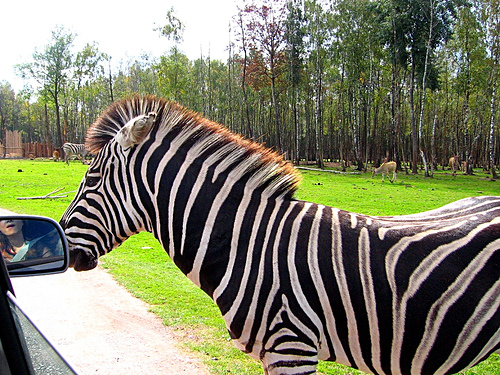

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

    8192/87910968 [..............................] - ETA: 0s

 4202496/87910968 [>.............................] - ETA: 3s

14581760/87910968 [===>..........................] - ETA: 1s

23289856/87910968 [======>.......................] - ETA: 0s

33120256/87910968 [==========>...................] - ETA: 0s

44285952/87910968 [==============>...............] - ETA: 0s

53239808/87910968 [=================>............] - ETA: 0s

63995904/87910968 [====================>.........] - ETA: 0s

75079680/87910968 [========================>.....] - ETA: 0s

85680128/87910968 [============================>.] - ETA: 0s

87910968/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [12]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [13]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [14]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [15]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [16]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24010, 24010, 6006, 6006)

## Create a tf.data dataset for training


Your images and captions are ready! Next, let's create a `tf.data` dataset to use for training your model.

In [17]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [18]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [22]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [28]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9040


Epoch 1 Batch 100 Loss 1.1321


Epoch 1 Batch 200 Loss 0.9657


Epoch 1 Batch 300 Loss 0.9452


Epoch 1 Loss 1.033760
Time taken for 1 epoch 147.59 sec



Epoch 2 Batch 0 Loss 0.8761


Epoch 2 Batch 100 Loss 0.7873


Epoch 2 Batch 200 Loss 0.8374


Epoch 2 Batch 300 Loss 0.8498


Epoch 2 Loss 0.777624
Time taken for 1 epoch 57.82 sec



Epoch 3 Batch 0 Loss 0.7543


Epoch 3 Batch 100 Loss 0.6674


Epoch 3 Batch 200 Loss 0.7227


Epoch 3 Batch 300 Loss 0.6803


Epoch 3 Loss 0.699581
Time taken for 1 epoch 57.73 sec



Epoch 4 Batch 0 Loss 0.7358


Epoch 4 Batch 100 Loss 0.6353


Epoch 4 Batch 200 Loss 0.6500


Epoch 4 Batch 300 Loss 0.6353


Epoch 4 Loss 0.650270
Time taken for 1 epoch 57.70 sec



Epoch 5 Batch 0 Loss 0.6276


Epoch 5 Batch 100 Loss 0.5497


Epoch 5 Batch 200 Loss 0.5869


Epoch 5 Batch 300 Loss 0.5766


Epoch 5 Loss 0.610114
Time taken for 1 epoch 57.67 sec



Epoch 6 Batch 0 Loss 0.5671


Epoch 6 Batch 100 Loss 0.5516


Epoch 6 Batch 200 Loss 0.5582


Epoch 6 Batch 300 Loss 0.5758


Epoch 6 Loss 0.575822
Time taken for 1 epoch 57.76 sec



Epoch 7 Batch 0 Loss 0.6537


Epoch 7 Batch 100 Loss 0.5586


Epoch 7 Batch 200 Loss 0.5351


Epoch 7 Batch 300 Loss 0.5348


Epoch 7 Loss 0.544230
Time taken for 1 epoch 57.65 sec



Epoch 8 Batch 0 Loss 0.5372


Epoch 8 Batch 100 Loss 0.4843


Epoch 8 Batch 200 Loss 0.5171


Epoch 8 Batch 300 Loss 0.5367


Epoch 8 Loss 0.516309
Time taken for 1 epoch 57.60 sec



Epoch 9 Batch 0 Loss 0.5621


Epoch 9 Batch 100 Loss 0.5091


Epoch 9 Batch 200 Loss 0.4685


Epoch 9 Batch 300 Loss 0.4437


Epoch 9 Loss 0.487771
Time taken for 1 epoch 57.56 sec



Epoch 10 Batch 0 Loss 0.4527


Epoch 10 Batch 100 Loss 0.4517


Epoch 10 Batch 200 Loss 0.4394


Epoch 10 Batch 300 Loss 0.4737


Epoch 10 Loss 0.462743
Time taken for 1 epoch 57.52 sec



Epoch 11 Batch 0 Loss 0.4689


Epoch 11 Batch 100 Loss 0.4200


Epoch 11 Batch 200 Loss 0.4695


Epoch 11 Batch 300 Loss 0.4373


Epoch 11 Loss 0.437498
Time taken for 1 epoch 57.61 sec



Epoch 12 Batch 0 Loss 0.4322


Epoch 12 Batch 100 Loss 0.4167


Epoch 12 Batch 200 Loss 0.4109


Epoch 12 Batch 300 Loss 0.4375


Epoch 12 Loss 0.413919
Time taken for 1 epoch 57.50 sec



Epoch 13 Batch 0 Loss 0.4104


Epoch 13 Batch 100 Loss 0.4194


Epoch 13 Batch 200 Loss 0.3696


Epoch 13 Batch 300 Loss 0.3344


Epoch 13 Loss 0.391727
Time taken for 1 epoch 57.51 sec



Epoch 14 Batch 0 Loss 0.3870


Epoch 14 Batch 100 Loss 0.3554


Epoch 14 Batch 200 Loss 0.3401


Epoch 14 Batch 300 Loss 0.3535


Epoch 14 Loss 0.371030
Time taken for 1 epoch 57.48 sec



Epoch 15 Batch 0 Loss 0.3836


Epoch 15 Batch 100 Loss 0.3911


Epoch 15 Batch 200 Loss 0.3609


Epoch 15 Batch 300 Loss 0.3276


Epoch 15 Loss 0.351505
Time taken for 1 epoch 58.04 sec



Epoch 16 Batch 0 Loss 0.3630


Epoch 16 Batch 100 Loss 0.3334


Epoch 16 Batch 200 Loss 0.3446


Epoch 16 Batch 300 Loss 0.3298


Epoch 16 Loss 0.334702
Time taken for 1 epoch 57.53 sec



Epoch 17 Batch 0 Loss 0.3531


Epoch 17 Batch 100 Loss 0.3121


Epoch 17 Batch 200 Loss 0.3323


Epoch 17 Batch 300 Loss 0.3379


Epoch 17 Loss 0.318561
Time taken for 1 epoch 57.44 sec



Epoch 18 Batch 0 Loss 0.3454


Epoch 18 Batch 100 Loss 0.3193


Epoch 18 Batch 200 Loss 0.2842


Epoch 18 Batch 300 Loss 0.3071


Epoch 18 Loss 0.304131
Time taken for 1 epoch 57.44 sec



Epoch 19 Batch 0 Loss 0.3615


Epoch 19 Batch 100 Loss 0.2894


Epoch 19 Batch 200 Loss 0.2797


Epoch 19 Batch 300 Loss 0.2777


Epoch 19 Loss 0.288646
Time taken for 1 epoch 57.41 sec



Epoch 20 Batch 0 Loss 0.3127


Epoch 20 Batch 100 Loss 0.2628


Epoch 20 Batch 200 Loss 0.2781


Epoch 20 Batch 300 Loss 0.2841


Epoch 20 Loss 0.276044
Time taken for 1 epoch 57.40 sec



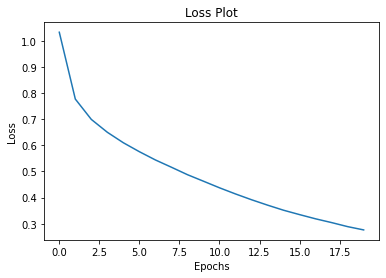

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [31]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a stuffed bear has been posed to appear it is reading a book. <end>
Prediction Caption: a shelf filled with lots of stuffed animal in front of a grill. <end>


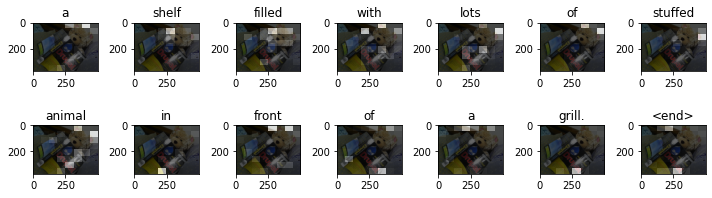

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


 8192/64400 [==>...........................] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

64400/64400 [==============================] - 0s 1us/step


Prediction Caption: surfer on a wave. <end>


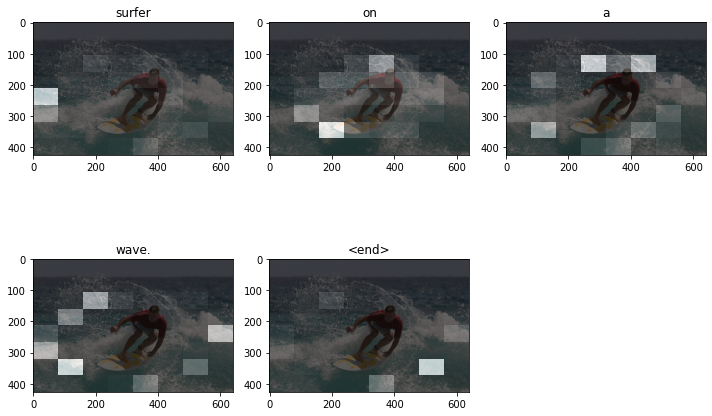

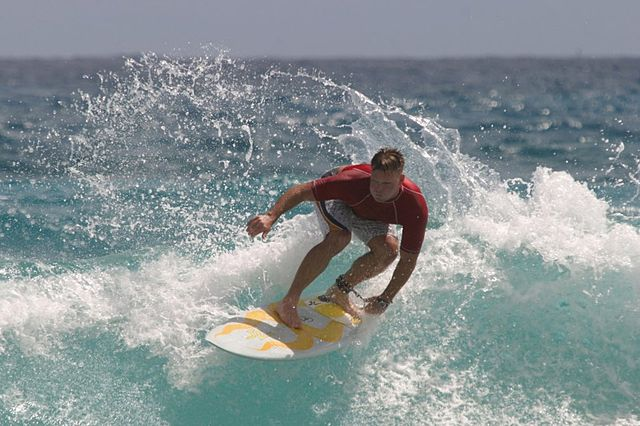

In [34]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.